# AIRL with TransactionsGraphEnvironment v2

In [35]:
import ast
import pickle

import gymnasium as gym
import matplotlib.pyplot as plt
import mlflow
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from imitation.algorithms.adversarial.airl import AIRL
from imitation.data.rollout import flatten_trajectories
from imitation.data.types import Trajectory
from imitation.data.wrappers import RolloutInfoWrapper
from imitation.rewards.reward_nets import BasicShapedRewardNet
from imitation.util import logger
from imitation.util.networks import RunningNorm
from imitation.util.util import make_vec_env
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
)
from sklearn.model_selection import train_test_split
from stable_baselines3 import PPO
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import VecCheckNan
from stable_baselines3.ppo import MlpPolicy
from stable_baselines3.common.evaluation import evaluate_policy


import graph_reinforcement_learning_using_blockchain_data as grl
from graph_reinforcement_learning_using_blockchain_data import config

config.load_dotenv()
mlflow.set_tracking_uri(uri=config.MLFLOW_TRACKING_URI)

In [2]:
RNG = np.random.default_rng(seed=42)

## Dataset 

In [3]:
df_emb = pd.read_csv(config.FLASHBOTS_Q2_DATA_DIR / "state_embeddings_pre_trained_128.csv")
df_class0 = pd.read_csv(config.RAW_DATA_DIR / "receipts_class0.csv")
df_class1 = pd.read_csv(config.RAW_DATA_DIR / "receipts_class1.csv")
df_eth_balances_class1 = pd.read_csv(config.RAW_DATA_DIR / "eth_balances_class1.csv")
df_eth_balances_class0 = pd.read_csv(config.RAW_DATA_DIR / "eth_balances_class0.csv")

with open(config.FLASHBOTS_Q2_DATA_DIR / "train_accounts.pkl", "rb") as f:
    train_accounts = pickle.load(f)

with open(config.FLASHBOTS_Q2_DATA_DIR / "test_accounts.pkl", "rb") as f:
    test_accounts = pickle.load(f)

In [4]:
print(df_class0.columns)
print(df_eth_balances_class0.columns)

Index(['block_number', 'transaction_hash', 'blockHash', 'blockNumber',
       'logsBloom', 'gasUsed', 'contractAddress', 'cumulativeGasUsed',
       'transactionIndex', 'from', 'to', 'type', 'effectiveGasPrice', 'logs',
       'status'],
      dtype='object')
Index(['account', 'block_number', 'balance'], dtype='object')


In [5]:
df_class0_with_eth_balances = df_class0.merge(
    df_eth_balances_class0,
    left_on=["from", "blockNumber"],
    right_on=["account", "block_number"],
    how="inner",
)
df_class1_with_eth_balances = df_class1.merge(
    df_eth_balances_class1,
    left_on=["from", "blockNumber"],
    right_on=["account", "block_number"],
    how="inner",
)

In [6]:
df_class0_multi_occ = df_class0_with_eth_balances[
    df_class0_with_eth_balances["from"].duplicated(keep=False)
]

In [7]:
df_emb["embeddings"] = df_emb["embeddings"].apply(
    lambda x: np.array(ast.literal_eval(x), dtype=np.float32)
)

In [8]:
df_class0_with_eth_balances["label"] = 0
df_class1_with_eth_balances["label"] = 1

In [9]:
df_receipts = pd.concat(
    [df_class0_with_eth_balances, df_class1_with_eth_balances], ignore_index=True
)
df_receipts.drop_duplicates("transaction_hash", inplace=True)
df = df_receipts.merge(df_emb, how="right", left_on="transaction_hash", right_on="transactionHash")

In [10]:
df.head()

,block_number_x,transaction_hash,blockHash,blockNumber,logsBloom,gasUsed,contractAddress,cumulativeGasUsed,transactionIndex,from,...,created_at,account_address,profit_token_address,start_amount,end_amount,profit_amount,error,protocols,transactionHash,embeddings
0,16969850,0xe4029c908cfc40f825051cd0957797c66196eb8ba437...,0x241b2ebd536a6f546ce2214bcf2146d359ae4e0cc4e3...,16969850,0x00000000000000000000000000000000000000000000...,21000,NaN,1315400,19,0x00000000000124d994209fbB955E0217B5C2ECA1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0xe4029c908cfc40f825051cd0957797c66196eb8ba437...,"[0.16500826, -0.09403816, 0.21792151, 0.012831..."
1,16975162,0xbcfb84169287cf7acce33fba2b7390cfe21852871f78...,0x577d4ef683ebd84c73cdbc3635c7177f6ec137eef3bf...,16975162,0x00000000000000000000000080000000000000000000...,116880,NaN,396290,3,0x00000000000124d994209fbB955E0217B5C2ECA1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0xbcfb84169287cf7acce33fba2b7390cfe21852871f78...,"[-0.09382023, -0.012681959, 0.14728837, 0.0354..."
2,16983327,0x7a954e541df7c296b8fec61b77d22ea8bacd63399467...,0xe79daae4074cb858a3e79b4d95064845295eaddc134c...,16983327,0x00000000000000000000000000000000000000000000...,103421,NaN,3934866,21,0x00000000000124d994209fbB955E0217B5C2ECA1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0x7a954e541df7c296b8fec61b77d22ea8bacd63399467...,"[-0.10671734, 0.0006063916, 0.160602, 0.039328..."
3,16990575,0x016858c7c133cdf545b6934653544c19475c5c111ba0...,0x9c3fa88c63603c9c5696174085177f9559e20b331a64...,16990575,0x00200000000000000000000080004000000000000000...,105953,NaN,4683545,39,0x00000000000124d994209fbB955E0217B5C2ECA1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0x016858c7c133cdf545b6934653544c19475c5c111ba0...,"[-0.11480839, 0.027570017, 0.22743803, 0.04695..."
4,16994491,0x0f358c5aed8ae456a298eedaf3fc08cb802c3417a6b4...,0xae6c66f64f13ba5404bbe4cebd33fdd666c7bc8fe601...,16994491,0x00200000000011000000000080000000000000000000...,223722,NaN,3972377,34,0x00000000000124d994209fbB955E0217B5C2ECA1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0x0f358c5aed8ae456a298eedaf3fc08cb802c3417a6b4...,"[-0.067668885, -0.094198264, 0.12297824, 0.158..."


In [11]:
df_median_gas_prices = pd.DataFrame(
    {
        "median_gas_price": df.groupby(["blockNumber"])["effectiveGasPrice"].median(),
        "std_gas_price": df.groupby(["blockNumber"])["effectiveGasPrice"].std(),
        "max_gas_price": df.groupby(["blockNumber"])["effectiveGasPrice"].max(),
        "min_gas_price": df.groupby(["blockNumber"])["effectiveGasPrice"].min(),
    }
)

df_with_median_gas_prices = df.merge(df_median_gas_prices, how="left", on="blockNumber")
df_with_median_gas_prices.head()

,block_number_x,transaction_hash,blockHash,blockNumber,logsBloom,gasUsed,contractAddress,cumulativeGasUsed,transactionIndex,from,...,end_amount,profit_amount,error,protocols,transactionHash,embeddings,median_gas_price,std_gas_price,max_gas_price,min_gas_price
0,16969850,0xe4029c908cfc40f825051cd0957797c66196eb8ba437...,0x241b2ebd536a6f546ce2214bcf2146d359ae4e0cc4e3...,16969850,0x00000000000000000000000000000000000000000000...,21000,NaN,1315400,19,0x00000000000124d994209fbB955E0217B5C2ECA1,...,NaN,NaN,NaN,NaN,0xe4029c908cfc40f825051cd0957797c66196eb8ba437...,"[0.16500826, -0.09403816, 0.21792151, 0.012831...",2.841278e+10,5.338623e+09,40046142239,27985774295
1,16975162,0xbcfb84169287cf7acce33fba2b7390cfe21852871f78...,0x577d4ef683ebd84c73cdbc3635c7177f6ec137eef3bf...,16975162,0x00000000000000000000000080000000000000000000...,116880,NaN,396290,3,0x00000000000124d994209fbB955E0217B5C2ECA1,...,NaN,NaN,NaN,NaN,0xbcfb84169287cf7acce33fba2b7390cfe21852871f78...,"[-0.09382023, -0.012681959, 0.14728837, 0.0354...",3.132425e+10,1.310671e+10,62912040686,29651658352
2,16983327,0x7a954e541df7c296b8fec61b77d22ea8bacd63399467...,0xe79daae4074cb858a3e79b4d95064845295eaddc134c...,16983327,0x00000000000000000000000000000000000000000000...,103421,NaN,3934866,21,0x00000000000124d994209fbB955E0217B5C2ECA1,...,NaN,NaN,NaN,NaN,0x7a954e541df7c296b8fec61b77d22ea8bacd63399467...,"[-0.10671734, 0.0006063916, 0.160602, 0.039328...",4.701599e+10,9.483538e+10,298140379626,44115991364
3,16990575,0x016858c7c133cdf545b6934653544c19475c5c111ba0...,0x9c3fa88c63603c9c5696174085177f9559e20b331a64...,16990575,0x00200000000000000000000080004000000000000000...,105953,NaN,4683545,39,0x00000000000124d994209fbB955E0217B5C2ECA1,...,NaN,NaN,NaN,NaN,0x016858c7c133cdf545b6934653544c19475c5c111ba0...,"[-0.11480839, 0.027570017, 0.22743803, 0.04695...",3.997607e+10,2.216894e+10,72384430845,29976074199
4,16994491,0x0f358c5aed8ae456a298eedaf3fc08cb802c3417a6b4...,0xae6c66f64f13ba5404bbe4cebd33fdd666c7bc8fe601...,16994491,0x00200000000011000000000080000000000000000000...,223722,NaN,3972377,34,0x00000000000124d994209fbB955E0217B5C2ECA1,...,NaN,NaN,NaN,NaN,0x0f358c5aed8ae456a298eedaf3fc08cb802c3417a6b4...,"[-0.067668885, -0.094198264, 0.12297824, 0.158...",2.695208e+10,3.320303e+09,30915355327,22915355327


In [12]:
df_with_actions = df_with_median_gas_prices.copy()
df_with_actions["action"] = df_with_median_gas_prices.apply(
    lambda r: 1 if r["effectiveGasPrice"] > r["median_gas_price"] else 0, axis=1
)

In [13]:
df_with_actions["action"].mean()

0.24449359876667337

In [14]:
df_with_actions.head()

,block_number_x,transaction_hash,blockHash,blockNumber,logsBloom,gasUsed,contractAddress,cumulativeGasUsed,transactionIndex,from,...,profit_amount,error,protocols,transactionHash,embeddings,median_gas_price,std_gas_price,max_gas_price,min_gas_price,action
0,16969850,0xe4029c908cfc40f825051cd0957797c66196eb8ba437...,0x241b2ebd536a6f546ce2214bcf2146d359ae4e0cc4e3...,16969850,0x00000000000000000000000000000000000000000000...,21000,NaN,1315400,19,0x00000000000124d994209fbB955E0217B5C2ECA1,...,NaN,NaN,NaN,0xe4029c908cfc40f825051cd0957797c66196eb8ba437...,"[0.16500826, -0.09403816, 0.21792151, 0.012831...",2.841278e+10,5.338623e+09,40046142239,27985774295,1
1,16975162,0xbcfb84169287cf7acce33fba2b7390cfe21852871f78...,0x577d4ef683ebd84c73cdbc3635c7177f6ec137eef3bf...,16975162,0x00000000000000000000000080000000000000000000...,116880,NaN,396290,3,0x00000000000124d994209fbB955E0217B5C2ECA1,...,NaN,NaN,NaN,0xbcfb84169287cf7acce33fba2b7390cfe21852871f78...,"[-0.09382023, -0.012681959, 0.14728837, 0.0354...",3.132425e+10,1.310671e+10,62912040686,29651658352,1
2,16983327,0x7a954e541df7c296b8fec61b77d22ea8bacd63399467...,0xe79daae4074cb858a3e79b4d95064845295eaddc134c...,16983327,0x00000000000000000000000000000000000000000000...,103421,NaN,3934866,21,0x00000000000124d994209fbB955E0217B5C2ECA1,...,NaN,NaN,NaN,0x7a954e541df7c296b8fec61b77d22ea8bacd63399467...,"[-0.10671734, 0.0006063916, 0.160602, 0.039328...",4.701599e+10,9.483538e+10,298140379626,44115991364,1
3,16990575,0x016858c7c133cdf545b6934653544c19475c5c111ba0...,0x9c3fa88c63603c9c5696174085177f9559e20b331a64...,16990575,0x00200000000000000000000080004000000000000000...,105953,NaN,4683545,39,0x00000000000124d994209fbB955E0217B5C2ECA1,...,NaN,NaN,NaN,0x016858c7c133cdf545b6934653544c19475c5c111ba0...,"[-0.11480839, 0.027570017, 0.22743803, 0.04695...",3.997607e+10,2.216894e+10,72384430845,29976074199,0
4,16994491,0x0f358c5aed8ae456a298eedaf3fc08cb802c3417a6b4...,0xae6c66f64f13ba5404bbe4cebd33fdd666c7bc8fe601...,16994491,0x00200000000011000000000080000000000000000000...,223722,NaN,3972377,34,0x00000000000124d994209fbB955E0217B5C2ECA1,...,NaN,NaN,NaN,0x0f358c5aed8ae456a298eedaf3fc08cb802c3417a6b4...,"[-0.067668885, -0.094198264, 0.12297824, 0.158...",2.695208e+10,3.320303e+09,30915355327,22915355327,1


In [15]:
df_with_actions.rename(columns={"balance": "eth_balance"}, inplace=True)
df_with_actions["eth_balance"] = df_with_actions["eth_balance"].astype("float64")
df_with_actions["median_gas_price"] = df_with_actions["median_gas_price"].astype("float64")
df_with_actions["std_gas_price"] = df_with_actions["std_gas_price"].astype("float64")
df_with_actions["from"] = df_with_actions["from"].astype("string")
df_with_actions["to"] = df_with_actions["to"].astype("string")
df_with_actions.head()

,block_number_x,transaction_hash,blockHash,blockNumber,logsBloom,gasUsed,contractAddress,cumulativeGasUsed,transactionIndex,from,...,profit_amount,error,protocols,transactionHash,embeddings,median_gas_price,std_gas_price,max_gas_price,min_gas_price,action
0,16969850,0xe4029c908cfc40f825051cd0957797c66196eb8ba437...,0x241b2ebd536a6f546ce2214bcf2146d359ae4e0cc4e3...,16969850,0x00000000000000000000000000000000000000000000...,21000,NaN,1315400,19,0x00000000000124d994209fbB955E0217B5C2ECA1,...,NaN,NaN,NaN,0xe4029c908cfc40f825051cd0957797c66196eb8ba437...,"[0.16500826, -0.09403816, 0.21792151, 0.012831...",2.841278e+10,5.338623e+09,40046142239,27985774295,1
1,16975162,0xbcfb84169287cf7acce33fba2b7390cfe21852871f78...,0x577d4ef683ebd84c73cdbc3635c7177f6ec137eef3bf...,16975162,0x00000000000000000000000080000000000000000000...,116880,NaN,396290,3,0x00000000000124d994209fbB955E0217B5C2ECA1,...,NaN,NaN,NaN,0xbcfb84169287cf7acce33fba2b7390cfe21852871f78...,"[-0.09382023, -0.012681959, 0.14728837, 0.0354...",3.132425e+10,1.310671e+10,62912040686,29651658352,1
2,16983327,0x7a954e541df7c296b8fec61b77d22ea8bacd63399467...,0xe79daae4074cb858a3e79b4d95064845295eaddc134c...,16983327,0x00000000000000000000000000000000000000000000...,103421,NaN,3934866,21,0x00000000000124d994209fbB955E0217B5C2ECA1,...,NaN,NaN,NaN,0x7a954e541df7c296b8fec61b77d22ea8bacd63399467...,"[-0.10671734, 0.0006063916, 0.160602, 0.039328...",4.701599e+10,9.483538e+10,298140379626,44115991364,1
3,16990575,0x016858c7c133cdf545b6934653544c19475c5c111ba0...,0x9c3fa88c63603c9c5696174085177f9559e20b331a64...,16990575,0x00200000000000000000000080004000000000000000...,105953,NaN,4683545,39,0x00000000000124d994209fbB955E0217B5C2ECA1,...,NaN,NaN,NaN,0x016858c7c133cdf545b6934653544c19475c5c111ba0...,"[-0.11480839, 0.027570017, 0.22743803, 0.04695...",3.997607e+10,2.216894e+10,72384430845,29976074199,0
4,16994491,0x0f358c5aed8ae456a298eedaf3fc08cb802c3417a6b4...,0xae6c66f64f13ba5404bbe4cebd33fdd666c7bc8fe601...,16994491,0x00200000000011000000000080000000000000000000...,223722,NaN,3972377,34,0x00000000000124d994209fbB955E0217B5C2ECA1,...,NaN,NaN,NaN,0x0f358c5aed8ae456a298eedaf3fc08cb802c3417a6b4...,"[-0.067668885, -0.094198264, 0.12297824, 0.158...",2.695208e+10,3.320303e+09,30915355327,22915355327,1


In [16]:
df_with_actions[df_with_actions["std_gas_price"].isna() == True]

,block_number_x,transaction_hash,blockHash,blockNumber,logsBloom,gasUsed,contractAddress,cumulativeGasUsed,transactionIndex,from,...,profit_amount,error,protocols,transactionHash,embeddings,median_gas_price,std_gas_price,max_gas_price,min_gas_price,action
63,16975107,0xd05a59ef18204af79ae9bf2a7ba722bca892055819c7...,0x8d8cd7dfa64a3867f12d472be895ee2a1b163d854a02...,16975107,0x00200000000000000000000080000000000008000000...,196537,NaN,685900,5,0x00000006e42915A2B6907f8b3fAF311B68862f60,...,6855415086744551,NaN,"[""uniswap_v2""]",0xd05a59ef18204af79ae9bf2a7ba722bca892055819c7...,"[0.33906102, 0.11006685, -0.11049971, -0.11027...",3.442311e+10,NaN,34423111170,34423111170,0
65,16976564,0x5530313d0b0271506691e3732c517172d5bfa1b2ba3d...,0x458b66a35808bf44a7e332b9f9b326ca8660952ab40a...,16976564,0x00200000000000000000000080000000200000000000...,190691,NaN,1322470,7,0x00000006e42915A2B6907f8b3fAF311B68862f60,...,7796163749018364,NaN,"[""uniswap_v2""]",0x5530313d0b0271506691e3732c517172d5bfa1b2ba3d...,"[0.41424438, 0.1412386, -0.15269175, -0.147597...",4.041179e+10,NaN,40411786608,40411786608,0
76,16979829,0xe47601937f0538ecc2a67c0a1b2481a1d339b52b2ef0...,0x4d1ebc8a72732a87fb083679233a06cf0a33ec984b35...,16979829,0x00200000000000000000000084000000200000000000...,158198,NaN,158198,0,0x00000006e42915A2B6907f8b3fAF311B68862f60,...,24408839782523421,NaN,"[""uniswap_v2"",""uniswap_v3""]",0xe47601937f0538ecc2a67c0a1b2481a1d339b52b2ef0...,"[0.4598713, 0.15552238, -0.16139461, -0.179502...",1.532201e+11,NaN,153220129205,153220129205,0
98,16992014,0x23e05562df7784836aaf6c8235d2aca5501621e6aab2...,0x8794222099471416ba2721137ee0e0d60a149b2f2029...,16992014,0x00200000000000000000000080000200000000000000...,219788,NaN,219788,0,0x00000006e42915A2B6907f8b3fAF311B68862f60,...,35168219119161781,NaN,"[""uniswap_v2"",""uniswap_v3""]",0x23e05562df7784836aaf6c8235d2aca5501621e6aab2...,"[0.46931684, 0.12999484, -0.15137316, -0.15249...",1.595249e+11,NaN,159524873969,159524873969,0
167,17240935,0x74e6628155b2f61c067a568235c952e3c1fa4aa22d76...,0xa658109201d2dcd46dcc9f5ad1c71d29d6942c44b1c4...,17240935,0x00000000040000000000000000000000000000000000...,210289,NaN,2954344,23,0x00000006e42915A2B6907f8b3fAF311B68862f60,...,13097045417966494,NaN,"[""uniswap_v3""]",0x74e6628155b2f61c067a568235c952e3c1fa4aa22d76...,"[0.31971875, 0.08582469, -0.06865533, -0.08339...",6.190800e+10,NaN,61907998723,61907998723,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149181,17296632,0x2f06cc7f885dd98fbf765ad57706fe505c5b63478928...,0x64522455567aa9a4209551fd938a1e31b448487ac157...,17296632,0x00200000000000000010000080000000000000000000...,178376,NaN,440031,1,0xffFf14106945bCB267B34711c416AA3085B8865F,...,22902832502491512,NaN,"[""uniswap_v2""]",0x2f06cc7f885dd98fbf765ad57706fe505c5b63478928...,"[0.6747055, 0.22695717, -0.25271302, -0.264935...",3.450291e+10,NaN,34502909809,34502909809,0
149182,17297932,0xd477617aaa93aad5aa5f5a2f880f3e934b70a91cd523...,0x493341206c063a7ba6c85137473b17f697ed72701c07...,17297932,0x00200000000000000010000080000000000000000000...,178388,NaN,440065,1,0xffFf14106945bCB267B34711c416AA3085B8865F,...,31467600199400760,NaN,"[""uniswap_v2""]",0xd477617aaa93aad5aa5f5a2f880f3e934b70a91cd523...,"[0.73240715, 0.24466729, -0.27648795, -0.27974...",2.928406e+10,NaN,29284056698,29284056698,0
149183,17298360,0xda0b7b1156a57ff85ef5c2e80f47d6fc0c89c6253fca...,0x21a1c5ae76e2cbff779f308288e1cf2273d999f978e1...,17298360,0x00200000000000000010000080000000000000000000...,178352,NaN,439975,1,0xffFf14106945bCB267B34711c416AA3085B8865F,...,38228015952142520,NaN,"[""uniswap_v2""]",0xda0b7b1156a57ff85ef5c2e80f47d6fc0c89c6253fca...,"[0.7970462, 0.2638063, -0.30356315, -0.2968765...",2.959543e+10,NaN,29595427147,29595427147,0
149184,17298379,0x7755b8553cc9f2479e5cc48ebf18dd6f25fe038a668f...,0xa0171ad96bcd73eb6aa92c8da1e3a8629c1c067ea811...,17298379,0x00200000000000000010000080000000000000000000...,178364,NaN,1162669,7,0xffFf14106945bCB267

In [17]:
df_with_actions = df_with_actions.fillna({"std_gas_price": 0})

In [18]:
df_with_actions_0 = df_with_actions[df_with_actions["label"] == 0]
df_with_actions_1 = df_with_actions[df_with_actions["label"] == 1]

In [19]:
validation_accounts, test_accounts_excl_val = train_test_split(
    test_accounts, test_size=0.5, random_state=42
)

In [20]:
df_with_actions_0_train = df_with_actions_0[df_with_actions_0["from"].isin(train_accounts)]
df_with_actions_0_val = df_with_actions_0[df_with_actions_0["from"].isin(validation_accounts)]
df_with_actions_0_test = df_with_actions_0[df_with_actions_0["from"].isin(test_accounts_excl_val)]

In [49]:
df_with_actions_1_train = df_with_actions_1[df_with_actions_1["from"].isin(train_accounts)]
df_with_actions_1_val = df_with_actions_1[df_with_actions_1["from"].isin(validation_accounts)]
df_with_actions_1_test = df_with_actions_1[df_with_actions_1["from"].isin(test_accounts_excl_val)]

In [22]:
df_val = pd.concat([df_with_actions_0_val, df_with_actions_1_val])

## Creating trajectories

In [23]:
def extract_trajectories(df: pd.DataFrame):
    trajectories = []
    for account, group in df.groupby("from"):
        group = group.sort_values("blockNumber")
        obs_list = group["embeddings"].tolist() + [np.zeros(128, dtype=np.float32)]
        traj = {
            "obs": np.stack(obs_list),  # Convert list of arrays to a single numpy array
            "acts": np.array(group["action"].tolist()),
            "label": group["label"].iloc[0],
        }
        trajectories.append(traj)
    return trajectories


trajectories_1_train = extract_trajectories(df_with_actions_1_train)
trajectories_0_train = extract_trajectories(df_with_actions_0_train)
trajectories_1_test = extract_trajectories(df_with_actions_1_test)
trajectories_0_test = extract_trajectories(df_with_actions_0_test)
trajectories_val = extract_trajectories(df_val)

In [24]:
trajectories_1 = [
    Trajectory(obs=traj["obs"], acts=traj["acts"], infos=None, terminal=True)
    for traj in trajectories_1_train
]
trajectories_0 = [
    Trajectory(obs=traj["obs"], acts=traj["acts"], infos=None, terminal=True)
    for traj in trajectories_0_train
]
trajectories_val = [
    Trajectory(obs=traj["obs"], acts=traj["acts"], infos=None, terminal=True)
    for traj in trajectories_val
]

trajectories_1 = flatten_trajectories(trajectories_1)
trajectories_0 = flatten_trajectories(trajectories_0)
trajectories_val = flatten_trajectories(trajectories_val)

In [25]:
trajectories_1_test = [
    Trajectory(obs=traj["obs"], acts=traj["acts"], infos=None, terminal=True)
    for traj in trajectories_1_test
]
trajectories_0_test = [
    Trajectory(obs=traj["obs"], acts=traj["acts"], infos=None, terminal=True)
    for traj in trajectories_0_test
]

trajectories_1_test = flatten_trajectories(trajectories_1_test)
trajectories_0_test = flatten_trajectories(trajectories_0_test)

## Setting up environments

In [26]:
ID0_train = "gymnasium_env/TransactionGraphEnv0-v2_train"
gym.envs.register(
    id=ID0_train,
    entry_point=grl.TransactionGraphEnvV2,
    kwargs={
        "df": df_with_actions_0_train,
        "alpha": 0.9,
        "device": torch.device("mps"),
        "label": 0,
    },
    max_episode_steps=300,
)

ID1_train = "gymnasium_env/TransactionGraphEnv1-v2_train"
gym.envs.register(
    id=ID1_train,
    entry_point=grl.TransactionGraphEnvV2,
    kwargs={
        "df": df_with_actions_1_train,
        "alpha": 0.9,
        "device": torch.device("mps"),
        "label": 1,
    },
    max_episode_steps=300,
)

ID0_test = "gymnasium_env/TransactionGraphEnv0-v2_test"
gym.envs.register(
    id=ID0_test,
    entry_point=grl.TransactionGraphEnvV2,
    kwargs={"df": df_with_actions_0_test, "alpha": 0.9, "device": torch.device("mps"), "label": 1},
    max_episode_steps=300,
)

ID1_test = "gymnasium_env/TransactionGraphEnv1-v2_test"
gym.envs.register(
    id=ID1_test,
    entry_point=grl.TransactionGraphEnvV2,
    kwargs={"df": df_with_actions_1_test, "alpha": 0.9, "device": torch.device("mps"), "label": 1},
    max_episode_steps=300,
)

In [27]:
gym.pprint_registry()

===== classic_control =====
Acrobot-v1                    CartPole-v0                   CartPole-v1
MountainCar-v0                MountainCarContinuous-v0      Pendulum-v1
===== phys2d =====
phys2d/CartPole-v0            phys2d/CartPole-v1            phys2d/Pendulum-v0
===== box2d =====
BipedalWalker-v3              BipedalWalkerHardcore-v3      CarRacing-v2
LunarLander-v2                LunarLanderContinuous-v2
===== toy_text =====
Blackjack-v1                  CliffWalking-v0               FrozenLake-v1
FrozenLake8x8-v1              Taxi-v3
===== tabular =====
tabular/Blackjack-v0          tabular/CliffWalking-v0
===== mujoco =====
Ant-v2                        Ant-v3                        Ant-v4
HalfCheetah-v2                HalfCheetah-v3                HalfCheetah-v4
Hopper-v2                     Hopper-v3                     Hopper-v4
Humanoid-v2                   Humanoid-v3                   Humanoid-v4
HumanoidStandup-v2            HumanoidStandup-v4            InvertedDouble

In [28]:
env0 = Monitor(gym.make(ID0_train))

venv0 = make_vec_env(
    ID0_train,
    rng=RNG,
    n_envs=1,
    post_wrappers=[lambda env, _: RolloutInfoWrapper(env)],
    parallel=False,
)

venv0 = VecCheckNan(venv0, raise_exception=True)  # Check for NaN observations
venv0.reset()

array([[-0.10653027, -0.26025823,  0.2016128 ,  0.21216592,  0.05542171,
        -0.10897412,  0.25234628,  0.22114934, -0.29932085, -0.1687794 ,
        -0.2753066 ,  0.31432003, -0.12181168, -0.22294343, -0.2354927 ,
         0.27538848,  0.06619147, -0.22298491, -0.19772327, -0.14404152,
         0.3566238 ,  0.071494  , -0.21295816,  0.19132628,  0.19085324,
        -0.14255738,  0.2529767 ,  0.14683434, -0.16421299, -0.23940253,
        -0.13084303,  0.14280032,  0.12190017,  0.20972219, -0.20378861,
         0.22310805,  0.3040776 , -0.19593115,  0.21361212,  0.21204847,
        -0.25010368, -0.26725796,  0.200844  , -0.05505758,  0.32557487,
         0.1504277 , -0.2975966 , -0.26081678,  0.18772373, -0.24638711,
        -0.31954932, -0.28004017,  0.20550278, -0.10744153, -0.07384334,
        -0.06011299,  0.1516397 , -0.19200993, -0.27446616, -0.14349428,
         0.2705156 ,  0.18223903, -0.11347108, -0.29370528, -0.15569976,
        -0.27508608,  0.20335871, -0.08363713, -0.0

In [29]:
env1 = Monitor(gym.make(ID1_train))

venv1 = make_vec_env(
    ID1_train,
    rng=RNG,
    n_envs=1,
    post_wrappers=[lambda env, _: RolloutInfoWrapper(env)],
    parallel=False,
)

venv1 = VecCheckNan(venv1, raise_exception=True)  # Check for NaN observations
venv1.reset()

array([[ 1.32190764e-01, -6.00432381e-02, -5.48094921e-02,
         1.30885374e-02,  1.21872164e-01,  4.76351827e-02,
        -2.89430749e-03, -1.18136153e-01,  2.42019892e-02,
        -2.55307741e-02,  4.52048033e-02,  6.28752112e-02,
         8.15204456e-02,  1.50845945e-03, -1.43495463e-02,
        -1.80596083e-01, -2.10106634e-02,  3.24268490e-02,
         7.88783133e-02,  7.70078525e-02, -4.63577136e-02,
        -1.85728922e-01,  2.73670629e-02, -5.06752729e-02,
         3.58511657e-02,  1.23562202e-01, -8.76447186e-02,
        -5.25902286e-02, -5.40671200e-02,  1.45159975e-01,
         2.04918142e-02, -3.98523025e-02,  6.95637101e-03,
        -8.14537704e-02,  2.74351351e-02, -1.09513097e-01,
         1.22778118e-04,  7.65746981e-02, -4.28602621e-02,
        -1.10055223e-01, -2.25327909e-03,  5.40641360e-02,
        -5.22150844e-03, -6.29216582e-02, -1.18848860e-01,
         6.94595873e-02,  1.10323995e-01,  7.60076568e-02,
        -1.04038432e-01,  7.43755475e-02,  5.05154207e-0

In [30]:
env1_test = Monitor(gym.make(ID1_test))

venv1_test = make_vec_env(
    ID1_test,
    rng=RNG,
    n_envs=1,
    post_wrappers=[lambda env, _: RolloutInfoWrapper(env)],
    parallel=False,
)

venv1_test = VecCheckNan(venv1_test, raise_exception=True)  # Check for NaN observations
venv1_test.reset()

array([[ 0.06472319, -0.10624935,  0.07619011,  0.05839549,  0.09536028,
        -0.01942884,  0.07278923,  0.00232194, -0.06386098, -0.10740504,
         0.00110872,  0.10206877,  0.00955275, -0.04596321, -0.02570999,
        -0.08008032,  0.07874099, -0.02026975, -0.02631466, -0.01686507,
         0.06617326, -0.11110867, -0.06331611,  0.00592582,  0.06671808,
         0.08080839, -0.02316251, -0.01522593, -0.06719388,  0.07192746,
        -0.03011054,  0.01810701,  0.01760875, -0.03166366, -0.01187991,
        -0.00576662,  0.05972845, -0.04108252, -0.01133338, -0.02748016,
        -0.09190217, -0.01087124,  0.06271456, -0.03236971,  0.0292644 ,
         0.04613005, -0.02465456,  0.0007704 , -0.05737201, -0.05687621,
        -0.06421244, -0.01748872,  0.00217859, -0.04285569,  0.04167715,
        -0.03487095, -0.03267057,  0.04060489, -0.10531653, -0.035976  ,
         0.09764314,  0.00353155,  0.0286072 , -0.11760889, -0.13367075,
        -0.1264122 ,  0.0363601 , -0.06937493,  0.0

In [31]:
env0_test = Monitor(gym.make(ID0_test))

venv0_test = make_vec_env(
    ID0_test,
    rng=RNG,
    n_envs=1,
    post_wrappers=[lambda env, _: RolloutInfoWrapper(env)],
    parallel=False,
)

venv0_test = VecCheckNan(venv0_test, raise_exception=True)  # Check for NaN observations
venv0_test.reset()

array([[-0.3081408 , -0.59485626,  0.31919712,  0.521042  ,  0.1598038 ,
        -0.23304568,  0.27742988,  0.39258412, -0.4229888 , -0.2670902 ,
        -0.36028057,  0.19671568, -0.22715002, -0.36054796, -0.47196618,
         0.28202856,  0.25838217, -0.25257832, -0.34660658, -0.2992285 ,
         0.4061698 ,  0.06247792, -0.16082174,  0.4904518 ,  0.3089345 ,
        -0.38299045,  0.3127833 ,  0.32284135, -0.52514327, -0.38352007,
        -0.03993561,  0.4132253 ,  0.16281573,  0.2879368 , -0.31017026,
         0.37803203,  0.62122834, -0.26256448,  0.32436526,  0.25883698,
        -0.45738107, -0.38941112,  0.47538847, -0.22245035,  0.553386  ,
         0.25983292, -0.35463768, -0.38081455,  0.21024567, -0.26538864,
        -0.34806222, -0.50040704,  0.45172194, -0.10263759, -0.08595119,
        -0.09463261,  0.1379387 , -0.35847095, -0.52951   , -0.33563274,
         0.37026238,  0.3832298 , -0.30266204, -0.32558912, -0.2540103 ,
        -0.46187085,  0.42046276, -0.09976535, -0.1

## AIRL setup

In [32]:
# Set parameters for the PPO algorithm (generator)
learning_rate = 0.001  # Learning rate, can be a function of progress
batch_size = 60  # Mini batch size for each gradient update
n_epochs = 15  # N of epochs when optimizing the surrogate loss

gamma = 0.5  # Discount factor, focus on the recent rewards
gae_lambda = 0  # Generalized advantage estimation
clip_range = 0.1  # Clipping parameter
ent_coef = 0.01  # Entropy coefficient for the loss calculation
vf_coef = 0.5  # Value function coef. for the loss calculation
max_grad_norm = 0.5  # The maximum value for the gradient clipping

verbose = 0  # Verbosity level: 0 no output, 1 info, 2 debug
normalize_advantage = True  # Whether to normalize or not the advantage

clip_range_vf = None  # Clip for the value function
use_sde = False  # Use State Dependent Exploration
sde_sample_freq = -1  # SDE - noise matrix frequency (-1 = disable)

# Set parameters for the AIRL trainer
gen_replay_buffer_capacity = None
allow_variable_horizon = True

disc_opt_kwargs = {
    "lr": 0.001,
}
policy_kwargs = {"use_expln": True}  # Fixing an issue with NaNs

In [33]:
# Set the number of timesteps, batch size and number of disc updates

# Total number of timesteps in the whole training
total_timesteps = 3000 * 100

# Generator
gen_train_timesteps = 3000  # N steps in the environment per one round
n_steps = gen_train_timesteps

# Discriminator batches
demo_minibatch_size = 60  # N samples in minibatch for one discrim. update
demo_batch_size = 300 * 10  # N samples in the batch of expert data (batch)
n_disc_updates_per_round = 4  # N discriminator updates per one round

In [34]:
hier_logger = logger.configure()
hier_logger.default_logger.output_formats.append(grl.MLflowOutputFormat())

In [33]:
# Initialize the learner PPO policy (generator)
learner0 = PPO(
    env=venv0,
    policy=MlpPolicy,
    policy_kwargs=policy_kwargs,
    learning_rate=learning_rate,
    n_steps=n_steps,
    batch_size=batch_size,
    n_epochs=n_epochs,
    gamma=gamma,
    gae_lambda=gae_lambda,
    clip_range=clip_range,
    clip_range_vf=clip_range_vf,
    normalize_advantage=normalize_advantage,
    ent_coef=ent_coef,
    vf_coef=vf_coef,
    max_grad_norm=max_grad_norm,
    use_sde=use_sde,
    sde_sample_freq=sde_sample_freq,
    verbose=verbose,
    seed=42,
    device="mps",
)

reward_net0 = BasicShapedRewardNet(
    observation_space=venv0.observation_space,
    action_space=venv0.action_space,
    normalize_input_layer=RunningNorm,
)

# Initialize the AIRL trainer
airl_trainer0 = AIRL(
    demonstrations=trajectories_0,
    demo_batch_size=demo_batch_size,
    demo_minibatch_size=demo_minibatch_size,
    n_disc_updates_per_round=n_disc_updates_per_round,
    gen_train_timesteps=gen_train_timesteps,
    gen_replay_buffer_capacity=gen_replay_buffer_capacity,
    venv=venv0,
    gen_algo=learner0,
    reward_net=reward_net0,
    allow_variable_horizon=allow_variable_horizon,
    disc_opt_kwargs=disc_opt_kwargs,
    custom_logger=hier_logger,
)

Running with `allow_variable_horizon` set to True. Some algorithms are biased towards shorter or longer episodes, which may significantly confound results. Additionally, even unbiased algorithms can exploit the information leak from the termination condition, producing spuriously high performance. See https://imitation.readthedocs.io/en/latest/getting-started/variable-horizon.html for more information.


In [34]:
# Initialize the learner PPO policy (generator)
learner1 = PPO(
    env=venv1,
    policy=MlpPolicy,
    policy_kwargs=policy_kwargs,
    learning_rate=learning_rate,
    n_steps=n_steps,
    batch_size=batch_size,
    n_epochs=n_epochs,
    gamma=gamma,
    gae_lambda=gae_lambda,
    clip_range=clip_range,
    clip_range_vf=clip_range_vf,
    normalize_advantage=normalize_advantage,
    ent_coef=ent_coef,
    vf_coef=vf_coef,
    max_grad_norm=max_grad_norm,
    use_sde=use_sde,
    sde_sample_freq=sde_sample_freq,
    verbose=verbose,
    seed=42,
    device="mps",
)

reward_net1 = BasicShapedRewardNet(
    observation_space=venv1.observation_space,
    action_space=venv1.action_space,
    normalize_input_layer=RunningNorm,
)

# Initialize the AIRL trainer
airl_trainer1 = AIRL(
    demonstrations=trajectories_1,
    demo_batch_size=demo_batch_size,
    demo_minibatch_size=demo_minibatch_size,
    n_disc_updates_per_round=n_disc_updates_per_round,
    gen_train_timesteps=gen_train_timesteps,
    gen_replay_buffer_capacity=gen_replay_buffer_capacity,
    venv=venv1,
    gen_algo=learner1,
    reward_net=reward_net1,
    allow_variable_horizon=allow_variable_horizon,
    disc_opt_kwargs=disc_opt_kwargs,
    custom_logger=hier_logger,
)

Running with `allow_variable_horizon` set to True. Some algorithms are biased towards shorter or longer episodes, which may significantly confound results. Additionally, even unbiased algorithms can exploit the information leak from the termination condition, producing spuriously high performance. See https://imitation.readthedocs.io/en/latest/getting-started/variable-horizon.html for more information.


## Training AIRL discriminator and generator, stats are saved with mlflow

We need to train 2 distinct airl trainers, one for arbitrage transactions and the other for class 0 transactions. The goal is to use the resulting reward functions to do classification.

In [35]:
mlflow.set_experiment("AIRLv2 DGI semi-supervised")

with mlflow.start_run():
    mlflow.log_param("n_steps", n_steps)
    mlflow.log_param("batch_size", batch_size)
    mlflow.log_param("total_timesteps", total_timesteps)

    airl_trainer1.train(total_timesteps=total_timesteps)

    learner1.save(config.MODELS_DIR / "learner1v2")
    torch.save(reward_net1, config.MODELS_DIR / "reward_net1v2")

    mlflow.log_artifact(config.MODELS_DIR / "learner1v2.zip")
    mlflow.log_artifact(config.MODELS_DIR / "reward_net1v2")
    mlflow.end_run()

round:   0%|          | 0/100 [00:00<?, ?it/s]

------------------------------------------
| raw/                        |          |
|    gen/rollout/ep_len_mean  | 33.1     |
|    gen/rollout/ep_rew_mean  | 16.2     |
|    gen/time/fps             | 25       |
|    gen/time/iterations      | 1        |
|    gen/time/time_elapsed    | 117      |
|    gen/time/total_timesteps | 3000     |
------------------------------------------
--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.5      |
|    disc/disc_acc_expert             | 1        |
|    disc/disc_acc_gen                | 0        |
|    disc/disc_entropy                | 0.592    |
|    disc/disc_loss                   | 0.0158   |
|    disc/disc_proportion_expert_pred | 1        |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 1        |
|    disc/n_expert                    | 60       |
|    disc/n_generated                 | 60       |
-

round:   1%|          | 1/100 [02:05<3:27:44, 125.91s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 33.4         |
|    gen/rollout/ep_rew_mean         | 16           |
|    gen/rollout/ep_rew_wrapped_mean | 37.2         |
|    gen/time/fps                    | 30           |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 98           |
|    gen/time/total_timesteps        | 6000         |
|    gen/train/approx_kl             | 0.0014911713 |
|    gen/train/clip_fraction         | 0.0919       |
|    gen/train/clip_range            | 0.1          |
|    gen/train/entropy_loss          | -0.691       |
|    gen/train/explained_variance    | 0.149        |
|    gen/train/learning_rate         | 0.001        |
|    gen/train/loss                  | 0.0502       |
|    gen/train/n_updates             | 15           |
|    gen/train/policy_gradient_loss  | -0.00141     |
|    gen/train/value_loss   

round:   2%|▏         | 2/100 [03:51<3:05:57, 113.85s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 30.1         |
|    gen/rollout/ep_rew_mean         | 14.5         |
|    gen/rollout/ep_rew_wrapped_mean | -3           |
|    gen/time/fps                    | 34           |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 86           |
|    gen/time/total_timesteps        | 9000         |
|    gen/train/approx_kl             | 0.0014441521 |
|    gen/train/clip_fraction         | 0.0832       |
|    gen/train/clip_range            | 0.1          |
|    gen/train/entropy_loss          | -0.691       |
|    gen/train/explained_variance    | -1.4         |
|    gen/train/learning_rate         | 0.001        |
|    gen/train/loss                  | 0.0287       |
|    gen/train/n_updates             | 30           |
|    gen/train/policy_gradient_loss  | -0.00136     |
|    gen/train/value_loss   

round:   3%|▎         | 3/100 [05:25<2:49:27, 104.82s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 29.1         |
|    gen/rollout/ep_rew_mean         | 14           |
|    gen/rollout/ep_rew_wrapped_mean | -13.1        |
|    gen/time/fps                    | 34           |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 87           |
|    gen/time/total_timesteps        | 12000        |
|    gen/train/approx_kl             | 0.0037850176 |
|    gen/train/clip_fraction         | 0.128        |
|    gen/train/clip_range            | 0.1          |
|    gen/train/entropy_loss          | -0.688       |
|    gen/train/explained_variance    | 0.451        |
|    gen/train/learning_rate         | 0.001        |
|    gen/train/loss                  | 0.0425       |
|    gen/train/n_updates             | 45           |
|    gen/train/policy_gradient_loss  | -0.00322     |
|    gen/train/value_loss   

round:   4%|▍         | 4/100 [06:59<2:41:08, 100.71s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 33.2         |
|    gen/rollout/ep_rew_mean         | 16.1         |
|    gen/rollout/ep_rew_wrapped_mean | -33.8        |
|    gen/time/fps                    | 38           |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 78           |
|    gen/time/total_timesteps        | 15000        |
|    gen/train/approx_kl             | 0.0031369156 |
|    gen/train/clip_fraction         | 0.103        |
|    gen/train/clip_range            | 0.1          |
|    gen/train/entropy_loss          | -0.681       |
|    gen/train/explained_variance    | 0.488        |
|    gen/train/learning_rate         | 0.001        |
|    gen/train/loss                  | 0.141        |
|    gen/train/n_updates             | 60           |
|    gen/train/policy_gradient_loss  | -0.00466     |
|    gen/train/value_loss   

round:   5%|▌         | 5/100 [08:25<2:31:01, 95.39s/it] 

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 24.4         |
|    gen/rollout/ep_rew_mean         | 12.6         |
|    gen/rollout/ep_rew_wrapped_mean | -38.6        |
|    gen/time/fps                    | 36           |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 81           |
|    gen/time/total_timesteps        | 18000        |
|    gen/train/approx_kl             | 0.0037454206 |
|    gen/train/clip_fraction         | 0.189        |
|    gen/train/clip_range            | 0.1          |
|    gen/train/entropy_loss          | -0.668       |
|    gen/train/explained_variance    | 0.85         |
|    gen/train/learning_rate         | 0.001        |
|    gen/train/loss                  | 0.13         |
|    gen/train/n_updates             | 75           |
|    gen/train/policy_gradient_loss  | -0.00746     |
|    gen/train/value_loss   

round:   6%|▌         | 6/100 [09:54<2:25:52, 93.12s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 26.2         |
|    gen/rollout/ep_rew_mean         | 13.5         |
|    gen/rollout/ep_rew_wrapped_mean | -35.7        |
|    gen/time/fps                    | 36           |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 82           |
|    gen/time/total_timesteps        | 21000        |
|    gen/train/approx_kl             | 0.0024380605 |
|    gen/train/clip_fraction         | 0.0877       |
|    gen/train/clip_range            | 0.1          |
|    gen/train/entropy_loss          | -0.647       |
|    gen/train/explained_variance    | 0.77         |
|    gen/train/learning_rate         | 0.001        |
|    gen/train/loss                  | 0.218        |
|    gen/train/n_updates             | 90           |
|    gen/train/policy_gradient_loss  | -0.00388     |
|    gen/train/value_loss   

round:   7%|▋         | 7/100 [11:24<2:22:35, 91.99s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 27.8         |
|    gen/rollout/ep_rew_mean         | 14.9         |
|    gen/rollout/ep_rew_wrapped_mean | -47.8        |
|    gen/time/fps                    | 32           |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 91           |
|    gen/time/total_timesteps        | 24000        |
|    gen/train/approx_kl             | 0.0029739868 |
|    gen/train/clip_fraction         | 0.128        |
|    gen/train/clip_range            | 0.1          |
|    gen/train/entropy_loss          | -0.627       |
|    gen/train/explained_variance    | 0.832        |
|    gen/train/learning_rate         | 0.001        |
|    gen/train/loss                  | 0.308        |
|    gen/train/n_updates             | 105          |
|    gen/train/policy_gradient_loss  | -0.00511     |
|    gen/train/value_loss   

round:   8%|▊         | 8/100 [13:02<2:24:15, 94.09s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 39.4         |
|    gen/rollout/ep_rew_mean         | 23.1         |
|    gen/rollout/ep_rew_wrapped_mean | -67.7        |
|    gen/time/fps                    | 34           |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 87           |
|    gen/time/total_timesteps        | 27000        |
|    gen/train/approx_kl             | 0.0027321642 |
|    gen/train/clip_fraction         | 0.125        |
|    gen/train/clip_range            | 0.1          |
|    gen/train/entropy_loss          | -0.602       |
|    gen/train/explained_variance    | 0.804        |
|    gen/train/learning_rate         | 0.001        |
|    gen/train/loss                  | 1.43         |
|    gen/train/n_updates             | 120          |
|    gen/train/policy_gradient_loss  | -0.00529     |
|    gen/train/value_loss   

round:   9%|▉         | 9/100 [14:37<2:23:09, 94.39s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 25.4        |
|    gen/rollout/ep_rew_mean         | 15.2        |
|    gen/rollout/ep_rew_wrapped_mean | -130        |
|    gen/time/fps                    | 32          |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 92          |
|    gen/time/total_timesteps        | 30000       |
|    gen/train/approx_kl             | 0.001082635 |
|    gen/train/clip_fraction         | 0.0635      |
|    gen/train/clip_range            | 0.1         |
|    gen/train/entropy_loss          | -0.574      |
|    gen/train/explained_variance    | 0.664       |
|    gen/train/learning_rate         | 0.001       |
|    gen/train/loss                  | 1.8         |
|    gen/train/n_updates             | 135         |
|    gen/train/policy_gradient_loss  | -0.00229    |
|    gen/train/value_loss            | 6.36   

round:  10%|█         | 10/100 [16:17<2:23:53, 95.92s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 29.3         |
|    gen/rollout/ep_rew_mean         | 18.5         |
|    gen/rollout/ep_rew_wrapped_mean | -82.4        |
|    gen/time/fps                    | 36           |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 81           |
|    gen/time/total_timesteps        | 33000        |
|    gen/train/approx_kl             | 0.0014252237 |
|    gen/train/clip_fraction         | 0.0964       |
|    gen/train/clip_range            | 0.1          |
|    gen/train/entropy_loss          | -0.55        |
|    gen/train/explained_variance    | 0.824        |
|    gen/train/learning_rate         | 0.001        |
|    gen/train/loss                  | 1.4          |
|    gen/train/n_updates             | 150          |
|    gen/train/policy_gradient_loss  | -0.0029      |
|    gen/train/value_loss   

round:  11%|█         | 11/100 [17:46<2:19:12, 93.85s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 27           |
|    gen/rollout/ep_rew_mean         | 17.1         |
|    gen/rollout/ep_rew_wrapped_mean | -103         |
|    gen/time/fps                    | 34           |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 86           |
|    gen/time/total_timesteps        | 36000        |
|    gen/train/approx_kl             | 0.0016734381 |
|    gen/train/clip_fraction         | 0.0712       |
|    gen/train/clip_range            | 0.1          |
|    gen/train/entropy_loss          | -0.533       |
|    gen/train/explained_variance    | 0.799        |
|    gen/train/learning_rate         | 0.001        |
|    gen/train/loss                  | 3.91         |
|    gen/train/n_updates             | 165          |
|    gen/train/policy_gradient_loss  | -0.00245     |
|    gen/train/value_loss   

round:  12%|█▏        | 12/100 [19:20<2:17:39, 93.86s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 35.5         |
|    gen/rollout/ep_rew_mean         | 23.7         |
|    gen/rollout/ep_rew_wrapped_mean | -92.9        |
|    gen/time/fps                    | 34           |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 86           |
|    gen/time/total_timesteps        | 39000        |
|    gen/train/approx_kl             | 0.0008976459 |
|    gen/train/clip_fraction         | 0.0667       |
|    gen/train/clip_range            | 0.1          |
|    gen/train/entropy_loss          | -0.528       |
|    gen/train/explained_variance    | 0.697        |
|    gen/train/learning_rate         | 0.001        |
|    gen/train/loss                  | 2.82         |
|    gen/train/n_updates             | 180          |
|    gen/train/policy_gradient_loss  | -0.000616    |
|    gen/train/value_loss   

round:  13%|█▎        | 13/100 [20:53<2:16:00, 93.79s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 23.6         |
|    gen/rollout/ep_rew_mean         | 15           |
|    gen/rollout/ep_rew_wrapped_mean | -170         |
|    gen/time/fps                    | 35           |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 84           |
|    gen/time/total_timesteps        | 42000        |
|    gen/train/approx_kl             | 0.0008393395 |
|    gen/train/clip_fraction         | 0.0234       |
|    gen/train/clip_range            | 0.1          |
|    gen/train/entropy_loss          | -0.497       |
|    gen/train/explained_variance    | 0.763        |
|    gen/train/learning_rate         | 0.001        |
|    gen/train/loss                  | 2.98         |
|    gen/train/n_updates             | 195          |
|    gen/train/policy_gradient_loss  | -0.000681    |
|    gen/train/value_loss   

round:  14%|█▍        | 14/100 [22:25<2:13:38, 93.24s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 29.4         |
|    gen/rollout/ep_rew_mean         | 19.3         |
|    gen/rollout/ep_rew_wrapped_mean | -96.8        |
|    gen/time/fps                    | 36           |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 82           |
|    gen/time/total_timesteps        | 45000        |
|    gen/train/approx_kl             | 0.0011602845 |
|    gen/train/clip_fraction         | 0.083        |
|    gen/train/clip_range            | 0.1          |
|    gen/train/entropy_loss          | -0.495       |
|    gen/train/explained_variance    | 0.823        |
|    gen/train/learning_rate         | 0.001        |
|    gen/train/loss                  | 12.2         |
|    gen/train/n_updates             | 210          |
|    gen/train/policy_gradient_loss  | -0.00245     |
|    gen/train/value_loss   

round:  15%|█▌        | 15/100 [23:55<2:10:24, 92.05s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 31.9         |
|    gen/rollout/ep_rew_mean         | 21.6         |
|    gen/rollout/ep_rew_wrapped_mean | -127         |
|    gen/time/fps                    | 35           |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 84           |
|    gen/time/total_timesteps        | 48000        |
|    gen/train/approx_kl             | 0.0010980803 |
|    gen/train/clip_fraction         | 0.0841       |
|    gen/train/clip_range            | 0.1          |
|    gen/train/entropy_loss          | -0.479       |
|    gen/train/explained_variance    | 0.859        |
|    gen/train/learning_rate         | 0.001        |
|    gen/train/loss                  | 2.73         |
|    gen/train/n_updates             | 225          |
|    gen/train/policy_gradient_loss  | -0.00245     |
|    gen/train/value_loss   

round:  16%|█▌        | 16/100 [25:26<2:08:33, 91.83s/it]

------------------------------------------------------
| raw/                               |               |
|    gen/rollout/ep_len_mean         | 25.5          |
|    gen/rollout/ep_rew_mean         | 17.2          |
|    gen/rollout/ep_rew_wrapped_mean | -155          |
|    gen/time/fps                    | 37            |
|    gen/time/iterations             | 1             |
|    gen/time/time_elapsed           | 79            |
|    gen/time/total_timesteps        | 51000         |
|    gen/train/approx_kl             | 0.00069111906 |
|    gen/train/clip_fraction         | 0.0419        |
|    gen/train/clip_range            | 0.1           |
|    gen/train/entropy_loss          | -0.472        |
|    gen/train/explained_variance    | 0.842         |
|    gen/train/learning_rate         | 0.001         |
|    gen/train/loss                  | 1.33          |
|    gen/train/n_updates             | 240           |
|    gen/train/policy_gradient_loss  | -0.00108      |
|    gen/t

round:  17%|█▋        | 17/100 [26:53<2:05:04, 90.42s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 29.5         |
|    gen/rollout/ep_rew_mean         | 19.8         |
|    gen/rollout/ep_rew_wrapped_mean | -111         |
|    gen/time/fps                    | 35           |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 85           |
|    gen/time/total_timesteps        | 54000        |
|    gen/train/approx_kl             | 0.0017419972 |
|    gen/train/clip_fraction         | 0.104        |
|    gen/train/clip_range            | 0.1          |
|    gen/train/entropy_loss          | -0.449       |
|    gen/train/explained_variance    | 0.849        |
|    gen/train/learning_rate         | 0.001        |
|    gen/train/loss                  | 7.31         |
|    gen/train/n_updates             | 255          |
|    gen/train/policy_gradient_loss  | -0.00264     |
|    gen/train/value_loss   

round:  18%|█▊        | 18/100 [28:25<2:04:19, 90.97s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 37.1         |
|    gen/rollout/ep_rew_mean         | 26.2         |
|    gen/rollout/ep_rew_wrapped_mean | -147         |
|    gen/time/fps                    | 33           |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 90           |
|    gen/time/total_timesteps        | 57000        |
|    gen/train/approx_kl             | 0.0011987691 |
|    gen/train/clip_fraction         | 0.0658       |
|    gen/train/clip_range            | 0.1          |
|    gen/train/entropy_loss          | -0.437       |
|    gen/train/explained_variance    | 0.815        |
|    gen/train/learning_rate         | 0.001        |
|    gen/train/loss                  | 4.7          |
|    gen/train/n_updates             | 270          |
|    gen/train/policy_gradient_loss  | -0.000138    |
|    gen/train/value_loss   

round:  19%|█▉        | 19/100 [30:03<2:05:32, 92.99s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 31.6         |
|    gen/rollout/ep_rew_mean         | 23.2         |
|    gen/rollout/ep_rew_wrapped_mean | -212         |
|    gen/time/fps                    | 33           |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 88           |
|    gen/time/total_timesteps        | 60000        |
|    gen/train/approx_kl             | 0.0012974697 |
|    gen/train/clip_fraction         | 0.0731       |
|    gen/train/clip_range            | 0.1          |
|    gen/train/entropy_loss          | -0.416       |
|    gen/train/explained_variance    | 0.776        |
|    gen/train/learning_rate         | 0.001        |
|    gen/train/loss                  | 1.85         |
|    gen/train/n_updates             | 285          |
|    gen/train/policy_gradient_loss  | -0.0012      |
|    gen/train/value_loss   

round:  20%|██        | 20/100 [31:39<2:05:14, 93.93s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 22.1         |
|    gen/rollout/ep_rew_mean         | 16.5         |
|    gen/rollout/ep_rew_wrapped_mean | -166         |
|    gen/time/fps                    | 37           |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 80           |
|    gen/time/total_timesteps        | 63000        |
|    gen/train/approx_kl             | 0.0013650336 |
|    gen/train/clip_fraction         | 0.074        |
|    gen/train/clip_range            | 0.1          |
|    gen/train/entropy_loss          | -0.374       |
|    gen/train/explained_variance    | 0.828        |
|    gen/train/learning_rate         | 0.001        |
|    gen/train/loss                  | 2.3          |
|    gen/train/n_updates             | 300          |
|    gen/train/policy_gradient_loss  | -0.00198     |
|    gen/train/value_loss   

round:  21%|██        | 21/100 [33:07<2:01:14, 92.09s/it]

------------------------------------------------------
| raw/                               |               |
|    gen/rollout/ep_len_mean         | 33.6          |
|    gen/rollout/ep_rew_mean         | 25.3          |
|    gen/rollout/ep_rew_wrapped_mean | -131          |
|    gen/time/fps                    | 36            |
|    gen/time/iterations             | 1             |
|    gen/time/time_elapsed           | 82            |
|    gen/time/total_timesteps        | 66000         |
|    gen/train/approx_kl             | 0.00086603686 |
|    gen/train/clip_fraction         | 0.0384        |
|    gen/train/clip_range            | 0.1           |
|    gen/train/entropy_loss          | -0.345        |
|    gen/train/explained_variance    | 0.793         |
|    gen/train/learning_rate         | 0.001         |
|    gen/train/loss                  | 6.78          |
|    gen/train/n_updates             | 315           |
|    gen/train/policy_gradient_loss  | -0.00144      |
|    gen/t

round:  22%|██▏       | 22/100 [34:36<1:58:38, 91.27s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 32.8         |
|    gen/rollout/ep_rew_mean         | 25.5         |
|    gen/rollout/ep_rew_wrapped_mean | -204         |
|    gen/time/fps                    | 36           |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 82           |
|    gen/time/total_timesteps        | 69000        |
|    gen/train/approx_kl             | 0.0011524396 |
|    gen/train/clip_fraction         | 0.0678       |
|    gen/train/clip_range            | 0.1          |
|    gen/train/entropy_loss          | -0.361       |
|    gen/train/explained_variance    | 0.811        |
|    gen/train/learning_rate         | 0.001        |
|    gen/train/loss                  | 10.5         |
|    gen/train/n_updates             | 330          |
|    gen/train/policy_gradient_loss  | -0.00104     |
|    gen/train/value_loss   

round:  23%|██▎       | 23/100 [36:06<1:56:26, 90.73s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 27.1        |
|    gen/rollout/ep_rew_mean         | 21.2        |
|    gen/rollout/ep_rew_wrapped_mean | -199        |
|    gen/time/fps                    | 33          |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 90          |
|    gen/time/total_timesteps        | 72000       |
|    gen/train/approx_kl             | 0.001558628 |
|    gen/train/clip_fraction         | 0.0512      |
|    gen/train/clip_range            | 0.1         |
|    gen/train/entropy_loss          | -0.333      |
|    gen/train/explained_variance    | 0.833       |
|    gen/train/learning_rate         | 0.001       |
|    gen/train/loss                  | 5.43        |
|    gen/train/n_updates             | 345         |
|    gen/train/policy_gradient_loss  | -0.000951   |
|    gen/train/value_loss            | 14.1   

round:  24%|██▍       | 24/100 [37:43<1:57:27, 92.72s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 24.8        |
|    gen/rollout/ep_rew_mean         | 17.9        |
|    gen/rollout/ep_rew_wrapped_mean | -177        |
|    gen/time/fps                    | 35          |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 83          |
|    gen/time/total_timesteps        | 75000       |
|    gen/train/approx_kl             | 0.001540161 |
|    gen/train/clip_fraction         | 0.0336      |
|    gen/train/clip_range            | 0.1         |
|    gen/train/entropy_loss          | -0.319      |
|    gen/train/explained_variance    | 0.807       |
|    gen/train/learning_rate         | 0.001       |
|    gen/train/loss                  | 7.65        |
|    gen/train/n_updates             | 360         |
|    gen/train/policy_gradient_loss  | -0.00112    |
|    gen/train/value_loss            | 24.2   

round:  25%|██▌       | 25/100 [39:14<1:55:13, 92.19s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 29.1         |
|    gen/rollout/ep_rew_mean         | 22.8         |
|    gen/rollout/ep_rew_wrapped_mean | -179         |
|    gen/time/fps                    | 36           |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 81           |
|    gen/time/total_timesteps        | 78000        |
|    gen/train/approx_kl             | 0.0036519764 |
|    gen/train/clip_fraction         | 0.0832       |
|    gen/train/clip_range            | 0.1          |
|    gen/train/entropy_loss          | -0.402       |
|    gen/train/explained_variance    | 0.818        |
|    gen/train/learning_rate         | 0.001        |
|    gen/train/loss                  | 11.2         |
|    gen/train/n_updates             | 375          |
|    gen/train/policy_gradient_loss  | 0.00129      |
|    gen/train/value_loss   

round:  26%|██▌       | 26/100 [40:43<1:52:20, 91.09s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 18.8         |
|    gen/rollout/ep_rew_mean         | 14.3         |
|    gen/rollout/ep_rew_wrapped_mean | -191         |
|    gen/time/fps                    | 36           |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 82           |
|    gen/time/total_timesteps        | 81000        |
|    gen/train/approx_kl             | 0.0013124964 |
|    gen/train/clip_fraction         | 0.0315       |
|    gen/train/clip_range            | 0.1          |
|    gen/train/entropy_loss          | -0.334       |
|    gen/train/explained_variance    | 0.84         |
|    gen/train/learning_rate         | 0.001        |
|    gen/train/loss                  | 7.72         |
|    gen/train/n_updates             | 390          |
|    gen/train/policy_gradient_loss  | -0.000541    |
|    gen/train/value_loss   

round:  27%|██▋       | 27/100 [42:12<1:50:12, 90.59s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 19.1         |
|    gen/rollout/ep_rew_mean         | 14.4         |
|    gen/rollout/ep_rew_wrapped_mean | -108         |
|    gen/time/fps                    | 35           |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 84           |
|    gen/time/total_timesteps        | 84000        |
|    gen/train/approx_kl             | 0.0012686797 |
|    gen/train/clip_fraction         | 0.041        |
|    gen/train/clip_range            | 0.1          |
|    gen/train/entropy_loss          | -0.335       |
|    gen/train/explained_variance    | 0.805        |
|    gen/train/learning_rate         | 0.001        |
|    gen/train/loss                  | 7.92         |
|    gen/train/n_updates             | 405          |
|    gen/train/policy_gradient_loss  | -7.72e-05    |
|    gen/train/value_loss   

round:  28%|██▊       | 28/100 [43:44<1:49:15, 91.05s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 18.6         |
|    gen/rollout/ep_rew_mean         | 13.9         |
|    gen/rollout/ep_rew_wrapped_mean | -112         |
|    gen/time/fps                    | 36           |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 81           |
|    gen/time/total_timesteps        | 87000        |
|    gen/train/approx_kl             | 0.0023351961 |
|    gen/train/clip_fraction         | 0.0616       |
|    gen/train/clip_range            | 0.1          |
|    gen/train/entropy_loss          | -0.325       |
|    gen/train/explained_variance    | 0.843        |
|    gen/train/learning_rate         | 0.001        |
|    gen/train/loss                  | 4.88         |
|    gen/train/n_updates             | 420          |
|    gen/train/policy_gradient_loss  | -0.000982    |
|    gen/train/value_loss   

round:  29%|██▉       | 29/100 [45:13<1:46:54, 90.35s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 26.1         |
|    gen/rollout/ep_rew_mean         | 21           |
|    gen/rollout/ep_rew_wrapped_mean | -141         |
|    gen/time/fps                    | 39           |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 75           |
|    gen/time/total_timesteps        | 90000        |
|    gen/train/approx_kl             | 0.0021690668 |
|    gen/train/clip_fraction         | 0.0474       |
|    gen/train/clip_range            | 0.1          |
|    gen/train/entropy_loss          | -0.322       |
|    gen/train/explained_variance    | 0.849        |
|    gen/train/learning_rate         | 0.001        |
|    gen/train/loss                  | 15.4         |
|    gen/train/n_updates             | 435          |
|    gen/train/policy_gradient_loss  | -0.000994    |
|    gen/train/value_loss   

round:  30%|███       | 30/100 [46:35<1:42:39, 87.99s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 24.2         |
|    gen/rollout/ep_rew_mean         | 20.3         |
|    gen/rollout/ep_rew_wrapped_mean | -174         |
|    gen/time/fps                    | 36           |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 82           |
|    gen/time/total_timesteps        | 93000        |
|    gen/train/approx_kl             | 0.0015849792 |
|    gen/train/clip_fraction         | 0.0399       |
|    gen/train/clip_range            | 0.1          |
|    gen/train/entropy_loss          | -0.254       |
|    gen/train/explained_variance    | 0.827        |
|    gen/train/learning_rate         | 0.001        |
|    gen/train/loss                  | 9.67         |
|    gen/train/n_updates             | 450          |
|    gen/train/policy_gradient_loss  | -0.00131     |
|    gen/train/value_loss   

round:  31%|███       | 31/100 [48:05<1:41:50, 88.56s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 20.2        |
|    gen/rollout/ep_rew_mean         | 16.5        |
|    gen/rollout/ep_rew_wrapped_mean | -153        |
|    gen/time/fps                    | 35          |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 83          |
|    gen/time/total_timesteps        | 96000       |
|    gen/train/approx_kl             | 0.001331921 |
|    gen/train/clip_fraction         | 0.0317      |
|    gen/train/clip_range            | 0.1         |
|    gen/train/entropy_loss          | -0.236      |
|    gen/train/explained_variance    | 0.836       |
|    gen/train/learning_rate         | 0.001       |
|    gen/train/loss                  | 7.4         |
|    gen/train/n_updates             | 465         |
|    gen/train/policy_gradient_loss  | -0.000181   |
|    gen/train/value_loss            | 17.2   

round:  32%|███▏      | 32/100 [49:36<1:41:04, 89.19s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 36.9         |
|    gen/rollout/ep_rew_mean         | 30.9         |
|    gen/rollout/ep_rew_wrapped_mean | -160         |
|    gen/time/fps                    | 37           |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 80           |
|    gen/time/total_timesteps        | 99000        |
|    gen/train/approx_kl             | 0.0020646094 |
|    gen/train/clip_fraction         | 0.0385       |
|    gen/train/clip_range            | 0.1          |
|    gen/train/entropy_loss          | -0.229       |
|    gen/train/explained_variance    | 0.844        |
|    gen/train/learning_rate         | 0.001        |
|    gen/train/loss                  | 8.77         |
|    gen/train/n_updates             | 480          |
|    gen/train/policy_gradient_loss  | -0.000251    |
|    gen/train/value_loss   

round:  33%|███▎      | 33/100 [51:03<1:39:00, 88.66s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 28.8         |
|    gen/rollout/ep_rew_mean         | 25.2         |
|    gen/rollout/ep_rew_wrapped_mean | -257         |
|    gen/time/fps                    | 34           |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 87           |
|    gen/time/total_timesteps        | 102000       |
|    gen/train/approx_kl             | 0.0017148891 |
|    gen/train/clip_fraction         | 0.0546       |
|    gen/train/clip_range            | 0.1          |
|    gen/train/entropy_loss          | -0.234       |
|    gen/train/explained_variance    | 0.836        |
|    gen/train/learning_rate         | 0.001        |
|    gen/train/loss                  | 7.16         |
|    gen/train/n_updates             | 495          |
|    gen/train/policy_gradient_loss  | -0.000628    |
|    gen/train/value_loss   

round:  34%|███▍      | 34/100 [52:38<1:39:26, 90.40s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 26.4         |
|    gen/rollout/ep_rew_mean         | 22.6         |
|    gen/rollout/ep_rew_wrapped_mean | -237         |
|    gen/time/fps                    | 34           |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 88           |
|    gen/time/total_timesteps        | 105000       |
|    gen/train/approx_kl             | 0.0025848707 |
|    gen/train/clip_fraction         | 0.0278       |
|    gen/train/clip_range            | 0.1          |
|    gen/train/entropy_loss          | -0.202       |
|    gen/train/explained_variance    | 0.809        |
|    gen/train/learning_rate         | 0.001        |
|    gen/train/loss                  | 11.8         |
|    gen/train/n_updates             | 510          |
|    gen/train/policy_gradient_loss  | -0.000808    |
|    gen/train/value_loss   

round:  35%|███▌      | 35/100 [54:13<1:39:30, 91.85s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 40.3         |
|    gen/rollout/ep_rew_mean         | 34.3         |
|    gen/rollout/ep_rew_wrapped_mean | -179         |
|    gen/time/fps                    | 34           |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 86           |
|    gen/time/total_timesteps        | 108000       |
|    gen/train/approx_kl             | 0.0027265837 |
|    gen/train/clip_fraction         | 0.0346       |
|    gen/train/clip_range            | 0.1          |
|    gen/train/entropy_loss          | -0.201       |
|    gen/train/explained_variance    | 0.82         |
|    gen/train/learning_rate         | 0.001        |
|    gen/train/loss                  | 18.2         |
|    gen/train/n_updates             | 525          |
|    gen/train/policy_gradient_loss  | 0.000449     |
|    gen/train/value_loss   

round:  36%|███▌      | 36/100 [55:47<1:38:36, 92.45s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 18.4         |
|    gen/rollout/ep_rew_mean         | 15.8         |
|    gen/rollout/ep_rew_wrapped_mean | -290         |
|    gen/time/fps                    | 35           |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 84           |
|    gen/time/total_timesteps        | 111000       |
|    gen/train/approx_kl             | 0.0031859968 |
|    gen/train/clip_fraction         | 0.0508       |
|    gen/train/clip_range            | 0.1          |
|    gen/train/entropy_loss          | -0.209       |
|    gen/train/explained_variance    | 0.731        |
|    gen/train/learning_rate         | 0.001        |
|    gen/train/loss                  | 12.5         |
|    gen/train/n_updates             | 540          |
|    gen/train/policy_gradient_loss  | -0.000436    |
|    gen/train/value_loss   

round:  37%|███▋      | 37/100 [57:19<1:36:59, 92.37s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 25.8         |
|    gen/rollout/ep_rew_mean         | 22.3         |
|    gen/rollout/ep_rew_wrapped_mean | -130         |
|    gen/time/fps                    | 34           |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 86           |
|    gen/time/total_timesteps        | 114000       |
|    gen/train/approx_kl             | 0.0032924735 |
|    gen/train/clip_fraction         | 0.0513       |
|    gen/train/clip_range            | 0.1          |
|    gen/train/entropy_loss          | -0.188       |
|    gen/train/explained_variance    | 0.836        |
|    gen/train/learning_rate         | 0.001        |
|    gen/train/loss                  | 8.85         |
|    gen/train/n_updates             | 555          |
|    gen/train/policy_gradient_loss  | -0.0011      |
|    gen/train/value_loss   

round:  38%|███▊      | 38/100 [58:53<1:36:02, 92.94s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 22.3         |
|    gen/rollout/ep_rew_mean         | 19.3         |
|    gen/rollout/ep_rew_wrapped_mean | -222         |
|    gen/time/fps                    | 34           |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 86           |
|    gen/time/total_timesteps        | 117000       |
|    gen/train/approx_kl             | 0.0039565447 |
|    gen/train/clip_fraction         | 0.0489       |
|    gen/train/clip_range            | 0.1          |
|    gen/train/entropy_loss          | -0.169       |
|    gen/train/explained_variance    | 0.797        |
|    gen/train/learning_rate         | 0.001        |
|    gen/train/loss                  | 10.4         |
|    gen/train/n_updates             | 570          |
|    gen/train/policy_gradient_loss  | 0.00055      |
|    gen/train/value_loss   

round:  39%|███▉      | 39/100 [1:00:27<1:34:51, 93.30s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 29.6         |
|    gen/rollout/ep_rew_mean         | 26.8         |
|    gen/rollout/ep_rew_wrapped_mean | -152         |
|    gen/time/fps                    | 36           |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 82           |
|    gen/time/total_timesteps        | 120000       |
|    gen/train/approx_kl             | 0.0018613962 |
|    gen/train/clip_fraction         | 0.0281       |
|    gen/train/clip_range            | 0.1          |
|    gen/train/entropy_loss          | -0.147       |
|    gen/train/explained_variance    | 0.822        |
|    gen/train/learning_rate         | 0.001        |
|    gen/train/loss                  | 4.9          |
|    gen/train/n_updates             | 585          |
|    gen/train/policy_gradient_loss  | 0.000147     |
|    gen/train/value_loss   

round:  40%|████      | 40/100 [1:01:57<1:32:10, 92.17s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 27.6         |
|    gen/rollout/ep_rew_mean         | 24.8         |
|    gen/rollout/ep_rew_wrapped_mean | -251         |
|    gen/time/fps                    | 35           |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 84           |
|    gen/time/total_timesteps        | 123000       |
|    gen/train/approx_kl             | 0.0002100328 |
|    gen/train/clip_fraction         | 0.00933      |
|    gen/train/clip_range            | 0.1          |
|    gen/train/entropy_loss          | -0.133       |
|    gen/train/explained_variance    | 0.856        |
|    gen/train/learning_rate         | 0.001        |
|    gen/train/loss                  | 6.82         |
|    gen/train/n_updates             | 600          |
|    gen/train/policy_gradient_loss  | -0.000184    |
|    gen/train/value_loss   

round:  41%|████      | 41/100 [1:03:30<1:30:57, 92.50s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 26.4         |
|    gen/rollout/ep_rew_mean         | 24.5         |
|    gen/rollout/ep_rew_wrapped_mean | -196         |
|    gen/time/fps                    | 32           |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 93           |
|    gen/time/total_timesteps        | 126000       |
|    gen/train/approx_kl             | 0.0011555136 |
|    gen/train/clip_fraction         | 0.0215       |
|    gen/train/clip_range            | 0.1          |
|    gen/train/entropy_loss          | -0.136       |
|    gen/train/explained_variance    | 0.827        |
|    gen/train/learning_rate         | 0.001        |
|    gen/train/loss                  | 15.3         |
|    gen/train/n_updates             | 615          |
|    gen/train/policy_gradient_loss  | -0.00102     |
|    gen/train/value_loss   

round:  42%|████▏     | 42/100 [1:05:11<1:31:51, 95.03s/it]

------------------------------------------------------
| raw/                               |               |
|    gen/rollout/ep_len_mean         | 24.1          |
|    gen/rollout/ep_rew_mean         | 21.7          |
|    gen/rollout/ep_rew_wrapped_mean | -205          |
|    gen/time/fps                    | 34            |
|    gen/time/iterations             | 1             |
|    gen/time/time_elapsed           | 86            |
|    gen/time/total_timesteps        | 129000        |
|    gen/train/approx_kl             | 0.00030078043 |
|    gen/train/clip_fraction         | 0.00682       |
|    gen/train/clip_range            | 0.1           |
|    gen/train/entropy_loss          | -0.0983       |
|    gen/train/explained_variance    | 0.834         |
|    gen/train/learning_rate         | 0.001         |
|    gen/train/loss                  | 7.3           |
|    gen/train/n_updates             | 630           |
|    gen/train/policy_gradient_loss  | -0.0002       |
|    gen/t

round:  43%|████▎     | 43/100 [1:06:45<1:30:02, 94.79s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 29.2        |
|    gen/rollout/ep_rew_mean         | 26.5        |
|    gen/rollout/ep_rew_wrapped_mean | -168        |
|    gen/time/fps                    | 34          |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 86          |
|    gen/time/total_timesteps        | 132000      |
|    gen/train/approx_kl             | 0.001254716 |
|    gen/train/clip_fraction         | 0.0119      |
|    gen/train/clip_range            | 0.1         |
|    gen/train/entropy_loss          | -0.102      |
|    gen/train/explained_variance    | 0.838       |
|    gen/train/learning_rate         | 0.001       |
|    gen/train/loss                  | 12.7        |
|    gen/train/n_updates             | 645         |
|    gen/train/policy_gradient_loss  | -8.07e-05   |
|    gen/train/value_loss            | 30.3   

round:  44%|████▍     | 44/100 [1:08:19<1:28:11, 94.50s/it]

------------------------------------------------------
| raw/                               |               |
|    gen/rollout/ep_len_mean         | 16.7          |
|    gen/rollout/ep_rew_mean         | 14.9          |
|    gen/rollout/ep_rew_wrapped_mean | -234          |
|    gen/time/fps                    | 36            |
|    gen/time/iterations             | 1             |
|    gen/time/time_elapsed           | 82            |
|    gen/time/total_timesteps        | 135000        |
|    gen/train/approx_kl             | 0.00047671085 |
|    gen/train/clip_fraction         | 0.013         |
|    gen/train/clip_range            | 0.1           |
|    gen/train/entropy_loss          | -0.123        |
|    gen/train/explained_variance    | 0.745         |
|    gen/train/learning_rate         | 0.001         |
|    gen/train/loss                  | 11.1          |
|    gen/train/n_updates             | 660           |
|    gen/train/policy_gradient_loss  | -0.000417     |
|    gen/t

round:  45%|████▌     | 45/100 [1:09:49<1:25:22, 93.14s/it]

------------------------------------------------------
| raw/                               |               |
|    gen/rollout/ep_len_mean         | 27.4          |
|    gen/rollout/ep_rew_mean         | 24.9          |
|    gen/rollout/ep_rew_wrapped_mean | -117          |
|    gen/time/fps                    | 33            |
|    gen/time/iterations             | 1             |
|    gen/time/time_elapsed           | 88            |
|    gen/time/total_timesteps        | 138000        |
|    gen/train/approx_kl             | 0.00072774565 |
|    gen/train/clip_fraction         | 0.0154        |
|    gen/train/clip_range            | 0.1           |
|    gen/train/entropy_loss          | -0.118        |
|    gen/train/explained_variance    | 0.786         |
|    gen/train/learning_rate         | 0.001         |
|    gen/train/loss                  | 22.9          |
|    gen/train/n_updates             | 675           |
|    gen/train/policy_gradient_loss  | 6.33e-05      |
|    gen/t

round:  46%|████▌     | 46/100 [1:11:26<1:24:45, 94.17s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 28.2         |
|    gen/rollout/ep_rew_mean         | 25.9         |
|    gen/rollout/ep_rew_wrapped_mean | -236         |
|    gen/time/fps                    | 34           |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 87           |
|    gen/time/total_timesteps        | 141000       |
|    gen/train/approx_kl             | 0.0001580992 |
|    gen/train/clip_fraction         | 0.0131       |
|    gen/train/clip_range            | 0.1          |
|    gen/train/entropy_loss          | -0.0921      |
|    gen/train/explained_variance    | 0.843        |
|    gen/train/learning_rate         | 0.001        |
|    gen/train/loss                  | 16.6         |
|    gen/train/n_updates             | 690          |
|    gen/train/policy_gradient_loss  | -0.000216    |
|    gen/train/value_loss   

round:  47%|████▋     | 47/100 [1:13:00<1:23:20, 94.35s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 21.4        |
|    gen/rollout/ep_rew_mean         | 19.4        |
|    gen/rollout/ep_rew_wrapped_mean | -236        |
|    gen/time/fps                    | 36          |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 83          |
|    gen/time/total_timesteps        | 144000      |
|    gen/train/approx_kl             | 0.001169062 |
|    gen/train/clip_fraction         | 0.0131      |
|    gen/train/clip_range            | 0.1         |
|    gen/train/entropy_loss          | -0.101      |
|    gen/train/explained_variance    | 0.869       |
|    gen/train/learning_rate         | 0.001       |
|    gen/train/loss                  | 12.3        |
|    gen/train/n_updates             | 705         |
|    gen/train/policy_gradient_loss  | -0.00057    |
|    gen/train/value_loss            | 24     

round:  48%|████▊     | 48/100 [1:14:31<1:20:40, 93.09s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 23.1         |
|    gen/rollout/ep_rew_mean         | 20.9         |
|    gen/rollout/ep_rew_wrapped_mean | -226         |
|    gen/time/fps                    | 35           |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 83           |
|    gen/time/total_timesteps        | 147000       |
|    gen/train/approx_kl             | 0.0004625297 |
|    gen/train/clip_fraction         | 0.00767      |
|    gen/train/clip_range            | 0.1          |
|    gen/train/entropy_loss          | -0.107       |
|    gen/train/explained_variance    | 0.846        |
|    gen/train/learning_rate         | 0.001        |
|    gen/train/loss                  | 47           |
|    gen/train/n_updates             | 720          |
|    gen/train/policy_gradient_loss  | -0.000606    |
|    gen/train/value_loss   

round:  49%|████▉     | 49/100 [1:16:01<1:18:31, 92.39s/it]

------------------------------------------------------
| raw/                               |               |
|    gen/rollout/ep_len_mean         | 38.7          |
|    gen/rollout/ep_rew_mean         | 35.9          |
|    gen/rollout/ep_rew_wrapped_mean | -224          |
|    gen/time/fps                    | 35            |
|    gen/time/iterations             | 1             |
|    gen/time/time_elapsed           | 85            |
|    gen/time/total_timesteps        | 150000        |
|    gen/train/approx_kl             | 0.00062602456 |
|    gen/train/clip_fraction         | 0.014         |
|    gen/train/clip_range            | 0.1           |
|    gen/train/entropy_loss          | -0.123        |
|    gen/train/explained_variance    | 0.769         |
|    gen/train/learning_rate         | 0.001         |
|    gen/train/loss                  | 19.4          |
|    gen/train/n_updates             | 735           |
|    gen/train/policy_gradient_loss  | -0.000276     |
|    gen/t

round:  50%|█████     | 50/100 [1:17:34<1:16:57, 92.35s/it]

------------------------------------------------------
| raw/                               |               |
|    gen/rollout/ep_len_mean         | 27.3          |
|    gen/rollout/ep_rew_mean         | 25.1          |
|    gen/rollout/ep_rew_wrapped_mean | -367          |
|    gen/time/fps                    | 35            |
|    gen/time/iterations             | 1             |
|    gen/time/time_elapsed           | 84            |
|    gen/time/total_timesteps        | 153000        |
|    gen/train/approx_kl             | 0.00067455054 |
|    gen/train/clip_fraction         | 0.0129        |
|    gen/train/clip_range            | 0.1           |
|    gen/train/entropy_loss          | -0.109        |
|    gen/train/explained_variance    | 0.815         |
|    gen/train/learning_rate         | 0.001         |
|    gen/train/loss                  | 22.9          |
|    gen/train/n_updates             | 750           |
|    gen/train/policy_gradient_loss  | 0.000199      |
|    gen/t

round:  51%|█████     | 51/100 [1:19:05<1:15:15, 92.16s/it]

------------------------------------------------------
| raw/                               |               |
|    gen/rollout/ep_len_mean         | 26.8          |
|    gen/rollout/ep_rew_mean         | 24.3          |
|    gen/rollout/ep_rew_wrapped_mean | -281          |
|    gen/time/fps                    | 39            |
|    gen/time/iterations             | 1             |
|    gen/time/time_elapsed           | 76            |
|    gen/time/total_timesteps        | 156000        |
|    gen/train/approx_kl             | 0.00031269883 |
|    gen/train/clip_fraction         | 0.0144        |
|    gen/train/clip_range            | 0.1           |
|    gen/train/entropy_loss          | -0.112        |
|    gen/train/explained_variance    | 0.841         |
|    gen/train/learning_rate         | 0.001         |
|    gen/train/loss                  | 8.62          |
|    gen/train/n_updates             | 765           |
|    gen/train/policy_gradient_loss  | -5.82e-06     |
|    gen/t

round:  52%|█████▏    | 52/100 [1:20:29<1:11:37, 89.53s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 35.1         |
|    gen/rollout/ep_rew_mean         | 32.6         |
|    gen/rollout/ep_rew_wrapped_mean | -222         |
|    gen/time/fps                    | 34           |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 86           |
|    gen/time/total_timesteps        | 159000       |
|    gen/train/approx_kl             | 0.0010164597 |
|    gen/train/clip_fraction         | 0.0138       |
|    gen/train/clip_range            | 0.1          |
|    gen/train/entropy_loss          | -0.103       |
|    gen/train/explained_variance    | 0.813        |
|    gen/train/learning_rate         | 0.001        |
|    gen/train/loss                  | 6.66         |
|    gen/train/n_updates             | 780          |
|    gen/train/policy_gradient_loss  | -5.27e-05    |
|    gen/train/value_loss   

round:  53%|█████▎    | 53/100 [1:22:02<1:11:01, 90.66s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 27.1         |
|    gen/rollout/ep_rew_mean         | 24.8         |
|    gen/rollout/ep_rew_wrapped_mean | -333         |
|    gen/time/fps                    | 36           |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 83           |
|    gen/time/total_timesteps        | 162000       |
|    gen/train/approx_kl             | 0.0005976998 |
|    gen/train/clip_fraction         | 0.013        |
|    gen/train/clip_range            | 0.1          |
|    gen/train/entropy_loss          | -0.0972      |
|    gen/train/explained_variance    | 0.854        |
|    gen/train/learning_rate         | 0.001        |
|    gen/train/loss                  | 21.9         |
|    gen/train/n_updates             | 795          |
|    gen/train/policy_gradient_loss  | -0.000538    |
|    gen/train/value_loss   

round:  54%|█████▍    | 54/100 [1:23:32<1:09:26, 90.58s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 24.1        |
|    gen/rollout/ep_rew_mean         | 22.2        |
|    gen/rollout/ep_rew_wrapped_mean | -238        |
|    gen/time/fps                    | 35          |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 83          |
|    gen/time/total_timesteps        | 165000      |
|    gen/train/approx_kl             | 0.003429317 |
|    gen/train/clip_fraction         | 0.0159      |
|    gen/train/clip_range            | 0.1         |
|    gen/train/entropy_loss          | -0.0849     |
|    gen/train/explained_variance    | 0.844       |
|    gen/train/learning_rate         | 0.001       |
|    gen/train/loss                  | 10.3        |
|    gen/train/n_updates             | 810         |
|    gen/train/policy_gradient_loss  | -7.71e-05   |
|    gen/train/value_loss            | 25.1   

round:  55%|█████▌    | 55/100 [1:25:03<1:07:55, 90.57s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 18.5         |
|    gen/rollout/ep_rew_mean         | 16.7         |
|    gen/rollout/ep_rew_wrapped_mean | -211         |
|    gen/time/fps                    | 37           |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 79           |
|    gen/time/total_timesteps        | 168000       |
|    gen/train/approx_kl             | 0.0008522591 |
|    gen/train/clip_fraction         | 0.00678      |
|    gen/train/clip_range            | 0.1          |
|    gen/train/entropy_loss          | -0.0717      |
|    gen/train/explained_variance    | 0.878        |
|    gen/train/learning_rate         | 0.001        |
|    gen/train/loss                  | 10.4         |
|    gen/train/n_updates             | 825          |
|    gen/train/policy_gradient_loss  | -0.000273    |
|    gen/train/value_loss   

round:  56%|█████▌    | 56/100 [1:26:31<1:05:48, 89.74s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 24.3         |
|    gen/rollout/ep_rew_mean         | 22.4         |
|    gen/rollout/ep_rew_wrapped_mean | -140         |
|    gen/time/fps                    | 36           |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 81           |
|    gen/time/total_timesteps        | 171000       |
|    gen/train/approx_kl             | 0.0018132397 |
|    gen/train/clip_fraction         | 0.0195       |
|    gen/train/clip_range            | 0.1          |
|    gen/train/entropy_loss          | -0.0835      |
|    gen/train/explained_variance    | 0.843        |
|    gen/train/learning_rate         | 0.001        |
|    gen/train/loss                  | 7.59         |
|    gen/train/n_updates             | 840          |
|    gen/train/policy_gradient_loss  | 3.41e-05     |
|    gen/train/value_loss   

round:  57%|█████▋    | 57/100 [1:28:00<1:04:09, 89.53s/it]

--------------------------------------------------
| raw/                               |           |
|    gen/rollout/ep_len_mean         | 36        |
|    gen/rollout/ep_rew_mean         | 34        |
|    gen/rollout/ep_rew_wrapped_mean | -214      |
|    gen/time/fps                    | 37        |
|    gen/time/iterations             | 1         |
|    gen/time/time_elapsed           | 80        |
|    gen/time/total_timesteps        | 174000    |
|    gen/train/approx_kl             | 0.0007359 |
|    gen/train/clip_fraction         | 0.00942   |
|    gen/train/clip_range            | 0.1       |
|    gen/train/entropy_loss          | -0.0654   |
|    gen/train/explained_variance    | 0.825     |
|    gen/train/learning_rate         | 0.001     |
|    gen/train/loss                  | 5.86      |
|    gen/train/n_updates             | 855       |
|    gen/train/policy_gradient_loss  | -6.2e-05  |
|    gen/train/value_loss            | 32.4      |
-------------------------------

round:  58%|█████▊    | 58/100 [1:29:27<1:02:13, 88.89s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 27.4         |
|    gen/rollout/ep_rew_mean         | 25.8         |
|    gen/rollout/ep_rew_wrapped_mean | -338         |
|    gen/time/fps                    | 36           |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 82           |
|    gen/time/total_timesteps        | 177000       |
|    gen/train/approx_kl             | 6.399441e-05 |
|    gen/train/clip_fraction         | 0.00593      |
|    gen/train/clip_range            | 0.1          |
|    gen/train/entropy_loss          | -0.0636      |
|    gen/train/explained_variance    | 0.802        |
|    gen/train/learning_rate         | 0.001        |
|    gen/train/loss                  | 8.55         |
|    gen/train/n_updates             | 870          |
|    gen/train/policy_gradient_loss  | 3.59e-05     |
|    gen/train/value_loss   

round:  59%|█████▉    | 59/100 [1:30:56<1:00:48, 88.99s/it]

------------------------------------------------------
| raw/                               |               |
|    gen/rollout/ep_len_mean         | 28.2          |
|    gen/rollout/ep_rew_mean         | 26.6          |
|    gen/rollout/ep_rew_wrapped_mean | -312          |
|    gen/time/fps                    | 37            |
|    gen/time/iterations             | 1             |
|    gen/time/time_elapsed           | 79            |
|    gen/time/total_timesteps        | 180000        |
|    gen/train/approx_kl             | 0.00013764559 |
|    gen/train/clip_fraction         | 0.00613       |
|    gen/train/clip_range            | 0.1           |
|    gen/train/entropy_loss          | -0.0618       |
|    gen/train/explained_variance    | 0.778         |
|    gen/train/learning_rate         | 0.001         |
|    gen/train/loss                  | 42.4          |
|    gen/train/n_updates             | 885           |
|    gen/train/policy_gradient_loss  | -0.000471     |
|    gen/t

round:  60%|██████    | 60/100 [1:32:23<58:56, 88.40s/it]  

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 36           |
|    gen/rollout/ep_rew_mean         | 34           |
|    gen/rollout/ep_rew_wrapped_mean | -248         |
|    gen/time/fps                    | 33           |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 88           |
|    gen/time/total_timesteps        | 183000       |
|    gen/train/approx_kl             | 9.211935e-05 |
|    gen/train/clip_fraction         | 0.00642      |
|    gen/train/clip_range            | 0.1          |
|    gen/train/entropy_loss          | -0.0551      |
|    gen/train/explained_variance    | 0.855        |
|    gen/train/learning_rate         | 0.001        |
|    gen/train/loss                  | 12.4         |
|    gen/train/n_updates             | 900          |
|    gen/train/policy_gradient_loss  | -0.000282    |
|    gen/train/value_loss   

round:  61%|██████    | 61/100 [1:33:59<58:54, 90.62s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 28           |
|    gen/rollout/ep_rew_mean         | 26.1         |
|    gen/rollout/ep_rew_wrapped_mean | -333         |
|    gen/time/fps                    | 35           |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 84           |
|    gen/time/total_timesteps        | 186000       |
|    gen/train/approx_kl             | 0.0011891633 |
|    gen/train/clip_fraction         | 0.00513      |
|    gen/train/clip_range            | 0.1          |
|    gen/train/entropy_loss          | -0.0617      |
|    gen/train/explained_variance    | 0.769        |
|    gen/train/learning_rate         | 0.001        |
|    gen/train/loss                  | 13.9         |
|    gen/train/n_updates             | 915          |
|    gen/train/policy_gradient_loss  | -0.000371    |
|    gen/train/value_loss   

round:  62%|██████▏   | 62/100 [1:35:31<57:32, 90.87s/it]

------------------------------------------------------
| raw/                               |               |
|    gen/rollout/ep_len_mean         | 36.3          |
|    gen/rollout/ep_rew_mean         | 33.8          |
|    gen/rollout/ep_rew_wrapped_mean | -279          |
|    gen/time/fps                    | 34            |
|    gen/time/iterations             | 1             |
|    gen/time/time_elapsed           | 87            |
|    gen/time/total_timesteps        | 189000        |
|    gen/train/approx_kl             | 0.00067603146 |
|    gen/train/clip_fraction         | 0.0082        |
|    gen/train/clip_range            | 0.1           |
|    gen/train/entropy_loss          | -0.0791       |
|    gen/train/explained_variance    | 0.823         |
|    gen/train/learning_rate         | 0.001         |
|    gen/train/loss                  | 13.3          |
|    gen/train/n_updates             | 930           |
|    gen/train/policy_gradient_loss  | -0.000657     |
|    gen/t

round:  63%|██████▎   | 63/100 [1:37:05<56:40, 91.90s/it]

------------------------------------------------------
| raw/                               |               |
|    gen/rollout/ep_len_mean         | 36            |
|    gen/rollout/ep_rew_mean         | 33.8          |
|    gen/rollout/ep_rew_wrapped_mean | -411          |
|    gen/time/fps                    | 36            |
|    gen/time/iterations             | 1             |
|    gen/time/time_elapsed           | 81            |
|    gen/time/total_timesteps        | 192000        |
|    gen/train/approx_kl             | 0.00090815587 |
|    gen/train/clip_fraction         | 0.0144        |
|    gen/train/clip_range            | 0.1           |
|    gen/train/entropy_loss          | -0.0907       |
|    gen/train/explained_variance    | 0.821         |
|    gen/train/learning_rate         | 0.001         |
|    gen/train/loss                  | 25.7          |
|    gen/train/n_updates             | 945           |
|    gen/train/policy_gradient_loss  | -0.000528     |
|    gen/t

round:  64%|██████▍   | 64/100 [1:38:33<54:28, 90.80s/it]

------------------------------------------------------
| raw/                               |               |
|    gen/rollout/ep_len_mean         | 24.3          |
|    gen/rollout/ep_rew_mean         | 22.6          |
|    gen/rollout/ep_rew_wrapped_mean | -378          |
|    gen/time/fps                    | 34            |
|    gen/time/iterations             | 1             |
|    gen/time/time_elapsed           | 87            |
|    gen/time/total_timesteps        | 195000        |
|    gen/train/approx_kl             | 0.00045428117 |
|    gen/train/clip_fraction         | 0.0126        |
|    gen/train/clip_range            | 0.1           |
|    gen/train/entropy_loss          | -0.081        |
|    gen/train/explained_variance    | 0.785         |
|    gen/train/learning_rate         | 0.001         |
|    gen/train/loss                  | 13            |
|    gen/train/n_updates             | 960           |
|    gen/train/policy_gradient_loss  | -0.000331     |
|    gen/t

round:  65%|██████▌   | 65/100 [1:40:08<53:36, 91.89s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 21.7        |
|    gen/rollout/ep_rew_mean         | 19.6        |
|    gen/rollout/ep_rew_wrapped_mean | -266        |
|    gen/time/fps                    | 38          |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 78          |
|    gen/time/total_timesteps        | 198000      |
|    gen/train/approx_kl             | 0.000451622 |
|    gen/train/clip_fraction         | 0.00456     |
|    gen/train/clip_range            | 0.1         |
|    gen/train/entropy_loss          | -0.0624     |
|    gen/train/explained_variance    | 0.816       |
|    gen/train/learning_rate         | 0.001       |
|    gen/train/loss                  | 24.4        |
|    gen/train/n_updates             | 975         |
|    gen/train/policy_gradient_loss  | -5.75e-06   |
|    gen/train/value_loss            | 64.8   

round:  66%|██████▌   | 66/100 [1:41:34<51:02, 90.09s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 20.9         |
|    gen/rollout/ep_rew_mean         | 19.2         |
|    gen/rollout/ep_rew_wrapped_mean | -230         |
|    gen/time/fps                    | 37           |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 79           |
|    gen/time/total_timesteps        | 201000       |
|    gen/train/approx_kl             | 0.0006575228 |
|    gen/train/clip_fraction         | 0.0161       |
|    gen/train/clip_range            | 0.1          |
|    gen/train/entropy_loss          | -0.0821      |
|    gen/train/explained_variance    | 0.853        |
|    gen/train/learning_rate         | 0.001        |
|    gen/train/loss                  | 9.71         |
|    gen/train/n_updates             | 990          |
|    gen/train/policy_gradient_loss  | -0.000349    |
|    gen/train/value_loss   

round:  67%|██████▋   | 67/100 [1:43:00<49:00, 89.12s/it]

------------------------------------------------------
| raw/                               |               |
|    gen/rollout/ep_len_mean         | 21.1          |
|    gen/rollout/ep_rew_mean         | 19.4          |
|    gen/rollout/ep_rew_wrapped_mean | -198          |
|    gen/time/fps                    | 35            |
|    gen/time/iterations             | 1             |
|    gen/time/time_elapsed           | 84            |
|    gen/time/total_timesteps        | 204000        |
|    gen/train/approx_kl             | 0.00048724932 |
|    gen/train/clip_fraction         | 0.0171        |
|    gen/train/clip_range            | 0.1           |
|    gen/train/entropy_loss          | -0.0698       |
|    gen/train/explained_variance    | 0.819         |
|    gen/train/learning_rate         | 0.001         |
|    gen/train/loss                  | 10.4          |
|    gen/train/n_updates             | 1005          |
|    gen/train/policy_gradient_loss  | -2.91e-05     |
|    gen/t

round:  68%|██████▊   | 68/100 [1:44:32<47:52, 89.77s/it]

------------------------------------------------------
| raw/                               |               |
|    gen/rollout/ep_len_mean         | 23.5          |
|    gen/rollout/ep_rew_mean         | 21.8          |
|    gen/rollout/ep_rew_wrapped_mean | -224          |
|    gen/time/fps                    | 38            |
|    gen/time/iterations             | 1             |
|    gen/time/time_elapsed           | 77            |
|    gen/time/total_timesteps        | 207000        |
|    gen/train/approx_kl             | 0.00029179815 |
|    gen/train/clip_fraction         | 0.00729       |
|    gen/train/clip_range            | 0.1           |
|    gen/train/entropy_loss          | -0.0644       |
|    gen/train/explained_variance    | 0.833         |
|    gen/train/learning_rate         | 0.001         |
|    gen/train/loss                  | 17.8          |
|    gen/train/n_updates             | 1020          |
|    gen/train/policy_gradient_loss  | -1.18e-05     |
|    gen/t

round:  69%|██████▉   | 69/100 [1:45:56<45:33, 88.18s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 20           |
|    gen/rollout/ep_rew_mean         | 18           |
|    gen/rollout/ep_rew_wrapped_mean | -225         |
|    gen/time/fps                    | 39           |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 76           |
|    gen/time/total_timesteps        | 210000       |
|    gen/train/approx_kl             | 0.0003670292 |
|    gen/train/clip_fraction         | 0.00756      |
|    gen/train/clip_range            | 0.1          |
|    gen/train/entropy_loss          | -0.062       |
|    gen/train/explained_variance    | 0.792        |
|    gen/train/learning_rate         | 0.001        |
|    gen/train/loss                  | 19.3         |
|    gen/train/n_updates             | 1035         |
|    gen/train/policy_gradient_loss  | -0.00072     |
|    gen/train/value_loss   

round:  70%|███████   | 70/100 [1:47:20<43:23, 86.77s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 18.8         |
|    gen/rollout/ep_rew_mean         | 16.4         |
|    gen/rollout/ep_rew_wrapped_mean | -176         |
|    gen/time/fps                    | 36           |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 82           |
|    gen/time/total_timesteps        | 213000       |
|    gen/train/approx_kl             | 0.0017961774 |
|    gen/train/clip_fraction         | 0.0238       |
|    gen/train/clip_range            | 0.1          |
|    gen/train/entropy_loss          | -0.0829      |
|    gen/train/explained_variance    | 0.834        |
|    gen/train/learning_rate         | 0.001        |
|    gen/train/loss                  | 20.8         |
|    gen/train/n_updates             | 1050         |
|    gen/train/policy_gradient_loss  | 0.000321     |
|    gen/train/value_loss   

round:  71%|███████   | 71/100 [1:48:50<42:25, 87.76s/it]

------------------------------------------------------
| raw/                               |               |
|    gen/rollout/ep_len_mean         | 32.2          |
|    gen/rollout/ep_rew_mean         | 29.7          |
|    gen/rollout/ep_rew_wrapped_mean | -206          |
|    gen/time/fps                    | 37            |
|    gen/time/iterations             | 1             |
|    gen/time/time_elapsed           | 79            |
|    gen/time/total_timesteps        | 216000        |
|    gen/train/approx_kl             | 0.00060244603 |
|    gen/train/clip_fraction         | 0.021         |
|    gen/train/clip_range            | 0.1           |
|    gen/train/entropy_loss          | -0.0914       |
|    gen/train/explained_variance    | 0.761         |
|    gen/train/learning_rate         | 0.001         |
|    gen/train/loss                  | 19.9          |
|    gen/train/n_updates             | 1065          |
|    gen/train/policy_gradient_loss  | -0.000177     |
|    gen/t

round:  72%|███████▏  | 72/100 [1:50:16<40:48, 87.43s/it]

------------------------------------------------------
| raw/                               |               |
|    gen/rollout/ep_len_mean         | 16.6          |
|    gen/rollout/ep_rew_mean         | 15.1          |
|    gen/rollout/ep_rew_wrapped_mean | -336          |
|    gen/time/fps                    | 36            |
|    gen/time/iterations             | 1             |
|    gen/time/time_elapsed           | 82            |
|    gen/time/total_timesteps        | 219000        |
|    gen/train/approx_kl             | 0.00073428074 |
|    gen/train/clip_fraction         | 0.0188        |
|    gen/train/clip_range            | 0.1           |
|    gen/train/entropy_loss          | -0.0699       |
|    gen/train/explained_variance    | 0.847         |
|    gen/train/learning_rate         | 0.001         |
|    gen/train/loss                  | 23.4          |
|    gen/train/n_updates             | 1080          |
|    gen/train/policy_gradient_loss  | -0.000592     |
|    gen/t

round:  73%|███████▎  | 73/100 [1:51:46<39:40, 88.15s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 27.1         |
|    gen/rollout/ep_rew_mean         | 24.3         |
|    gen/rollout/ep_rew_wrapped_mean | -160         |
|    gen/time/fps                    | 40           |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 74           |
|    gen/time/total_timesteps        | 222000       |
|    gen/train/approx_kl             | 0.0006528507 |
|    gen/train/clip_fraction         | 0.0174       |
|    gen/train/clip_range            | 0.1          |
|    gen/train/entropy_loss          | -0.0723      |
|    gen/train/explained_variance    | 0.832        |
|    gen/train/learning_rate         | 0.001        |
|    gen/train/loss                  | 29.5         |
|    gen/train/n_updates             | 1095         |
|    gen/train/policy_gradient_loss  | -0.000629    |
|    gen/train/value_loss   

round:  74%|███████▍  | 74/100 [1:53:08<37:22, 86.25s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 27.5         |
|    gen/rollout/ep_rew_mean         | 25.5         |
|    gen/rollout/ep_rew_wrapped_mean | -251         |
|    gen/time/fps                    | 36           |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 82           |
|    gen/time/total_timesteps        | 225000       |
|    gen/train/approx_kl             | 0.0015226011 |
|    gen/train/clip_fraction         | 0.0309       |
|    gen/train/clip_range            | 0.1          |
|    gen/train/entropy_loss          | -0.0874      |
|    gen/train/explained_variance    | 0.839        |
|    gen/train/learning_rate         | 0.001        |
|    gen/train/loss                  | 10.8         |
|    gen/train/n_updates             | 1110         |
|    gen/train/policy_gradient_loss  | 0.00155      |
|    gen/train/value_loss   

round:  75%|███████▌  | 75/100 [1:54:38<36:20, 87.23s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 19.1         |
|    gen/rollout/ep_rew_mean         | 17.5         |
|    gen/rollout/ep_rew_wrapped_mean | -292         |
|    gen/time/fps                    | 35           |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 83           |
|    gen/time/total_timesteps        | 228000       |
|    gen/train/approx_kl             | 0.0015825321 |
|    gen/train/clip_fraction         | 0.0117       |
|    gen/train/clip_range            | 0.1          |
|    gen/train/entropy_loss          | -0.067       |
|    gen/train/explained_variance    | 0.766        |
|    gen/train/learning_rate         | 0.001        |
|    gen/train/loss                  | 91.1         |
|    gen/train/n_updates             | 1125         |
|    gen/train/policy_gradient_loss  | -0.000471    |
|    gen/train/value_loss   

round:  76%|███████▌  | 76/100 [1:56:08<35:20, 88.34s/it]

------------------------------------------------------
| raw/                               |               |
|    gen/rollout/ep_len_mean         | 28.9          |
|    gen/rollout/ep_rew_mean         | 26.8          |
|    gen/rollout/ep_rew_wrapped_mean | -274          |
|    gen/time/fps                    | 35            |
|    gen/time/iterations             | 1             |
|    gen/time/time_elapsed           | 84            |
|    gen/time/total_timesteps        | 231000        |
|    gen/train/approx_kl             | 0.00043966452 |
|    gen/train/clip_fraction         | 0.00669       |
|    gen/train/clip_range            | 0.1           |
|    gen/train/entropy_loss          | -0.0704       |
|    gen/train/explained_variance    | 0.809         |
|    gen/train/learning_rate         | 0.001         |
|    gen/train/loss                  | 56.9          |
|    gen/train/n_updates             | 1140          |
|    gen/train/policy_gradient_loss  | -0.000331     |
|    gen/t

round:  77%|███████▋  | 77/100 [1:57:40<34:14, 89.35s/it]

------------------------------------------------------
| raw/                               |               |
|    gen/rollout/ep_len_mean         | 35.6          |
|    gen/rollout/ep_rew_mean         | 32.9          |
|    gen/rollout/ep_rew_wrapped_mean | -289          |
|    gen/time/fps                    | 35            |
|    gen/time/iterations             | 1             |
|    gen/time/time_elapsed           | 83            |
|    gen/time/total_timesteps        | 234000        |
|    gen/train/approx_kl             | 0.00043975667 |
|    gen/train/clip_fraction         | 0.00933       |
|    gen/train/clip_range            | 0.1           |
|    gen/train/entropy_loss          | -0.0648       |
|    gen/train/explained_variance    | 0.774         |
|    gen/train/learning_rate         | 0.001         |
|    gen/train/loss                  | 34            |
|    gen/train/n_updates             | 1155          |
|    gen/train/policy_gradient_loss  | -0.000422     |
|    gen/t

round:  78%|███████▊  | 78/100 [1:59:11<32:56, 89.85s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 35          |
|    gen/rollout/ep_rew_mean         | 31.8        |
|    gen/rollout/ep_rew_wrapped_mean | -366        |
|    gen/time/fps                    | 39          |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 76          |
|    gen/time/total_timesteps        | 237000      |
|    gen/train/approx_kl             | 0.005686249 |
|    gen/train/clip_fraction         | 0.0215      |
|    gen/train/clip_range            | 0.1         |
|    gen/train/entropy_loss          | -0.0631     |
|    gen/train/explained_variance    | 0.839       |
|    gen/train/learning_rate         | 0.001       |
|    gen/train/loss                  | 9.22        |
|    gen/train/n_updates             | 1170        |
|    gen/train/policy_gradient_loss  | 0.000415    |
|    gen/train/value_loss            | 34.9   

round:  79%|███████▉  | 79/100 [2:00:34<30:44, 87.85s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 23.7         |
|    gen/rollout/ep_rew_mean         | 22           |
|    gen/rollout/ep_rew_wrapped_mean | -353         |
|    gen/time/fps                    | 37           |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 80           |
|    gen/time/total_timesteps        | 240000       |
|    gen/train/approx_kl             | 0.0021259303 |
|    gen/train/clip_fraction         | 0.0274       |
|    gen/train/clip_range            | 0.1          |
|    gen/train/entropy_loss          | -0.0827      |
|    gen/train/explained_variance    | 0.861        |
|    gen/train/learning_rate         | 0.001        |
|    gen/train/loss                  | 23.1         |
|    gen/train/n_updates             | 1185         |
|    gen/train/policy_gradient_loss  | -0.000247    |
|    gen/train/value_loss   

round:  80%|████████  | 80/100 [2:02:02<29:18, 87.91s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 32.9         |
|    gen/rollout/ep_rew_mean         | 30.8         |
|    gen/rollout/ep_rew_wrapped_mean | -273         |
|    gen/time/fps                    | 37           |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 80           |
|    gen/time/total_timesteps        | 243000       |
|    gen/train/approx_kl             | 0.0009972585 |
|    gen/train/clip_fraction         | 0.0175       |
|    gen/train/clip_range            | 0.1          |
|    gen/train/entropy_loss          | -0.0602      |
|    gen/train/explained_variance    | 0.813        |
|    gen/train/learning_rate         | 0.001        |
|    gen/train/loss                  | 47.2         |
|    gen/train/n_updates             | 1200         |
|    gen/train/policy_gradient_loss  | -0.000412    |
|    gen/train/value_loss   

round:  81%|████████  | 81/100 [2:03:30<27:47, 87.78s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 28.2         |
|    gen/rollout/ep_rew_mean         | 26.7         |
|    gen/rollout/ep_rew_wrapped_mean | -423         |
|    gen/time/fps                    | 36           |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 83           |
|    gen/time/total_timesteps        | 246000       |
|    gen/train/approx_kl             | 0.0009397426 |
|    gen/train/clip_fraction         | 0.0137       |
|    gen/train/clip_range            | 0.1          |
|    gen/train/entropy_loss          | -0.0466      |
|    gen/train/explained_variance    | 0.84         |
|    gen/train/learning_rate         | 0.001        |
|    gen/train/loss                  | 76.2         |
|    gen/train/n_updates             | 1215         |
|    gen/train/policy_gradient_loss  | 8.28e-05     |
|    gen/train/value_loss   

round:  82%|████████▏ | 82/100 [2:05:00<26:33, 88.52s/it]

------------------------------------------------------
| raw/                               |               |
|    gen/rollout/ep_len_mean         | 34.5          |
|    gen/rollout/ep_rew_mean         | 32            |
|    gen/rollout/ep_rew_wrapped_mean | -336          |
|    gen/time/fps                    | 33            |
|    gen/time/iterations             | 1             |
|    gen/time/time_elapsed           | 90            |
|    gen/time/total_timesteps        | 249000        |
|    gen/train/approx_kl             | 0.00012176144 |
|    gen/train/clip_fraction         | 0.00558       |
|    gen/train/clip_range            | 0.1           |
|    gen/train/entropy_loss          | -0.0342       |
|    gen/train/explained_variance    | 0.812         |
|    gen/train/learning_rate         | 0.001         |
|    gen/train/loss                  | 33            |
|    gen/train/n_updates             | 1230          |
|    gen/train/policy_gradient_loss  | -0.00053      |
|    gen/t

round:  83%|████████▎ | 83/100 [2:06:37<25:49, 91.16s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 19           |
|    gen/rollout/ep_rew_mean         | 17.6         |
|    gen/rollout/ep_rew_wrapped_mean | -474         |
|    gen/time/fps                    | 36           |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 81           |
|    gen/time/total_timesteps        | 252000       |
|    gen/train/approx_kl             | 0.0019656362 |
|    gen/train/clip_fraction         | 0.0245       |
|    gen/train/clip_range            | 0.1          |
|    gen/train/entropy_loss          | -0.0707      |
|    gen/train/explained_variance    | 0.796        |
|    gen/train/learning_rate         | 0.001        |
|    gen/train/loss                  | 183          |
|    gen/train/n_updates             | 1245         |
|    gen/train/policy_gradient_loss  | -0.00121     |
|    gen/train/value_loss   

round:  84%|████████▍ | 84/100 [2:08:06<24:07, 90.45s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 32.4         |
|    gen/rollout/ep_rew_mean         | 30.5         |
|    gen/rollout/ep_rew_wrapped_mean | -192         |
|    gen/time/fps                    | 35           |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 83           |
|    gen/time/total_timesteps        | 255000       |
|    gen/train/approx_kl             | 0.0007830929 |
|    gen/train/clip_fraction         | 0.0117       |
|    gen/train/clip_range            | 0.1          |
|    gen/train/entropy_loss          | -0.0435      |
|    gen/train/explained_variance    | 0.845        |
|    gen/train/learning_rate         | 0.001        |
|    gen/train/loss                  | 13.1         |
|    gen/train/n_updates             | 1260         |
|    gen/train/policy_gradient_loss  | 0.000193     |
|    gen/train/value_loss   

round:  85%|████████▌ | 85/100 [2:09:37<22:38, 90.56s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 24.8         |
|    gen/rollout/ep_rew_mean         | 23.2         |
|    gen/rollout/ep_rew_wrapped_mean | -385         |
|    gen/time/fps                    | 34           |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 86           |
|    gen/time/total_timesteps        | 258000       |
|    gen/train/approx_kl             | 0.0003334919 |
|    gen/train/clip_fraction         | 0.0144       |
|    gen/train/clip_range            | 0.1          |
|    gen/train/entropy_loss          | -0.0457      |
|    gen/train/explained_variance    | 0.825        |
|    gen/train/learning_rate         | 0.001        |
|    gen/train/loss                  | 47.9         |
|    gen/train/n_updates             | 1275         |
|    gen/train/policy_gradient_loss  | -0.000242    |
|    gen/train/value_loss   

round:  86%|████████▌ | 86/100 [2:11:11<21:21, 91.55s/it]

------------------------------------------------------
| raw/                               |               |
|    gen/rollout/ep_len_mean         | 33.5          |
|    gen/rollout/ep_rew_mean         | 31.7          |
|    gen/rollout/ep_rew_wrapped_mean | -269          |
|    gen/time/fps                    | 35            |
|    gen/time/iterations             | 1             |
|    gen/time/time_elapsed           | 84            |
|    gen/time/total_timesteps        | 261000        |
|    gen/train/approx_kl             | 0.00011588834 |
|    gen/train/clip_fraction         | 0.00589       |
|    gen/train/clip_range            | 0.1           |
|    gen/train/entropy_loss          | -0.0422       |
|    gen/train/explained_variance    | 0.84          |
|    gen/train/learning_rate         | 0.001         |
|    gen/train/loss                  | 25.8          |
|    gen/train/n_updates             | 1290          |
|    gen/train/policy_gradient_loss  | -8.97e-05     |
|    gen/t

round:  87%|████████▋ | 87/100 [2:12:43<19:51, 91.64s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 27.9         |
|    gen/rollout/ep_rew_mean         | 26.4         |
|    gen/rollout/ep_rew_wrapped_mean | -397         |
|    gen/time/fps                    | 35           |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 85           |
|    gen/time/total_timesteps        | 264000       |
|    gen/train/approx_kl             | 0.0003339174 |
|    gen/train/clip_fraction         | 0.00769      |
|    gen/train/clip_range            | 0.1          |
|    gen/train/entropy_loss          | -0.0426      |
|    gen/train/explained_variance    | 0.875        |
|    gen/train/learning_rate         | 0.001        |
|    gen/train/loss                  | 36.2         |
|    gen/train/n_updates             | 1305         |
|    gen/train/policy_gradient_loss  | -0.000283    |
|    gen/train/value_loss   

round:  88%|████████▊ | 88/100 [2:14:15<18:21, 91.82s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 46.1         |
|    gen/rollout/ep_rew_mean         | 43.7         |
|    gen/rollout/ep_rew_wrapped_mean | -289         |
|    gen/time/fps                    | 34           |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 85           |
|    gen/time/total_timesteps        | 267000       |
|    gen/train/approx_kl             | 0.0011227957 |
|    gen/train/clip_fraction         | 0.00407      |
|    gen/train/clip_range            | 0.1          |
|    gen/train/entropy_loss          | -0.0299      |
|    gen/train/explained_variance    | 0.814        |
|    gen/train/learning_rate         | 0.001        |
|    gen/train/loss                  | 8.35         |
|    gen/train/n_updates             | 1320         |
|    gen/train/policy_gradient_loss  | -0.000139    |
|    gen/train/value_loss   

round:  89%|████████▉ | 89/100 [2:15:48<16:53, 92.15s/it]

------------------------------------------------------
| raw/                               |               |
|    gen/rollout/ep_len_mean         | 9.99          |
|    gen/rollout/ep_rew_mean         | 8.74          |
|    gen/rollout/ep_rew_wrapped_mean | -550          |
|    gen/time/fps                    | 38            |
|    gen/time/iterations             | 1             |
|    gen/time/time_elapsed           | 77            |
|    gen/time/total_timesteps        | 270000        |
|    gen/train/approx_kl             | 0.00038826812 |
|    gen/train/clip_fraction         | 0.0169        |
|    gen/train/clip_range            | 0.1           |
|    gen/train/entropy_loss          | -0.0563       |
|    gen/train/explained_variance    | 0.834         |
|    gen/train/learning_rate         | 0.001         |
|    gen/train/loss                  | 24.2          |
|    gen/train/n_updates             | 1335          |
|    gen/train/policy_gradient_loss  | -0.000706     |
|    gen/t

round:  90%|█████████ | 90/100 [2:17:13<14:59, 89.96s/it]

------------------------------------------------------
| raw/                               |               |
|    gen/rollout/ep_len_mean         | 20.9          |
|    gen/rollout/ep_rew_mean         | 18.9          |
|    gen/rollout/ep_rew_wrapped_mean | -85           |
|    gen/time/fps                    | 34            |
|    gen/time/iterations             | 1             |
|    gen/time/time_elapsed           | 87            |
|    gen/time/total_timesteps        | 273000        |
|    gen/train/approx_kl             | 0.00038753916 |
|    gen/train/clip_fraction         | 0.0158        |
|    gen/train/clip_range            | 0.1           |
|    gen/train/entropy_loss          | -0.0602       |
|    gen/train/explained_variance    | 0.854         |
|    gen/train/learning_rate         | 0.001         |
|    gen/train/loss                  | 6.67          |
|    gen/train/n_updates             | 1350          |
|    gen/train/policy_gradient_loss  | 0.00032       |
|    gen/t

round:  91%|█████████ | 91/100 [2:18:48<13:42, 91.44s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 18.7         |
|    gen/rollout/ep_rew_mean         | 17.2         |
|    gen/rollout/ep_rew_wrapped_mean | -188         |
|    gen/time/fps                    | 35           |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 83           |
|    gen/time/total_timesteps        | 276000       |
|    gen/train/approx_kl             | 0.0011993991 |
|    gen/train/clip_fraction         | 0.0235       |
|    gen/train/clip_range            | 0.1          |
|    gen/train/entropy_loss          | -0.0675      |
|    gen/train/explained_variance    | 0.794        |
|    gen/train/learning_rate         | 0.001        |
|    gen/train/loss                  | 8.93         |
|    gen/train/n_updates             | 1365         |
|    gen/train/policy_gradient_loss  | 0.000292     |
|    gen/train/value_loss   

round:  92%|█████████▏| 92/100 [2:20:19<12:10, 91.35s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 23.9         |
|    gen/rollout/ep_rew_mean         | 21.8         |
|    gen/rollout/ep_rew_wrapped_mean | -216         |
|    gen/time/fps                    | 35           |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 85           |
|    gen/time/total_timesteps        | 279000       |
|    gen/train/approx_kl             | 0.0014829661 |
|    gen/train/clip_fraction         | 0.0247       |
|    gen/train/clip_range            | 0.1          |
|    gen/train/entropy_loss          | -0.0728      |
|    gen/train/explained_variance    | 0.834        |
|    gen/train/learning_rate         | 0.001        |
|    gen/train/loss                  | 12.2         |
|    gen/train/n_updates             | 1380         |
|    gen/train/policy_gradient_loss  | -0.000575    |
|    gen/train/value_loss   

round:  93%|█████████▎| 93/100 [2:21:52<10:42, 91.81s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 29.4         |
|    gen/rollout/ep_rew_mean         | 26.4         |
|    gen/rollout/ep_rew_wrapped_mean | -255         |
|    gen/time/fps                    | 37           |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 80           |
|    gen/time/total_timesteps        | 282000       |
|    gen/train/approx_kl             | 0.0009356045 |
|    gen/train/clip_fraction         | 0.0217       |
|    gen/train/clip_range            | 0.1          |
|    gen/train/entropy_loss          | -0.073       |
|    gen/train/explained_variance    | 0.83         |
|    gen/train/learning_rate         | 0.001        |
|    gen/train/loss                  | 12.7         |
|    gen/train/n_updates             | 1395         |
|    gen/train/policy_gradient_loss  | -0.00144     |
|    gen/train/value_loss   

round:  94%|█████████▍| 94/100 [2:23:21<09:05, 90.95s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 20.9         |
|    gen/rollout/ep_rew_mean         | 19.1         |
|    gen/rollout/ep_rew_wrapped_mean | -337         |
|    gen/time/fps                    | 34           |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 86           |
|    gen/time/total_timesteps        | 285000       |
|    gen/train/approx_kl             | 0.0012973887 |
|    gen/train/clip_fraction         | 0.0412       |
|    gen/train/clip_range            | 0.1          |
|    gen/train/entropy_loss          | -0.127       |
|    gen/train/explained_variance    | 0.843        |
|    gen/train/learning_rate         | 0.001        |
|    gen/train/loss                  | 12.3         |
|    gen/train/n_updates             | 1410         |
|    gen/train/policy_gradient_loss  | -0.0002      |
|    gen/train/value_loss   

round:  95%|█████████▌| 95/100 [2:24:55<07:39, 91.83s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 33.1         |
|    gen/rollout/ep_rew_mean         | 31.2         |
|    gen/rollout/ep_rew_wrapped_mean | -298         |
|    gen/time/fps                    | 34           |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 85           |
|    gen/time/total_timesteps        | 288000       |
|    gen/train/approx_kl             | 0.0010202216 |
|    gen/train/clip_fraction         | 0.0179       |
|    gen/train/clip_range            | 0.1          |
|    gen/train/entropy_loss          | -0.0871      |
|    gen/train/explained_variance    | 0.851        |
|    gen/train/learning_rate         | 0.001        |
|    gen/train/loss                  | 66.1         |
|    gen/train/n_updates             | 1425         |
|    gen/train/policy_gradient_loss  | -0.000434    |
|    gen/train/value_loss   

round:  96%|█████████▌| 96/100 [2:26:28<06:09, 92.36s/it]

------------------------------------------------------
| raw/                               |               |
|    gen/rollout/ep_len_mean         | 21.6          |
|    gen/rollout/ep_rew_mean         | 19.4          |
|    gen/rollout/ep_rew_wrapped_mean | -432          |
|    gen/time/fps                    | 33            |
|    gen/time/iterations             | 1             |
|    gen/time/time_elapsed           | 89            |
|    gen/time/total_timesteps        | 291000        |
|    gen/train/approx_kl             | 0.00091196294 |
|    gen/train/clip_fraction         | 0.0138        |
|    gen/train/clip_range            | 0.1           |
|    gen/train/entropy_loss          | -0.0679       |
|    gen/train/explained_variance    | 0.823         |
|    gen/train/learning_rate         | 0.001         |
|    gen/train/loss                  | 42.4          |
|    gen/train/n_updates             | 1440          |
|    gen/train/policy_gradient_loss  | -0.001        |
|    gen/t

round:  97%|█████████▋| 97/100 [2:28:05<04:41, 93.72s/it]

------------------------------------------------------
| raw/                               |               |
|    gen/rollout/ep_len_mean         | 35.6          |
|    gen/rollout/ep_rew_mean         | 32            |
|    gen/rollout/ep_rew_wrapped_mean | -325          |
|    gen/time/fps                    | 36            |
|    gen/time/iterations             | 1             |
|    gen/time/time_elapsed           | 81            |
|    gen/time/total_timesteps        | 294000        |
|    gen/train/approx_kl             | 0.00074731885 |
|    gen/train/clip_fraction         | 0.014         |
|    gen/train/clip_range            | 0.1           |
|    gen/train/entropy_loss          | -0.0902       |
|    gen/train/explained_variance    | 0.829         |
|    gen/train/learning_rate         | 0.001         |
|    gen/train/loss                  | 20.2          |
|    gen/train/n_updates             | 1455          |
|    gen/train/policy_gradient_loss  | -0.000332     |
|    gen/t

round:  98%|█████████▊| 98/100 [2:29:34<03:04, 92.19s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 38.1         |
|    gen/rollout/ep_rew_mean         | 33.6         |
|    gen/rollout/ep_rew_wrapped_mean | -445         |
|    gen/time/fps                    | 35           |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 83           |
|    gen/time/total_timesteps        | 297000       |
|    gen/train/approx_kl             | 0.0005675471 |
|    gen/train/clip_fraction         | 0.0316       |
|    gen/train/clip_range            | 0.1          |
|    gen/train/entropy_loss          | -0.129       |
|    gen/train/explained_variance    | 0.854        |
|    gen/train/learning_rate         | 0.001        |
|    gen/train/loss                  | 17.2         |
|    gen/train/n_updates             | 1470         |
|    gen/train/policy_gradient_loss  | -0.000566    |
|    gen/train/value_loss   

round:  99%|█████████▉| 99/100 [2:31:05<01:31, 91.92s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 22.9         |
|    gen/rollout/ep_rew_mean         | 20.2         |
|    gen/rollout/ep_rew_wrapped_mean | -455         |
|    gen/time/fps                    | 33           |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 89           |
|    gen/time/total_timesteps        | 300000       |
|    gen/train/approx_kl             | 0.0015373769 |
|    gen/train/clip_fraction         | 0.0374       |
|    gen/train/clip_range            | 0.1          |
|    gen/train/entropy_loss          | -0.139       |
|    gen/train/explained_variance    | 0.855        |
|    gen/train/learning_rate         | 0.001        |
|    gen/train/loss                  | 26.4         |
|    gen/train/n_updates             | 1485         |
|    gen/train/policy_gradient_loss  | -3.01e-05    |
|    gen/train/value_loss   

round: 100%|██████████| 100/100 [2:32:43<00:00, 91.63s/it]

🏃 View run amusing-sponge-504 at: http://127.0.0.1:8080/#/experiments/720343879195193287/runs/98b9c7da33354c88821f1eb65b123518
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/720343879195193287


In [35]:
mlflow.set_experiment("AIRLv2 DGI semi-supervised")
with mlflow.start_run():
    mlflow.log_param("n_steps", n_steps)
    mlflow.log_param("batch_size", batch_size)
    mlflow.log_param("total_timesteps", total_timesteps)

    airl_trainer0.train(total_timesteps=total_timesteps)

    learner0.save(config.MODELS_DIR / "learner0v2")
    torch.save(reward_net0, config.MODELS_DIR / "reward_net0v2")

    mlflow.log_artifact(config.MODELS_DIR / "learner0v2.zip")
    mlflow.log_artifact(config.MODELS_DIR / "reward_net0v2")
    mlflow.end_run()

round:   0%|          | 0/100 [00:00<?, ?it/s]

------------------------------------------
| raw/                        |          |
|    gen/rollout/ep_len_mean  | 4.37     |
|    gen/rollout/ep_rew_mean  | 1.68     |
|    gen/time/fps             | 46       |
|    gen/time/iterations      | 1        |
|    gen/time/time_elapsed    | 64       |
|    gen/time/total_timesteps | 3000     |
------------------------------------------
--------------------------------------------------
| raw/                                |          |
|    disc/disc_acc                    | 0.5      |
|    disc/disc_acc_expert             | 1        |
|    disc/disc_acc_gen                | 0        |
|    disc/disc_entropy                | 0.605    |
|    disc/disc_loss                   | 0.0161   |
|    disc/disc_proportion_expert_pred | 1        |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 1        |
|    disc/n_expert                    | 60       |
|    disc/n_generated                 | 60       |
-

round:   1%|          | 1/100 [01:11<1:58:42, 71.95s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 4.54         |
|    gen/rollout/ep_rew_mean         | 1.87         |
|    gen/rollout/ep_rew_wrapped_mean | 5.49         |
|    gen/time/fps                    | 49           |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 60           |
|    gen/time/total_timesteps        | 6000         |
|    gen/train/approx_kl             | 0.0018417661 |
|    gen/train/clip_fraction         | 0.081        |
|    gen/train/clip_range            | 0.1          |
|    gen/train/entropy_loss          | -0.691       |
|    gen/train/explained_variance    | -0.121       |
|    gen/train/learning_rate         | 0.001        |
|    gen/train/loss                  | 0.281        |
|    gen/train/n_updates             | 15           |
|    gen/train/policy_gradient_loss  | -0.00137     |
|    gen/train/value_loss   

round:   2%|▏         | 2/100 [02:19<1:53:12, 69.31s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 3.67         |
|    gen/rollout/ep_rew_mean         | 1.25         |
|    gen/rollout/ep_rew_wrapped_mean | -0.243       |
|    gen/time/fps                    | 59           |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 50           |
|    gen/time/total_timesteps        | 9000         |
|    gen/train/approx_kl             | 0.0019920312 |
|    gen/train/clip_fraction         | 0.123        |
|    gen/train/clip_range            | 0.1          |
|    gen/train/entropy_loss          | -0.688       |
|    gen/train/explained_variance    | -3.26        |
|    gen/train/learning_rate         | 0.001        |
|    gen/train/loss                  | 0.14         |
|    gen/train/n_updates             | 30           |
|    gen/train/policy_gradient_loss  | -0.000735    |
|    gen/train/value_loss   

round:   3%|▎         | 3/100 [03:17<1:43:31, 64.04s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 9.07         |
|    gen/rollout/ep_rew_mean         | 3.94         |
|    gen/rollout/ep_rew_wrapped_mean | -1.28        |
|    gen/time/fps                    | 45           |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 66           |
|    gen/time/total_timesteps        | 12000        |
|    gen/train/approx_kl             | 0.0034956413 |
|    gen/train/clip_fraction         | 0.102        |
|    gen/train/clip_range            | 0.1          |
|    gen/train/entropy_loss          | -0.692       |
|    gen/train/explained_variance    | 0.00741      |
|    gen/train/learning_rate         | 0.001        |
|    gen/train/loss                  | 0.153        |
|    gen/train/n_updates             | 45           |
|    gen/train/policy_gradient_loss  | -0.00345     |
|    gen/train/value_loss   

round:   4%|▍         | 4/100 [04:30<1:48:25, 67.76s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 3.73         |
|    gen/rollout/ep_rew_mean         | 1.53         |
|    gen/rollout/ep_rew_wrapped_mean | -5.66        |
|    gen/time/fps                    | 62           |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 48           |
|    gen/time/total_timesteps        | 15000        |
|    gen/train/approx_kl             | 0.0035903447 |
|    gen/train/clip_fraction         | 0.00556      |
|    gen/train/clip_range            | 0.1          |
|    gen/train/entropy_loss          | -0.691       |
|    gen/train/explained_variance    | 0.387        |
|    gen/train/learning_rate         | 0.001        |
|    gen/train/loss                  | 0.797        |
|    gen/train/n_updates             | 60           |
|    gen/train/policy_gradient_loss  | -0.000134    |
|    gen/train/value_loss   

round:   5%|▌         | 5/100 [05:25<1:40:05, 63.22s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 6.14         |
|    gen/rollout/ep_rew_mean         | 2.94         |
|    gen/rollout/ep_rew_wrapped_mean | -1.62        |
|    gen/time/fps                    | 52           |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 57           |
|    gen/time/total_timesteps        | 18000        |
|    gen/train/approx_kl             | 0.0035998754 |
|    gen/train/clip_fraction         | 0.14         |
|    gen/train/clip_range            | 0.1          |
|    gen/train/entropy_loss          | -0.675       |
|    gen/train/explained_variance    | 0.511        |
|    gen/train/learning_rate         | 0.001        |
|    gen/train/loss                  | 0.422        |
|    gen/train/n_updates             | 75           |
|    gen/train/policy_gradient_loss  | -0.00273     |
|    gen/train/value_loss   

round:   6%|▌         | 6/100 [06:30<1:39:44, 63.66s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 3.03         |
|    gen/rollout/ep_rew_mean         | 1.12         |
|    gen/rollout/ep_rew_wrapped_mean | -3.79        |
|    gen/time/fps                    | 62           |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 48           |
|    gen/time/total_timesteps        | 21000        |
|    gen/train/approx_kl             | 0.0021124117 |
|    gen/train/clip_fraction         | 0.0512       |
|    gen/train/clip_range            | 0.1          |
|    gen/train/entropy_loss          | -0.668       |
|    gen/train/explained_variance    | 0.354        |
|    gen/train/learning_rate         | 0.001        |
|    gen/train/loss                  | 0.768        |
|    gen/train/n_updates             | 90           |
|    gen/train/policy_gradient_loss  | -0.00152     |
|    gen/train/value_loss   

round:   7%|▋         | 7/100 [07:25<1:34:31, 60.98s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 3.89         |
|    gen/rollout/ep_rew_mean         | 1.53         |
|    gen/rollout/ep_rew_wrapped_mean | -1.7         |
|    gen/time/fps                    | 65           |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 45           |
|    gen/time/total_timesteps        | 24000        |
|    gen/train/approx_kl             | 0.0030138888 |
|    gen/train/clip_fraction         | 0.127        |
|    gen/train/clip_range            | 0.1          |
|    gen/train/entropy_loss          | -0.65        |
|    gen/train/explained_variance    | 0.434        |
|    gen/train/learning_rate         | 0.001        |
|    gen/train/loss                  | 10.7         |
|    gen/train/n_updates             | 105          |
|    gen/train/policy_gradient_loss  | -0.000917    |
|    gen/train/value_loss   

round:   8%|▊         | 8/100 [08:18<1:29:41, 58.49s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 8.15         |
|    gen/rollout/ep_rew_mean         | 3.76         |
|    gen/rollout/ep_rew_wrapped_mean | -2.7         |
|    gen/time/fps                    | 56           |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 53           |
|    gen/time/total_timesteps        | 27000        |
|    gen/train/approx_kl             | 0.0023411673 |
|    gen/train/clip_fraction         | 0.123        |
|    gen/train/clip_range            | 0.1          |
|    gen/train/entropy_loss          | -0.641       |
|    gen/train/explained_variance    | 0.397        |
|    gen/train/learning_rate         | 0.001        |
|    gen/train/loss                  | 4.32         |
|    gen/train/n_updates             | 120          |
|    gen/train/policy_gradient_loss  | -1.92e-05    |
|    gen/train/value_loss   

round:   9%|▉         | 9/100 [09:19<1:29:41, 59.14s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 7.25         |
|    gen/rollout/ep_rew_mean         | 3.32         |
|    gen/rollout/ep_rew_wrapped_mean | -18          |
|    gen/time/fps                    | 59           |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 50           |
|    gen/time/total_timesteps        | 30000        |
|    gen/train/approx_kl             | 0.0011612009 |
|    gen/train/clip_fraction         | 0.0948       |
|    gen/train/clip_range            | 0.1          |
|    gen/train/entropy_loss          | -0.658       |
|    gen/train/explained_variance    | 0.342        |
|    gen/train/learning_rate         | 0.001        |
|    gen/train/loss                  | 1.09         |
|    gen/train/n_updates             | 135          |
|    gen/train/policy_gradient_loss  | -0.000465    |
|    gen/train/value_loss   

round:  10%|█         | 10/100 [10:17<1:28:09, 58.77s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 6.41         |
|    gen/rollout/ep_rew_mean         | 2.88         |
|    gen/rollout/ep_rew_wrapped_mean | -4.25        |
|    gen/time/fps                    | 51           |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 57           |
|    gen/time/total_timesteps        | 33000        |
|    gen/train/approx_kl             | 0.0022601401 |
|    gen/train/clip_fraction         | 0.169        |
|    gen/train/clip_range            | 0.1          |
|    gen/train/entropy_loss          | -0.638       |
|    gen/train/explained_variance    | 0.599        |
|    gen/train/learning_rate         | 0.001        |
|    gen/train/loss                  | 0.995        |
|    gen/train/n_updates             | 150          |
|    gen/train/policy_gradient_loss  | -0.0018      |
|    gen/train/value_loss   

round:  11%|█         | 11/100 [11:22<1:30:02, 60.70s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 4.59         |
|    gen/rollout/ep_rew_mean         | 1.6          |
|    gen/rollout/ep_rew_wrapped_mean | -21.3        |
|    gen/time/fps                    | 43           |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 69           |
|    gen/time/total_timesteps        | 36000        |
|    gen/train/approx_kl             | 0.0027180815 |
|    gen/train/clip_fraction         | 0.109        |
|    gen/train/clip_range            | 0.1          |
|    gen/train/entropy_loss          | -0.64        |
|    gen/train/explained_variance    | 0.433        |
|    gen/train/learning_rate         | 0.001        |
|    gen/train/loss                  | 4.24         |
|    gen/train/n_updates             | 165          |
|    gen/train/policy_gradient_loss  | -0.000568    |
|    gen/train/value_loss   

round:  12%|█▏        | 12/100 [12:38<1:36:00, 65.46s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 3.59         |
|    gen/rollout/ep_rew_mean         | 1.47         |
|    gen/rollout/ep_rew_wrapped_mean | -15.8        |
|    gen/time/fps                    | 50           |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 59           |
|    gen/time/total_timesteps        | 39000        |
|    gen/train/approx_kl             | 0.0032118761 |
|    gen/train/clip_fraction         | 0.0987       |
|    gen/train/clip_range            | 0.1          |
|    gen/train/entropy_loss          | -0.641       |
|    gen/train/explained_variance    | 0.542        |
|    gen/train/learning_rate         | 0.001        |
|    gen/train/loss                  | 3.98         |
|    gen/train/n_updates             | 180          |
|    gen/train/policy_gradient_loss  | -0.00126     |
|    gen/train/value_loss   

round:  13%|█▎        | 13/100 [13:45<1:35:22, 65.78s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 3.79         |
|    gen/rollout/ep_rew_mean         | 1.63         |
|    gen/rollout/ep_rew_wrapped_mean | -10.2        |
|    gen/time/fps                    | 58           |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 51           |
|    gen/time/total_timesteps        | 42000        |
|    gen/train/approx_kl             | 0.0028736962 |
|    gen/train/clip_fraction         | 0.144        |
|    gen/train/clip_range            | 0.1          |
|    gen/train/entropy_loss          | -0.608       |
|    gen/train/explained_variance    | 0.491        |
|    gen/train/learning_rate         | 0.001        |
|    gen/train/loss                  | 17.9         |
|    gen/train/n_updates             | 195          |
|    gen/train/policy_gradient_loss  | -0.00302     |
|    gen/train/value_loss   

round:  14%|█▍        | 14/100 [14:43<1:31:00, 63.50s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 3.5          |
|    gen/rollout/ep_rew_mean         | 1.38         |
|    gen/rollout/ep_rew_wrapped_mean | -13          |
|    gen/time/fps                    | 48           |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 61           |
|    gen/time/total_timesteps        | 45000        |
|    gen/train/approx_kl             | 0.0022144888 |
|    gen/train/clip_fraction         | 0.122        |
|    gen/train/clip_range            | 0.1          |
|    gen/train/entropy_loss          | -0.595       |
|    gen/train/explained_variance    | 0.625        |
|    gen/train/learning_rate         | 0.001        |
|    gen/train/loss                  | 9.1          |
|    gen/train/n_updates             | 210          |
|    gen/train/policy_gradient_loss  | 6.44e-05     |
|    gen/train/value_loss   

round:  15%|█▌        | 15/100 [15:52<1:32:22, 65.20s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 7.39         |
|    gen/rollout/ep_rew_mean         | 3.54         |
|    gen/rollout/ep_rew_wrapped_mean | -11.9        |
|    gen/time/fps                    | 57           |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 52           |
|    gen/time/total_timesteps        | 48000        |
|    gen/train/approx_kl             | 0.0009418811 |
|    gen/train/clip_fraction         | 0.0768       |
|    gen/train/clip_range            | 0.1          |
|    gen/train/entropy_loss          | -0.629       |
|    gen/train/explained_variance    | 0.477        |
|    gen/train/learning_rate         | 0.001        |
|    gen/train/loss                  | 7.13         |
|    gen/train/n_updates             | 225          |
|    gen/train/policy_gradient_loss  | -0.000242    |
|    gen/train/value_loss   

round:  16%|█▌        | 16/100 [16:52<1:29:02, 63.60s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 6.02         |
|    gen/rollout/ep_rew_mean         | 2.95         |
|    gen/rollout/ep_rew_wrapped_mean | -40.8        |
|    gen/time/fps                    | 61           |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 48           |
|    gen/time/total_timesteps        | 51000        |
|    gen/train/approx_kl             | 0.0023331002 |
|    gen/train/clip_fraction         | 0.142        |
|    gen/train/clip_range            | 0.1          |
|    gen/train/entropy_loss          | -0.599       |
|    gen/train/explained_variance    | 0.625        |
|    gen/train/learning_rate         | 0.001        |
|    gen/train/loss                  | 9.26         |
|    gen/train/n_updates             | 240          |
|    gen/train/policy_gradient_loss  | -0.00169     |
|    gen/train/value_loss   

round:  17%|█▋        | 17/100 [17:48<1:24:45, 61.27s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 3.74         |
|    gen/rollout/ep_rew_mean         | 1.48         |
|    gen/rollout/ep_rew_wrapped_mean | -17.9        |
|    gen/time/fps                    | 61           |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 48           |
|    gen/time/total_timesteps        | 54000        |
|    gen/train/approx_kl             | 0.0014121537 |
|    gen/train/clip_fraction         | 0.111        |
|    gen/train/clip_range            | 0.1          |
|    gen/train/entropy_loss          | -0.561       |
|    gen/train/explained_variance    | 0.594        |
|    gen/train/learning_rate         | 0.001        |
|    gen/train/loss                  | 4.28         |
|    gen/train/n_updates             | 255          |
|    gen/train/policy_gradient_loss  | -0.00131     |
|    gen/train/value_loss   

round:  18%|█▊        | 18/100 [18:44<1:21:32, 59.66s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 5.69        |
|    gen/rollout/ep_rew_mean         | 2.91        |
|    gen/rollout/ep_rew_wrapped_mean | -19.1       |
|    gen/time/fps                    | 59          |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 50          |
|    gen/time/total_timesteps        | 57000       |
|    gen/train/approx_kl             | 0.000817488 |
|    gen/train/clip_fraction         | 0.0922      |
|    gen/train/clip_range            | 0.1         |
|    gen/train/entropy_loss          | -0.546      |
|    gen/train/explained_variance    | 0.568       |
|    gen/train/learning_rate         | 0.001       |
|    gen/train/loss                  | 60.1        |
|    gen/train/n_updates             | 270         |
|    gen/train/policy_gradient_loss  | -0.000474   |
|    gen/train/value_loss            | 36.8   

round:  19%|█▉        | 19/100 [19:41<1:19:37, 58.98s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 4.2          |
|    gen/rollout/ep_rew_mean         | 2.04         |
|    gen/rollout/ep_rew_wrapped_mean | -11.4        |
|    gen/time/fps                    | 58           |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 50           |
|    gen/time/total_timesteps        | 60000        |
|    gen/train/approx_kl             | 0.0014900544 |
|    gen/train/clip_fraction         | 0.125        |
|    gen/train/clip_range            | 0.1          |
|    gen/train/entropy_loss          | -0.542       |
|    gen/train/explained_variance    | 0.733        |
|    gen/train/learning_rate         | 0.001        |
|    gen/train/loss                  | 7.02         |
|    gen/train/n_updates             | 285          |
|    gen/train/policy_gradient_loss  | 0.00142      |
|    gen/train/value_loss   

round:  20%|██        | 20/100 [20:39<1:18:18, 58.73s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 4.01        |
|    gen/rollout/ep_rew_mean         | 1.93        |
|    gen/rollout/ep_rew_wrapped_mean | -30.5       |
|    gen/time/fps                    | 59          |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 50          |
|    gen/time/total_timesteps        | 63000       |
|    gen/train/approx_kl             | 0.001843793 |
|    gen/train/clip_fraction         | 0.065       |
|    gen/train/clip_range            | 0.1         |
|    gen/train/entropy_loss          | -0.514      |
|    gen/train/explained_variance    | 0.46        |
|    gen/train/learning_rate         | 0.001       |
|    gen/train/loss                  | 17.5        |
|    gen/train/n_updates             | 300         |
|    gen/train/policy_gradient_loss  | -0.00115    |
|    gen/train/value_loss            | 46.5   

round:  21%|██        | 21/100 [21:36<1:16:38, 58.21s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 8.03         |
|    gen/rollout/ep_rew_mean         | 4.92         |
|    gen/rollout/ep_rew_wrapped_mean | -7.75        |
|    gen/time/fps                    | 54           |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 54           |
|    gen/time/total_timesteps        | 66000        |
|    gen/train/approx_kl             | 0.0018446877 |
|    gen/train/clip_fraction         | 0.0704       |
|    gen/train/clip_range            | 0.1          |
|    gen/train/entropy_loss          | -0.487       |
|    gen/train/explained_variance    | 0.635        |
|    gen/train/learning_rate         | 0.001        |
|    gen/train/loss                  | 37.1         |
|    gen/train/n_updates             | 315          |
|    gen/train/policy_gradient_loss  | -0.000148    |
|    gen/train/value_loss   

round:  22%|██▏       | 22/100 [22:38<1:17:00, 59.23s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 4.42         |
|    gen/rollout/ep_rew_mean         | 2.27         |
|    gen/rollout/ep_rew_wrapped_mean | -27.7        |
|    gen/time/fps                    | 56           |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 52           |
|    gen/time/total_timesteps        | 69000        |
|    gen/train/approx_kl             | 0.0014560863 |
|    gen/train/clip_fraction         | 0.0618       |
|    gen/train/clip_range            | 0.1          |
|    gen/train/entropy_loss          | -0.467       |
|    gen/train/explained_variance    | 0.65         |
|    gen/train/learning_rate         | 0.001        |
|    gen/train/loss                  | 177          |
|    gen/train/n_updates             | 330          |
|    gen/train/policy_gradient_loss  | -0.000316    |
|    gen/train/value_loss   

round:  23%|██▎       | 23/100 [23:38<1:16:16, 59.43s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 6.18         |
|    gen/rollout/ep_rew_mean         | 3.52         |
|    gen/rollout/ep_rew_wrapped_mean | -28.4        |
|    gen/time/fps                    | 59           |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 50           |
|    gen/time/total_timesteps        | 72000        |
|    gen/train/approx_kl             | 0.0026647332 |
|    gen/train/clip_fraction         | 0.0774       |
|    gen/train/clip_range            | 0.1          |
|    gen/train/entropy_loss          | -0.421       |
|    gen/train/explained_variance    | 0.476        |
|    gen/train/learning_rate         | 0.001        |
|    gen/train/loss                  | 48.8         |
|    gen/train/n_updates             | 345          |
|    gen/train/policy_gradient_loss  | 0.000127     |
|    gen/train/value_loss   

round:  24%|██▍       | 24/100 [24:35<1:14:26, 58.77s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 7.01         |
|    gen/rollout/ep_rew_mean         | 4.65         |
|    gen/rollout/ep_rew_wrapped_mean | -12.7        |
|    gen/time/fps                    | 58           |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 51           |
|    gen/time/total_timesteps        | 75000        |
|    gen/train/approx_kl             | 0.0015372969 |
|    gen/train/clip_fraction         | 0.0655       |
|    gen/train/clip_range            | 0.1          |
|    gen/train/entropy_loss          | -0.426       |
|    gen/train/explained_variance    | 0.628        |
|    gen/train/learning_rate         | 0.001        |
|    gen/train/loss                  | 8.4          |
|    gen/train/n_updates             | 360          |
|    gen/train/policy_gradient_loss  | 0.000646     |
|    gen/train/value_loss   

round:  25%|██▌       | 25/100 [25:33<1:13:14, 58.59s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 6.66         |
|    gen/rollout/ep_rew_mean         | 3.91         |
|    gen/rollout/ep_rew_wrapped_mean | -25          |
|    gen/time/fps                    | 62           |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 47           |
|    gen/time/total_timesteps        | 78000        |
|    gen/train/approx_kl             | 0.0012382492 |
|    gen/train/clip_fraction         | 0.0704       |
|    gen/train/clip_range            | 0.1          |
|    gen/train/entropy_loss          | -0.361       |
|    gen/train/explained_variance    | 0.861        |
|    gen/train/learning_rate         | 0.001        |
|    gen/train/loss                  | 6.31         |
|    gen/train/n_updates             | 375          |
|    gen/train/policy_gradient_loss  | -0.000896    |
|    gen/train/value_loss   

round:  26%|██▌       | 26/100 [26:29<1:11:03, 57.62s/it]

------------------------------------------------------
| raw/                               |               |
|    gen/rollout/ep_len_mean         | 6.11          |
|    gen/rollout/ep_rew_mean         | 3.57          |
|    gen/rollout/ep_rew_wrapped_mean | -15.3         |
|    gen/time/fps                    | 56            |
|    gen/time/iterations             | 1             |
|    gen/time/time_elapsed           | 52            |
|    gen/time/total_timesteps        | 81000         |
|    gen/train/approx_kl             | 0.00033936236 |
|    gen/train/clip_fraction         | 0.0412        |
|    gen/train/clip_range            | 0.1           |
|    gen/train/entropy_loss          | -0.377        |
|    gen/train/explained_variance    | 0.546         |
|    gen/train/learning_rate         | 0.001         |
|    gen/train/loss                  | 19.1          |
|    gen/train/n_updates             | 390           |
|    gen/train/policy_gradient_loss  | -0.000434     |
|    gen/t

round:  27%|██▋       | 27/100 [27:29<1:10:58, 58.34s/it]

------------------------------------------------------
| raw/                               |               |
|    gen/rollout/ep_len_mean         | 4.27          |
|    gen/rollout/ep_rew_mean         | 2.33          |
|    gen/rollout/ep_rew_wrapped_mean | -109          |
|    gen/time/fps                    | 61            |
|    gen/time/iterations             | 1             |
|    gen/time/time_elapsed           | 48            |
|    gen/time/total_timesteps        | 84000         |
|    gen/train/approx_kl             | 0.00043973993 |
|    gen/train/clip_fraction         | 0.00649       |
|    gen/train/clip_range            | 0.1           |
|    gen/train/entropy_loss          | -0.367        |
|    gen/train/explained_variance    | 0.548         |
|    gen/train/learning_rate         | 0.001         |
|    gen/train/loss                  | 31.4          |
|    gen/train/n_updates             | 405           |
|    gen/train/policy_gradient_loss  | -0.000157     |
|    gen/t

round:  28%|██▊       | 28/100 [28:24<1:09:00, 57.51s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 5.01         |
|    gen/rollout/ep_rew_mean         | 2.93         |
|    gen/rollout/ep_rew_wrapped_mean | -14.6        |
|    gen/time/fps                    | 61           |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 48           |
|    gen/time/total_timesteps        | 87000        |
|    gen/train/approx_kl             | 0.0026863134 |
|    gen/train/clip_fraction         | 0.0388       |
|    gen/train/clip_range            | 0.1          |
|    gen/train/entropy_loss          | -0.357       |
|    gen/train/explained_variance    | 0.743        |
|    gen/train/learning_rate         | 0.001        |
|    gen/train/loss                  | 12.3         |
|    gen/train/n_updates             | 420          |
|    gen/train/policy_gradient_loss  | -0.00103     |
|    gen/train/value_loss   

round:  29%|██▉       | 29/100 [29:20<1:07:21, 56.93s/it]

------------------------------------------------------
| raw/                               |               |
|    gen/rollout/ep_len_mean         | 7.88          |
|    gen/rollout/ep_rew_mean         | 5.02          |
|    gen/rollout/ep_rew_wrapped_mean | -9.98         |
|    gen/time/fps                    | 62            |
|    gen/time/iterations             | 1             |
|    gen/time/time_elapsed           | 48            |
|    gen/time/total_timesteps        | 90000         |
|    gen/train/approx_kl             | 0.00066083774 |
|    gen/train/clip_fraction         | 0.0411        |
|    gen/train/clip_range            | 0.1           |
|    gen/train/entropy_loss          | -0.377        |
|    gen/train/explained_variance    | 0.511         |
|    gen/train/learning_rate         | 0.001         |
|    gen/train/loss                  | 29.9          |
|    gen/train/n_updates             | 435           |
|    gen/train/policy_gradient_loss  | -0.000697     |
|    gen/t

round:  30%|███       | 30/100 [30:15<1:05:53, 56.48s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 5.21         |
|    gen/rollout/ep_rew_mean         | 3.3          |
|    gen/rollout/ep_rew_wrapped_mean | -119         |
|    gen/time/fps                    | 61           |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 48           |
|    gen/time/total_timesteps        | 93000        |
|    gen/train/approx_kl             | 0.0010194272 |
|    gen/train/clip_fraction         | 0.0595       |
|    gen/train/clip_range            | 0.1          |
|    gen/train/entropy_loss          | -0.381       |
|    gen/train/explained_variance    | 0.618        |
|    gen/train/learning_rate         | 0.001        |
|    gen/train/loss                  | 12.3         |
|    gen/train/n_updates             | 450          |
|    gen/train/policy_gradient_loss  | 0.000377     |
|    gen/train/value_loss   

round:  31%|███       | 31/100 [31:11<1:04:46, 56.33s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 4.26         |
|    gen/rollout/ep_rew_mean         | 2.42         |
|    gen/rollout/ep_rew_wrapped_mean | -40          |
|    gen/time/fps                    | 58           |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 51           |
|    gen/time/total_timesteps        | 96000        |
|    gen/train/approx_kl             | 0.0016579602 |
|    gen/train/clip_fraction         | 0.0654       |
|    gen/train/clip_range            | 0.1          |
|    gen/train/entropy_loss          | -0.332       |
|    gen/train/explained_variance    | 0.772        |
|    gen/train/learning_rate         | 0.001        |
|    gen/train/loss                  | 4.74         |
|    gen/train/n_updates             | 465          |
|    gen/train/policy_gradient_loss  | 0.00171      |
|    gen/train/value_loss   

round:  32%|███▏      | 32/100 [32:10<1:04:44, 57.12s/it]

------------------------------------------------------
| raw/                               |               |
|    gen/rollout/ep_len_mean         | 7.97          |
|    gen/rollout/ep_rew_mean         | 5.42          |
|    gen/rollout/ep_rew_wrapped_mean | -30.2         |
|    gen/time/fps                    | 53            |
|    gen/time/iterations             | 1             |
|    gen/time/time_elapsed           | 56            |
|    gen/time/total_timesteps        | 99000         |
|    gen/train/approx_kl             | 0.00092862203 |
|    gen/train/clip_fraction         | 0.0447        |
|    gen/train/clip_range            | 0.1           |
|    gen/train/entropy_loss          | -0.327        |
|    gen/train/explained_variance    | 0.714         |
|    gen/train/learning_rate         | 0.001         |
|    gen/train/loss                  | 236           |
|    gen/train/n_updates             | 480           |
|    gen/train/policy_gradient_loss  | 4.75e-05      |
|    gen/t

round:  33%|███▎      | 33/100 [33:14<1:05:57, 59.07s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 6.04         |
|    gen/rollout/ep_rew_mean         | 3.56         |
|    gen/rollout/ep_rew_wrapped_mean | -91.9        |
|    gen/time/fps                    | 55           |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 54           |
|    gen/time/total_timesteps        | 102000       |
|    gen/train/approx_kl             | 0.0024347121 |
|    gen/train/clip_fraction         | 0.0554       |
|    gen/train/clip_range            | 0.1          |
|    gen/train/entropy_loss          | -0.307       |
|    gen/train/explained_variance    | 0.641        |
|    gen/train/learning_rate         | 0.001        |
|    gen/train/loss                  | 24.2         |
|    gen/train/n_updates             | 495          |
|    gen/train/policy_gradient_loss  | 0.00252      |
|    gen/train/value_loss   

round:  34%|███▍      | 34/100 [34:15<1:05:46, 59.80s/it]

------------------------------------------------------
| raw/                               |               |
|    gen/rollout/ep_len_mean         | 3.97          |
|    gen/rollout/ep_rew_mean         | 2.18          |
|    gen/rollout/ep_rew_wrapped_mean | -130          |
|    gen/time/fps                    | 63            |
|    gen/time/iterations             | 1             |
|    gen/time/time_elapsed           | 47            |
|    gen/time/total_timesteps        | 105000        |
|    gen/train/approx_kl             | 0.00085553457 |
|    gen/train/clip_fraction         | 0.037         |
|    gen/train/clip_range            | 0.1           |
|    gen/train/entropy_loss          | -0.391        |
|    gen/train/explained_variance    | 0.346         |
|    gen/train/learning_rate         | 0.001         |
|    gen/train/loss                  | 194           |
|    gen/train/n_updates             | 510           |
|    gen/train/policy_gradient_loss  | -4.8e-05      |
|    gen/t

round:  35%|███▌      | 35/100 [35:10<1:03:01, 58.18s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 3.51         |
|    gen/rollout/ep_rew_mean         | 1.74         |
|    gen/rollout/ep_rew_wrapped_mean | -15.1        |
|    gen/time/fps                    | 59           |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 50           |
|    gen/time/total_timesteps        | 108000       |
|    gen/train/approx_kl             | 0.0014431422 |
|    gen/train/clip_fraction         | 0.0701       |
|    gen/train/clip_range            | 0.1          |
|    gen/train/entropy_loss          | -0.367       |
|    gen/train/explained_variance    | 0.533        |
|    gen/train/learning_rate         | 0.001        |
|    gen/train/loss                  | 29.8         |
|    gen/train/n_updates             | 525          |
|    gen/train/policy_gradient_loss  | 0.00147      |
|    gen/train/value_loss   

round:  36%|███▌      | 36/100 [36:07<1:01:40, 57.83s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 5.15         |
|    gen/rollout/ep_rew_mean         | 2.98         |
|    gen/rollout/ep_rew_wrapped_mean | -22.1        |
|    gen/time/fps                    | 53           |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 56           |
|    gen/time/total_timesteps        | 111000       |
|    gen/train/approx_kl             | 0.0011008029 |
|    gen/train/clip_fraction         | 0.0499       |
|    gen/train/clip_range            | 0.1          |
|    gen/train/entropy_loss          | -0.346       |
|    gen/train/explained_variance    | 0.316        |
|    gen/train/learning_rate         | 0.001        |
|    gen/train/loss                  | 73.3         |
|    gen/train/n_updates             | 540          |
|    gen/train/policy_gradient_loss  | -0.000256    |
|    gen/train/value_loss   

round:  37%|███▋      | 37/100 [37:10<1:02:20, 59.37s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 4.34         |
|    gen/rollout/ep_rew_mean         | 2.28         |
|    gen/rollout/ep_rew_wrapped_mean | -40.5        |
|    gen/time/fps                    | 65           |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 46           |
|    gen/time/total_timesteps        | 114000       |
|    gen/train/approx_kl             | 0.0012975088 |
|    gen/train/clip_fraction         | 0.054        |
|    gen/train/clip_range            | 0.1          |
|    gen/train/entropy_loss          | -0.35        |
|    gen/train/explained_variance    | 0.621        |
|    gen/train/learning_rate         | 0.001        |
|    gen/train/loss                  | 36.3         |
|    gen/train/n_updates             | 555          |
|    gen/train/policy_gradient_loss  | -0.000426    |
|    gen/train/value_loss   

round:  38%|███▊      | 38/100 [38:03<59:27, 57.55s/it]  

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 3.6          |
|    gen/rollout/ep_rew_mean         | 1.88         |
|    gen/rollout/ep_rew_wrapped_mean | -33.3        |
|    gen/time/fps                    | 63           |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 47           |
|    gen/time/total_timesteps        | 117000       |
|    gen/train/approx_kl             | 0.0017119652 |
|    gen/train/clip_fraction         | 0.0531       |
|    gen/train/clip_range            | 0.1          |
|    gen/train/entropy_loss          | -0.353       |
|    gen/train/explained_variance    | 0.529        |
|    gen/train/learning_rate         | 0.001        |
|    gen/train/loss                  | 45.9         |
|    gen/train/n_updates             | 570          |
|    gen/train/policy_gradient_loss  | -0.000213    |
|    gen/train/value_loss   

round:  39%|███▉      | 39/100 [38:57<57:33, 56.62s/it]

------------------------------------------------------
| raw/                               |               |
|    gen/rollout/ep_len_mean         | 5.19          |
|    gen/rollout/ep_rew_mean         | 3.19          |
|    gen/rollout/ep_rew_wrapped_mean | -14.8         |
|    gen/time/fps                    | 58            |
|    gen/time/iterations             | 1             |
|    gen/time/time_elapsed           | 51            |
|    gen/time/total_timesteps        | 120000        |
|    gen/train/approx_kl             | 0.00062774494 |
|    gen/train/clip_fraction         | 0.0446        |
|    gen/train/clip_range            | 0.1           |
|    gen/train/entropy_loss          | -0.288        |
|    gen/train/explained_variance    | 0.66          |
|    gen/train/learning_rate         | 0.001         |
|    gen/train/loss                  | 89            |
|    gen/train/n_updates             | 585           |
|    gen/train/policy_gradient_loss  | -0.000602     |
|    gen/t

round:  40%|████      | 40/100 [39:56<57:05, 57.09s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 3.94         |
|    gen/rollout/ep_rew_mean         | 2.2          |
|    gen/rollout/ep_rew_wrapped_mean | -31.3        |
|    gen/time/fps                    | 59           |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 50           |
|    gen/time/total_timesteps        | 123000       |
|    gen/train/approx_kl             | 0.0012882298 |
|    gen/train/clip_fraction         | 0.0359       |
|    gen/train/clip_range            | 0.1          |
|    gen/train/entropy_loss          | -0.287       |
|    gen/train/explained_variance    | 0.676        |
|    gen/train/learning_rate         | 0.001        |
|    gen/train/loss                  | 11.3         |
|    gen/train/n_updates             | 600          |
|    gen/train/policy_gradient_loss  | 0.000777     |
|    gen/train/value_loss   

round:  41%|████      | 41/100 [40:53<56:14, 57.19s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 4.26         |
|    gen/rollout/ep_rew_mean         | 2.51         |
|    gen/rollout/ep_rew_wrapped_mean | -17          |
|    gen/time/fps                    | 64           |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 46           |
|    gen/time/total_timesteps        | 126000       |
|    gen/train/approx_kl             | 0.0007726478 |
|    gen/train/clip_fraction         | 0.0369       |
|    gen/train/clip_range            | 0.1          |
|    gen/train/entropy_loss          | -0.291       |
|    gen/train/explained_variance    | 0.562        |
|    gen/train/learning_rate         | 0.001        |
|    gen/train/loss                  | 17.5         |
|    gen/train/n_updates             | 615          |
|    gen/train/policy_gradient_loss  | -4.88e-05    |
|    gen/train/value_loss   

round:  42%|████▏     | 42/100 [41:47<54:23, 56.26s/it]

------------------------------------------------------
| raw/                               |               |
|    gen/rollout/ep_len_mean         | 2.72          |
|    gen/rollout/ep_rew_mean         | 1.17          |
|    gen/rollout/ep_rew_wrapped_mean | -22.5         |
|    gen/time/fps                    | 62            |
|    gen/time/iterations             | 1             |
|    gen/time/time_elapsed           | 47            |
|    gen/time/total_timesteps        | 129000        |
|    gen/train/approx_kl             | 0.00083050603 |
|    gen/train/clip_fraction         | 0.0258        |
|    gen/train/clip_range            | 0.1           |
|    gen/train/entropy_loss          | -0.262        |
|    gen/train/explained_variance    | 0.573         |
|    gen/train/learning_rate         | 0.001         |
|    gen/train/loss                  | 28            |
|    gen/train/n_updates             | 630           |
|    gen/train/policy_gradient_loss  | -0.000542     |
|    gen/t

round:  43%|████▎     | 43/100 [42:42<53:02, 55.83s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 5.33         |
|    gen/rollout/ep_rew_mean         | 3.49         |
|    gen/rollout/ep_rew_wrapped_mean | -7.19        |
|    gen/time/fps                    | 63           |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 47           |
|    gen/time/total_timesteps        | 132000       |
|    gen/train/approx_kl             | 0.0009597889 |
|    gen/train/clip_fraction         | 0.0397       |
|    gen/train/clip_range            | 0.1          |
|    gen/train/entropy_loss          | -0.265       |
|    gen/train/explained_variance    | 0.614        |
|    gen/train/learning_rate         | 0.001        |
|    gen/train/loss                  | 12.1         |
|    gen/train/n_updates             | 645          |
|    gen/train/policy_gradient_loss  | 0.000783     |
|    gen/train/value_loss   

round:  44%|████▍     | 44/100 [43:36<51:42, 55.40s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 5.94        |
|    gen/rollout/ep_rew_mean         | 4.32        |
|    gen/rollout/ep_rew_wrapped_mean | -19.5       |
|    gen/time/fps                    | 61          |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 49          |
|    gen/time/total_timesteps        | 135000      |
|    gen/train/approx_kl             | 0.001245613 |
|    gen/train/clip_fraction         | 0.0325      |
|    gen/train/clip_range            | 0.1         |
|    gen/train/entropy_loss          | -0.247      |
|    gen/train/explained_variance    | 0.484       |
|    gen/train/learning_rate         | 0.001       |
|    gen/train/loss                  | 65.2        |
|    gen/train/n_updates             | 660         |
|    gen/train/policy_gradient_loss  | -0.000873   |
|    gen/train/value_loss            | 188    

round:  45%|████▌     | 45/100 [44:32<50:58, 55.61s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 3.84         |
|    gen/rollout/ep_rew_mean         | 2.15         |
|    gen/rollout/ep_rew_wrapped_mean | -33.8        |
|    gen/time/fps                    | 60           |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 49           |
|    gen/time/total_timesteps        | 138000       |
|    gen/train/approx_kl             | 0.0023449906 |
|    gen/train/clip_fraction         | 0.0334       |
|    gen/train/clip_range            | 0.1          |
|    gen/train/entropy_loss          | -0.257       |
|    gen/train/explained_variance    | 0.609        |
|    gen/train/learning_rate         | 0.001        |
|    gen/train/loss                  | 42.7         |
|    gen/train/n_updates             | 675          |
|    gen/train/policy_gradient_loss  | 0.000118     |
|    gen/train/value_loss   

round:  46%|████▌     | 46/100 [45:29<50:22, 55.98s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 3.46         |
|    gen/rollout/ep_rew_mean         | 1.73         |
|    gen/rollout/ep_rew_wrapped_mean | -40.8        |
|    gen/time/fps                    | 60           |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 49           |
|    gen/time/total_timesteps        | 141000       |
|    gen/train/approx_kl             | 0.0018400889 |
|    gen/train/clip_fraction         | 0.0426       |
|    gen/train/clip_range            | 0.1          |
|    gen/train/entropy_loss          | -0.296       |
|    gen/train/explained_variance    | 0.536        |
|    gen/train/learning_rate         | 0.001        |
|    gen/train/loss                  | 54.1         |
|    gen/train/n_updates             | 690          |
|    gen/train/policy_gradient_loss  | 0.0004       |
|    gen/train/value_loss   

round:  47%|████▋     | 47/100 [46:26<49:34, 56.12s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 5.02         |
|    gen/rollout/ep_rew_mean         | 2.95         |
|    gen/rollout/ep_rew_wrapped_mean | -24.2        |
|    gen/time/fps                    | 63           |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 47           |
|    gen/time/total_timesteps        | 144000       |
|    gen/train/approx_kl             | 0.0039086253 |
|    gen/train/clip_fraction         | 0.0664       |
|    gen/train/clip_range            | 0.1          |
|    gen/train/entropy_loss          | -0.294       |
|    gen/train/explained_variance    | 0.641        |
|    gen/train/learning_rate         | 0.001        |
|    gen/train/loss                  | 29.8         |
|    gen/train/n_updates             | 705          |
|    gen/train/policy_gradient_loss  | 0.00146      |
|    gen/train/value_loss   

round:  48%|████▊     | 48/100 [47:20<48:09, 55.57s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 3.6          |
|    gen/rollout/ep_rew_mean         | 2.02         |
|    gen/rollout/ep_rew_wrapped_mean | -26.1        |
|    gen/time/fps                    | 52           |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 57           |
|    gen/time/total_timesteps        | 147000       |
|    gen/train/approx_kl             | 0.0012581465 |
|    gen/train/clip_fraction         | 0.0554       |
|    gen/train/clip_range            | 0.1          |
|    gen/train/entropy_loss          | -0.301       |
|    gen/train/explained_variance    | 0.533        |
|    gen/train/learning_rate         | 0.001        |
|    gen/train/loss                  | 48.8         |
|    gen/train/n_updates             | 720          |
|    gen/train/policy_gradient_loss  | -0.000117    |
|    gen/train/value_loss   

round:  49%|████▉     | 49/100 [48:24<49:23, 58.11s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 8.1          |
|    gen/rollout/ep_rew_mean         | 5.54         |
|    gen/rollout/ep_rew_wrapped_mean | -18.4        |
|    gen/time/fps                    | 57           |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 52           |
|    gen/time/total_timesteps        | 150000       |
|    gen/train/approx_kl             | 0.0005489484 |
|    gen/train/clip_fraction         | 0.0371       |
|    gen/train/clip_range            | 0.1          |
|    gen/train/entropy_loss          | -0.31        |
|    gen/train/explained_variance    | 0.525        |
|    gen/train/learning_rate         | 0.001        |
|    gen/train/loss                  | 272          |
|    gen/train/n_updates             | 735          |
|    gen/train/policy_gradient_loss  | -5.36e-05    |
|    gen/train/value_loss   

round:  50%|█████     | 50/100 [49:24<48:50, 58.61s/it]

------------------------------------------------------
| raw/                               |               |
|    gen/rollout/ep_len_mean         | 4.5           |
|    gen/rollout/ep_rew_mean         | 2.8           |
|    gen/rollout/ep_rew_wrapped_mean | -102          |
|    gen/time/fps                    | 65            |
|    gen/time/iterations             | 1             |
|    gen/time/time_elapsed           | 45            |
|    gen/time/total_timesteps        | 153000        |
|    gen/train/approx_kl             | 0.00047537565 |
|    gen/train/clip_fraction         | 0.0311        |
|    gen/train/clip_range            | 0.1           |
|    gen/train/entropy_loss          | -0.317        |
|    gen/train/explained_variance    | 0.67          |
|    gen/train/learning_rate         | 0.001         |
|    gen/train/loss                  | 62.9          |
|    gen/train/n_updates             | 750           |
|    gen/train/policy_gradient_loss  | -0.000299     |
|    gen/t

round:  51%|█████     | 51/100 [50:16<46:20, 56.74s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 3.59         |
|    gen/rollout/ep_rew_mean         | 2            |
|    gen/rollout/ep_rew_wrapped_mean | -30.7        |
|    gen/time/fps                    | 64           |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 46           |
|    gen/time/total_timesteps        | 156000       |
|    gen/train/approx_kl             | 0.0021253144 |
|    gen/train/clip_fraction         | 0.0341       |
|    gen/train/clip_range            | 0.1          |
|    gen/train/entropy_loss          | -0.26        |
|    gen/train/explained_variance    | 0.646        |
|    gen/train/learning_rate         | 0.001        |
|    gen/train/loss                  | 58.1         |
|    gen/train/n_updates             | 765          |
|    gen/train/policy_gradient_loss  | 0.000412     |
|    gen/train/value_loss   

round:  52%|█████▏    | 52/100 [51:10<44:37, 55.78s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 3.19         |
|    gen/rollout/ep_rew_mean         | 1.72         |
|    gen/rollout/ep_rew_wrapped_mean | -13.8        |
|    gen/time/fps                    | 61           |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 49           |
|    gen/time/total_timesteps        | 159000       |
|    gen/train/approx_kl             | 0.0009828464 |
|    gen/train/clip_fraction         | 0.0372       |
|    gen/train/clip_range            | 0.1          |
|    gen/train/entropy_loss          | -0.262       |
|    gen/train/explained_variance    | 0.534        |
|    gen/train/learning_rate         | 0.001        |
|    gen/train/loss                  | 77.3         |
|    gen/train/n_updates             | 780          |
|    gen/train/policy_gradient_loss  | 0.000843     |
|    gen/train/value_loss   

round:  53%|█████▎    | 53/100 [52:06<43:45, 55.86s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 4.04         |
|    gen/rollout/ep_rew_mean         | 2.52         |
|    gen/rollout/ep_rew_wrapped_mean | -23.1        |
|    gen/time/fps                    | 63           |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 47           |
|    gen/time/total_timesteps        | 162000       |
|    gen/train/approx_kl             | 0.0010179153 |
|    gen/train/clip_fraction         | 0.0242       |
|    gen/train/clip_range            | 0.1          |
|    gen/train/entropy_loss          | -0.252       |
|    gen/train/explained_variance    | 0.772        |
|    gen/train/learning_rate         | 0.001        |
|    gen/train/loss                  | 32.6         |
|    gen/train/n_updates             | 795          |
|    gen/train/policy_gradient_loss  | -0.000106    |
|    gen/train/value_loss   

round:  54%|█████▍    | 54/100 [53:00<42:24, 55.32s/it]

------------------------------------------------------
| raw/                               |               |
|    gen/rollout/ep_len_mean         | 7.74          |
|    gen/rollout/ep_rew_mean         | 5.77          |
|    gen/rollout/ep_rew_wrapped_mean | -49.6         |
|    gen/time/fps                    | 54            |
|    gen/time/iterations             | 1             |
|    gen/time/time_elapsed           | 54            |
|    gen/time/total_timesteps        | 165000        |
|    gen/train/approx_kl             | 0.00025148148 |
|    gen/train/clip_fraction         | 0.022         |
|    gen/train/clip_range            | 0.1           |
|    gen/train/entropy_loss          | -0.2          |
|    gen/train/explained_variance    | 0.467         |
|    gen/train/learning_rate         | 0.001         |
|    gen/train/loss                  | 66.9          |
|    gen/train/n_updates             | 810           |
|    gen/train/policy_gradient_loss  | 3.86e-05      |
|    gen/t

round:  55%|█████▌    | 55/100 [54:02<42:57, 57.28s/it]

------------------------------------------------------
| raw/                               |               |
|    gen/rollout/ep_len_mean         | 4.11          |
|    gen/rollout/ep_rew_mean         | 2.52          |
|    gen/rollout/ep_rew_wrapped_mean | -95.6         |
|    gen/time/fps                    | 62            |
|    gen/time/iterations             | 1             |
|    gen/time/time_elapsed           | 47            |
|    gen/time/total_timesteps        | 168000        |
|    gen/train/approx_kl             | 0.00045891284 |
|    gen/train/clip_fraction         | 0.0236        |
|    gen/train/clip_range            | 0.1           |
|    gen/train/entropy_loss          | -0.227        |
|    gen/train/explained_variance    | 0.745         |
|    gen/train/learning_rate         | 0.001         |
|    gen/train/loss                  | 40.5          |
|    gen/train/n_updates             | 825           |
|    gen/train/policy_gradient_loss  | 0.000213      |
|    gen/t

round:  56%|█████▌    | 56/100 [54:56<41:26, 56.50s/it]

------------------------------------------------------
| raw/                               |               |
|    gen/rollout/ep_len_mean         | 4.78          |
|    gen/rollout/ep_rew_mean         | 3.26          |
|    gen/rollout/ep_rew_wrapped_mean | -37.3         |
|    gen/time/fps                    | 59            |
|    gen/time/iterations             | 1             |
|    gen/time/time_elapsed           | 50            |
|    gen/time/total_timesteps        | 171000        |
|    gen/train/approx_kl             | 0.00068146514 |
|    gen/train/clip_fraction         | 0.0206        |
|    gen/train/clip_range            | 0.1           |
|    gen/train/entropy_loss          | -0.192        |
|    gen/train/explained_variance    | 0.796         |
|    gen/train/learning_rate         | 0.001         |
|    gen/train/loss                  | 12.5          |
|    gen/train/n_updates             | 840           |
|    gen/train/policy_gradient_loss  | 4.21e-05      |
|    gen/t

round:  57%|█████▋    | 57/100 [55:54<40:37, 56.68s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 7.92         |
|    gen/rollout/ep_rew_mean         | 5.87         |
|    gen/rollout/ep_rew_wrapped_mean | -61.3        |
|    gen/time/fps                    | 57           |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 52           |
|    gen/time/total_timesteps        | 174000       |
|    gen/train/approx_kl             | 0.0013801397 |
|    gen/train/clip_fraction         | 0.0241       |
|    gen/train/clip_range            | 0.1          |
|    gen/train/entropy_loss          | -0.196       |
|    gen/train/explained_variance    | 0.61         |
|    gen/train/learning_rate         | 0.001        |
|    gen/train/loss                  | 182          |
|    gen/train/n_updates             | 855          |
|    gen/train/policy_gradient_loss  | 0.00017      |
|    gen/train/value_loss   

round:  58%|█████▊    | 58/100 [56:53<40:17, 57.55s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 4.79        |
|    gen/rollout/ep_rew_mean         | 3.14        |
|    gen/rollout/ep_rew_wrapped_mean | -148        |
|    gen/time/fps                    | 51          |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 58          |
|    gen/time/total_timesteps        | 177000      |
|    gen/train/approx_kl             | 9.15092e-05 |
|    gen/train/clip_fraction         | 0.0111      |
|    gen/train/clip_range            | 0.1         |
|    gen/train/entropy_loss          | -0.185      |
|    gen/train/explained_variance    | 0.669       |
|    gen/train/learning_rate         | 0.001       |
|    gen/train/loss                  | 214         |
|    gen/train/n_updates             | 870         |
|    gen/train/policy_gradient_loss  | -8.23e-05   |
|    gen/train/value_loss            | 365    

round:  59%|█████▉    | 59/100 [57:58<40:53, 59.83s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 5.75        |
|    gen/rollout/ep_rew_mean         | 4.22        |
|    gen/rollout/ep_rew_wrapped_mean | -34.5       |
|    gen/time/fps                    | 54          |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 54          |
|    gen/time/total_timesteps        | 180000      |
|    gen/train/approx_kl             | 0.002012849 |
|    gen/train/clip_fraction         | 0.0338      |
|    gen/train/clip_range            | 0.1         |
|    gen/train/entropy_loss          | -0.213      |
|    gen/train/explained_variance    | 0.842       |
|    gen/train/learning_rate         | 0.001       |
|    gen/train/loss                  | 35          |
|    gen/train/n_updates             | 885         |
|    gen/train/policy_gradient_loss  | -0.000352   |
|    gen/train/value_loss            | 84     

round:  60%|██████    | 60/100 [59:00<40:18, 60.45s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 6.49         |
|    gen/rollout/ep_rew_mean         | 4.78         |
|    gen/rollout/ep_rew_wrapped_mean | -44.9        |
|    gen/time/fps                    | 58           |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 50           |
|    gen/time/total_timesteps        | 183000       |
|    gen/train/approx_kl             | 0.0012185804 |
|    gen/train/clip_fraction         | 0.0378       |
|    gen/train/clip_range            | 0.1          |
|    gen/train/entropy_loss          | -0.216       |
|    gen/train/explained_variance    | 0.643        |
|    gen/train/learning_rate         | 0.001        |
|    gen/train/loss                  | 14.5         |
|    gen/train/n_updates             | 900          |
|    gen/train/policy_gradient_loss  | -0.000215    |
|    gen/train/value_loss   

round:  61%|██████    | 61/100 [59:58<38:48, 59.70s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 6.67         |
|    gen/rollout/ep_rew_mean         | 5.1          |
|    gen/rollout/ep_rew_wrapped_mean | -200         |
|    gen/time/fps                    | 53           |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 55           |
|    gen/time/total_timesteps        | 186000       |
|    gen/train/approx_kl             | 0.0009865911 |
|    gen/train/clip_fraction         | 0.0196       |
|    gen/train/clip_range            | 0.1          |
|    gen/train/entropy_loss          | -0.151       |
|    gen/train/explained_variance    | 0.535        |
|    gen/train/learning_rate         | 0.001        |
|    gen/train/loss                  | 117          |
|    gen/train/n_updates             | 915          |
|    gen/train/policy_gradient_loss  | 8.11e-05     |
|    gen/train/value_loss   

round:  62%|██████▏   | 62/100 [1:01:01<38:25, 60.68s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 3.81         |
|    gen/rollout/ep_rew_mean         | 2.31         |
|    gen/rollout/ep_rew_wrapped_mean | -144         |
|    gen/time/fps                    | 55           |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 53           |
|    gen/time/total_timesteps        | 189000       |
|    gen/train/approx_kl             | 0.0006630078 |
|    gen/train/clip_fraction         | 0.0257       |
|    gen/train/clip_range            | 0.1          |
|    gen/train/entropy_loss          | -0.184       |
|    gen/train/explained_variance    | 0.698        |
|    gen/train/learning_rate         | 0.001        |
|    gen/train/loss                  | 119          |
|    gen/train/n_updates             | 930          |
|    gen/train/policy_gradient_loss  | 0.000319     |
|    gen/train/value_loss   

round:  63%|██████▎   | 63/100 [1:02:02<37:28, 60.78s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 5.04         |
|    gen/rollout/ep_rew_mean         | 3.56         |
|    gen/rollout/ep_rew_wrapped_mean | -39.3        |
|    gen/time/fps                    | 57           |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 52           |
|    gen/time/total_timesteps        | 192000       |
|    gen/train/approx_kl             | 0.0013338488 |
|    gen/train/clip_fraction         | 0.037        |
|    gen/train/clip_range            | 0.1          |
|    gen/train/entropy_loss          | -0.169       |
|    gen/train/explained_variance    | 0.771        |
|    gen/train/learning_rate         | 0.001        |
|    gen/train/loss                  | 72           |
|    gen/train/n_updates             | 945          |
|    gen/train/policy_gradient_loss  | -1.62e-05    |
|    gen/train/value_loss   

round:  64%|██████▍   | 64/100 [1:03:01<36:12, 60.36s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 7.1          |
|    gen/rollout/ep_rew_mean         | 5.6          |
|    gen/rollout/ep_rew_wrapped_mean | -67.2        |
|    gen/time/fps                    | 51           |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 58           |
|    gen/time/total_timesteps        | 195000       |
|    gen/train/approx_kl             | 0.0009304694 |
|    gen/train/clip_fraction         | 0.0187       |
|    gen/train/clip_range            | 0.1          |
|    gen/train/entropy_loss          | -0.138       |
|    gen/train/explained_variance    | 0.706        |
|    gen/train/learning_rate         | 0.001        |
|    gen/train/loss                  | 54.4         |
|    gen/train/n_updates             | 960          |
|    gen/train/policy_gradient_loss  | 9.86e-05     |
|    gen/train/value_loss   

round:  65%|██████▌   | 65/100 [1:04:07<36:05, 61.88s/it]

------------------------------------------------------
| raw/                               |               |
|    gen/rollout/ep_len_mean         | 6.57          |
|    gen/rollout/ep_rew_mean         | 4.99          |
|    gen/rollout/ep_rew_wrapped_mean | -66.7         |
|    gen/time/fps                    | 61            |
|    gen/time/iterations             | 1             |
|    gen/time/time_elapsed           | 48            |
|    gen/time/total_timesteps        | 198000        |
|    gen/train/approx_kl             | 0.00049085333 |
|    gen/train/clip_fraction         | 0.0161        |
|    gen/train/clip_range            | 0.1           |
|    gen/train/entropy_loss          | -0.119        |
|    gen/train/explained_variance    | 0.731         |
|    gen/train/learning_rate         | 0.001         |
|    gen/train/loss                  | 97.8          |
|    gen/train/n_updates             | 975           |
|    gen/train/policy_gradient_loss  | -0.000299     |
|    gen/t

round:  66%|██████▌   | 66/100 [1:05:02<33:59, 59.98s/it]

------------------------------------------------------
| raw/                               |               |
|    gen/rollout/ep_len_mean         | 3.19          |
|    gen/rollout/ep_rew_mean         | 1.78          |
|    gen/rollout/ep_rew_wrapped_mean | -78.6         |
|    gen/time/fps                    | 59            |
|    gen/time/iterations             | 1             |
|    gen/time/time_elapsed           | 50            |
|    gen/time/total_timesteps        | 201000        |
|    gen/train/approx_kl             | 0.00059287425 |
|    gen/train/clip_fraction         | 0.0169        |
|    gen/train/clip_range            | 0.1           |
|    gen/train/entropy_loss          | -0.107        |
|    gen/train/explained_variance    | 0.588         |
|    gen/train/learning_rate         | 0.001         |
|    gen/train/loss                  | 64.9          |
|    gen/train/n_updates             | 990           |
|    gen/train/policy_gradient_loss  | 0.00049       |
|    gen/t

round:  67%|██████▋   | 67/100 [1:06:00<32:33, 59.18s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 4.89         |
|    gen/rollout/ep_rew_mean         | 3.39         |
|    gen/rollout/ep_rew_wrapped_mean | -27.6        |
|    gen/time/fps                    | 62           |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 47           |
|    gen/time/total_timesteps        | 204000       |
|    gen/train/approx_kl             | 0.0004275357 |
|    gen/train/clip_fraction         | 0.0139       |
|    gen/train/clip_range            | 0.1          |
|    gen/train/entropy_loss          | -0.124       |
|    gen/train/explained_variance    | 0.525        |
|    gen/train/learning_rate         | 0.001        |
|    gen/train/loss                  | 268          |
|    gen/train/n_updates             | 1005         |
|    gen/train/policy_gradient_loss  | -2.03e-05    |
|    gen/train/value_loss   

round:  68%|██████▊   | 68/100 [1:06:54<30:50, 57.84s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 3.4          |
|    gen/rollout/ep_rew_mean         | 2.15         |
|    gen/rollout/ep_rew_wrapped_mean | -38.2        |
|    gen/time/fps                    | 59           |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 50           |
|    gen/time/total_timesteps        | 207000       |
|    gen/train/approx_kl             | 0.0004495335 |
|    gen/train/clip_fraction         | 0.0201       |
|    gen/train/clip_range            | 0.1          |
|    gen/train/entropy_loss          | -0.118       |
|    gen/train/explained_variance    | 0.657        |
|    gen/train/learning_rate         | 0.001        |
|    gen/train/loss                  | 57.2         |
|    gen/train/n_updates             | 1020         |
|    gen/train/policy_gradient_loss  | -0.000339    |
|    gen/train/value_loss   

round:  69%|██████▉   | 69/100 [1:07:52<29:51, 57.80s/it]

------------------------------------------------------
| raw/                               |               |
|    gen/rollout/ep_len_mean         | 2.65          |
|    gen/rollout/ep_rew_mean         | 1.32          |
|    gen/rollout/ep_rew_wrapped_mean | -34.8         |
|    gen/time/fps                    | 65            |
|    gen/time/iterations             | 1             |
|    gen/time/time_elapsed           | 45            |
|    gen/time/total_timesteps        | 210000        |
|    gen/train/approx_kl             | 0.00018075788 |
|    gen/train/clip_fraction         | 0.013         |
|    gen/train/clip_range            | 0.1           |
|    gen/train/entropy_loss          | -0.12         |
|    gen/train/explained_variance    | 0.722         |
|    gen/train/learning_rate         | 0.001         |
|    gen/train/loss                  | 29            |
|    gen/train/n_updates             | 1035          |
|    gen/train/policy_gradient_loss  | -0.000479     |
|    gen/t

round:  70%|███████   | 70/100 [1:08:45<28:06, 56.22s/it]

------------------------------------------------------
| raw/                               |               |
|    gen/rollout/ep_len_mean         | 3.51          |
|    gen/rollout/ep_rew_mean         | 2.13          |
|    gen/rollout/ep_rew_wrapped_mean | -17.9         |
|    gen/time/fps                    | 59            |
|    gen/time/iterations             | 1             |
|    gen/time/time_elapsed           | 50            |
|    gen/time/total_timesteps        | 213000        |
|    gen/train/approx_kl             | 0.00077187386 |
|    gen/train/clip_fraction         | 0.0208        |
|    gen/train/clip_range            | 0.1           |
|    gen/train/entropy_loss          | -0.111        |
|    gen/train/explained_variance    | 0.619         |
|    gen/train/learning_rate         | 0.001         |
|    gen/train/loss                  | 22.4          |
|    gen/train/n_updates             | 1050          |
|    gen/train/policy_gradient_loss  | -0.000761     |
|    gen/t

round:  71%|███████   | 71/100 [1:09:42<27:21, 56.61s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 4.52         |
|    gen/rollout/ep_rew_mean         | 3.08         |
|    gen/rollout/ep_rew_wrapped_mean | -31.4        |
|    gen/time/fps                    | 62           |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 48           |
|    gen/time/total_timesteps        | 216000       |
|    gen/train/approx_kl             | 0.0007286487 |
|    gen/train/clip_fraction         | 0.0189       |
|    gen/train/clip_range            | 0.1          |
|    gen/train/entropy_loss          | -0.129       |
|    gen/train/explained_variance    | 0.671        |
|    gen/train/learning_rate         | 0.001        |
|    gen/train/loss                  | 51.3         |
|    gen/train/n_updates             | 1065         |
|    gen/train/policy_gradient_loss  | -4.63e-06    |
|    gen/train/value_loss   

round:  72%|███████▏  | 72/100 [1:10:37<26:12, 56.18s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 5.13         |
|    gen/rollout/ep_rew_mean         | 3.6          |
|    gen/rollout/ep_rew_wrapped_mean | -68.4        |
|    gen/time/fps                    | 57           |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 51           |
|    gen/time/total_timesteps        | 219000       |
|    gen/train/approx_kl             | 0.0015799925 |
|    gen/train/clip_fraction         | 0.0117       |
|    gen/train/clip_range            | 0.1          |
|    gen/train/entropy_loss          | -0.111       |
|    gen/train/explained_variance    | 0.575        |
|    gen/train/learning_rate         | 0.001        |
|    gen/train/loss                  | 86.2         |
|    gen/train/n_updates             | 1080         |
|    gen/train/policy_gradient_loss  | 8.82e-05     |
|    gen/train/value_loss   

round:  73%|███████▎  | 73/100 [1:11:36<25:40, 57.04s/it]

------------------------------------------------------
| raw/                               |               |
|    gen/rollout/ep_len_mean         | 8.08          |
|    gen/rollout/ep_rew_mean         | 6.61          |
|    gen/rollout/ep_rew_wrapped_mean | -36.2         |
|    gen/time/fps                    | 49            |
|    gen/time/iterations             | 1             |
|    gen/time/time_elapsed           | 60            |
|    gen/time/total_timesteps        | 222000        |
|    gen/train/approx_kl             | 0.00058676663 |
|    gen/train/clip_fraction         | 0.0203        |
|    gen/train/clip_range            | 0.1           |
|    gen/train/entropy_loss          | -0.144        |
|    gen/train/explained_variance    | 0.755         |
|    gen/train/learning_rate         | 0.001         |
|    gen/train/loss                  | 104           |
|    gen/train/n_updates             | 1095          |
|    gen/train/policy_gradient_loss  | 0.000122      |
|    gen/t

round:  74%|███████▍  | 74/100 [1:12:44<26:02, 60.09s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 7.03         |
|    gen/rollout/ep_rew_mean         | 5.36         |
|    gen/rollout/ep_rew_wrapped_mean | -56.8        |
|    gen/time/fps                    | 58           |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 51           |
|    gen/time/total_timesteps        | 225000       |
|    gen/train/approx_kl             | 0.0007491818 |
|    gen/train/clip_fraction         | 0.0262       |
|    gen/train/clip_range            | 0.1          |
|    gen/train/entropy_loss          | -0.11        |
|    gen/train/explained_variance    | 0.631        |
|    gen/train/learning_rate         | 0.001        |
|    gen/train/loss                  | 20.5         |
|    gen/train/n_updates             | 1110         |
|    gen/train/policy_gradient_loss  | -0.000581    |
|    gen/train/value_loss   

round:  75%|███████▌  | 75/100 [1:13:42<24:51, 59.66s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 5.34         |
|    gen/rollout/ep_rew_mean         | 3.95         |
|    gen/rollout/ep_rew_wrapped_mean | -86.9        |
|    gen/time/fps                    | 53           |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 56           |
|    gen/time/total_timesteps        | 228000       |
|    gen/train/approx_kl             | 0.0010809201 |
|    gen/train/clip_fraction         | 0.0112       |
|    gen/train/clip_range            | 0.1          |
|    gen/train/entropy_loss          | -0.105       |
|    gen/train/explained_variance    | 0.475        |
|    gen/train/learning_rate         | 0.001        |
|    gen/train/loss                  | 55.2         |
|    gen/train/n_updates             | 1125         |
|    gen/train/policy_gradient_loss  | -5.13e-05    |
|    gen/train/value_loss   

round:  76%|███████▌  | 76/100 [1:14:45<24:17, 60.71s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 4.48         |
|    gen/rollout/ep_rew_mean         | 3.13         |
|    gen/rollout/ep_rew_wrapped_mean | -83.3        |
|    gen/time/fps                    | 63           |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 47           |
|    gen/time/total_timesteps        | 231000       |
|    gen/train/approx_kl             | 0.0011198833 |
|    gen/train/clip_fraction         | 0.0176       |
|    gen/train/clip_range            | 0.1          |
|    gen/train/entropy_loss          | -0.122       |
|    gen/train/explained_variance    | 0.646        |
|    gen/train/learning_rate         | 0.001        |
|    gen/train/loss                  | 158          |
|    gen/train/n_updates             | 1140         |
|    gen/train/policy_gradient_loss  | -0.000379    |
|    gen/train/value_loss   

round:  77%|███████▋  | 77/100 [1:15:40<22:31, 58.77s/it]

------------------------------------------------------
| raw/                               |               |
|    gen/rollout/ep_len_mean         | 4.9           |
|    gen/rollout/ep_rew_mean         | 3.57          |
|    gen/rollout/ep_rew_wrapped_mean | -45.6         |
|    gen/time/fps                    | 64            |
|    gen/time/iterations             | 1             |
|    gen/time/time_elapsed           | 46            |
|    gen/time/total_timesteps        | 234000        |
|    gen/train/approx_kl             | 0.00067201105 |
|    gen/train/clip_fraction         | 0.0137        |
|    gen/train/clip_range            | 0.1           |
|    gen/train/entropy_loss          | -0.11         |
|    gen/train/explained_variance    | 0.618         |
|    gen/train/learning_rate         | 0.001         |
|    gen/train/loss                  | 58.1          |
|    gen/train/n_updates             | 1155          |
|    gen/train/policy_gradient_loss  | -0.000527     |
|    gen/t

round:  78%|███████▊  | 78/100 [1:16:34<21:01, 57.34s/it]

------------------------------------------------------
| raw/                               |               |
|    gen/rollout/ep_len_mean         | 3.79          |
|    gen/rollout/ep_rew_mean         | 2.26          |
|    gen/rollout/ep_rew_wrapped_mean | -36           |
|    gen/time/fps                    | 62            |
|    gen/time/iterations             | 1             |
|    gen/time/time_elapsed           | 48            |
|    gen/time/total_timesteps        | 237000        |
|    gen/train/approx_kl             | 0.00041096314 |
|    gen/train/clip_fraction         | 0.0165        |
|    gen/train/clip_range            | 0.1           |
|    gen/train/entropy_loss          | -0.128        |
|    gen/train/explained_variance    | 0.508         |
|    gen/train/learning_rate         | 0.001         |
|    gen/train/loss                  | 38.6          |
|    gen/train/n_updates             | 1170          |
|    gen/train/policy_gradient_loss  | -0.000505     |
|    gen/t

round:  79%|███████▉  | 79/100 [1:17:29<19:50, 56.71s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 5.94         |
|    gen/rollout/ep_rew_mean         | 4.36         |
|    gen/rollout/ep_rew_wrapped_mean | -37.7        |
|    gen/time/fps                    | 59           |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 50           |
|    gen/time/total_timesteps        | 240000       |
|    gen/train/approx_kl             | 0.0052881725 |
|    gen/train/clip_fraction         | 0.0244       |
|    gen/train/clip_range            | 0.1          |
|    gen/train/entropy_loss          | -0.111       |
|    gen/train/explained_variance    | 0.72         |
|    gen/train/learning_rate         | 0.001        |
|    gen/train/loss                  | 60.9         |
|    gen/train/n_updates             | 1185         |
|    gen/train/policy_gradient_loss  | 0.000354     |
|    gen/train/value_loss   

round:  80%|████████  | 80/100 [1:18:26<18:58, 56.91s/it]

------------------------------------------------------
| raw/                               |               |
|    gen/rollout/ep_len_mean         | 9.86          |
|    gen/rollout/ep_rew_mean         | 8.02          |
|    gen/rollout/ep_rew_wrapped_mean | -57.4         |
|    gen/time/fps                    | 50            |
|    gen/time/iterations             | 1             |
|    gen/time/time_elapsed           | 58            |
|    gen/time/total_timesteps        | 243000        |
|    gen/train/approx_kl             | 0.00021205422 |
|    gen/train/clip_fraction         | 0.00898       |
|    gen/train/clip_range            | 0.1           |
|    gen/train/entropy_loss          | -0.0923       |
|    gen/train/explained_variance    | 0.683         |
|    gen/train/learning_rate         | 0.001         |
|    gen/train/loss                  | 78.4          |
|    gen/train/n_updates             | 1200          |
|    gen/train/policy_gradient_loss  | -0.000128     |
|    gen/t

round:  81%|████████  | 81/100 [1:19:32<18:53, 59.64s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 7.21         |
|    gen/rollout/ep_rew_mean         | 5.64         |
|    gen/rollout/ep_rew_wrapped_mean | -106         |
|    gen/time/fps                    | 62           |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 47           |
|    gen/time/total_timesteps        | 246000       |
|    gen/train/approx_kl             | 0.0004970382 |
|    gen/train/clip_fraction         | 0.0152       |
|    gen/train/clip_range            | 0.1          |
|    gen/train/entropy_loss          | -0.116       |
|    gen/train/explained_variance    | 0.679        |
|    gen/train/learning_rate         | 0.001        |
|    gen/train/loss                  | 27.6         |
|    gen/train/n_updates             | 1215         |
|    gen/train/policy_gradient_loss  | -0.000143    |
|    gen/train/value_loss   

round:  82%|████████▏ | 82/100 [1:20:27<17:27, 58.17s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 9.51         |
|    gen/rollout/ep_rew_mean         | 7.37         |
|    gen/rollout/ep_rew_wrapped_mean | -142         |
|    gen/time/fps                    | 54           |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 54           |
|    gen/time/total_timesteps        | 249000       |
|    gen/train/approx_kl             | 0.0037437198 |
|    gen/train/clip_fraction         | 0.0227       |
|    gen/train/clip_range            | 0.1          |
|    gen/train/entropy_loss          | -0.128       |
|    gen/train/explained_variance    | 0.573        |
|    gen/train/learning_rate         | 0.001        |
|    gen/train/loss                  | 100          |
|    gen/train/n_updates             | 1230         |
|    gen/train/policy_gradient_loss  | -0.000963    |
|    gen/train/value_loss   

round:  83%|████████▎ | 83/100 [1:21:29<16:47, 59.29s/it]

------------------------------------------------------
| raw/                               |               |
|    gen/rollout/ep_len_mean         | 3.53          |
|    gen/rollout/ep_rew_mean         | 2.07          |
|    gen/rollout/ep_rew_wrapped_mean | -131          |
|    gen/time/fps                    | 63            |
|    gen/time/iterations             | 1             |
|    gen/time/time_elapsed           | 46            |
|    gen/time/total_timesteps        | 252000        |
|    gen/train/approx_kl             | 0.00068187335 |
|    gen/train/clip_fraction         | 0.0231        |
|    gen/train/clip_range            | 0.1           |
|    gen/train/entropy_loss          | -0.168        |
|    gen/train/explained_variance    | 0.77          |
|    gen/train/learning_rate         | 0.001         |
|    gen/train/loss                  | 143           |
|    gen/train/n_updates             | 1245          |
|    gen/train/policy_gradient_loss  | 0.00053       |
|    gen/t

round:  84%|████████▍ | 84/100 [1:22:23<15:22, 57.68s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 7.42        |
|    gen/rollout/ep_rew_mean         | 4.47        |
|    gen/rollout/ep_rew_wrapped_mean | -42         |
|    gen/time/fps                    | 53          |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 56          |
|    gen/time/total_timesteps        | 255000      |
|    gen/train/approx_kl             | 0.002503459 |
|    gen/train/clip_fraction         | 0.0372      |
|    gen/train/clip_range            | 0.1         |
|    gen/train/entropy_loss          | -0.176      |
|    gen/train/explained_variance    | 0.564       |
|    gen/train/learning_rate         | 0.001       |
|    gen/train/loss                  | 115         |
|    gen/train/n_updates             | 1260        |
|    gen/train/policy_gradient_loss  | 0.00303     |
|    gen/train/value_loss            | 345    

round:  85%|████████▌ | 85/100 [1:23:26<14:51, 59.42s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 5.65        |
|    gen/rollout/ep_rew_mean         | 3.99        |
|    gen/rollout/ep_rew_wrapped_mean | -61.5       |
|    gen/time/fps                    | 60          |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 49          |
|    gen/time/total_timesteps        | 258000      |
|    gen/train/approx_kl             | 0.002511527 |
|    gen/train/clip_fraction         | 0.077       |
|    gen/train/clip_range            | 0.1         |
|    gen/train/entropy_loss          | -0.277      |
|    gen/train/explained_variance    | 0.844       |
|    gen/train/learning_rate         | 0.001       |
|    gen/train/loss                  | 52.3        |
|    gen/train/n_updates             | 1275        |
|    gen/train/policy_gradient_loss  | 0.00248     |
|    gen/train/value_loss            | 194    

round:  86%|████████▌ | 86/100 [1:24:23<13:41, 58.70s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 7.61         |
|    gen/rollout/ep_rew_mean         | 5.88         |
|    gen/rollout/ep_rew_wrapped_mean | -32.4        |
|    gen/time/fps                    | 60           |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 49           |
|    gen/time/total_timesteps        | 261000       |
|    gen/train/approx_kl             | 0.0037559406 |
|    gen/train/clip_fraction         | 0.0336       |
|    gen/train/clip_range            | 0.1          |
|    gen/train/entropy_loss          | -0.198       |
|    gen/train/explained_variance    | 0.773        |
|    gen/train/learning_rate         | 0.001        |
|    gen/train/loss                  | 66.9         |
|    gen/train/n_updates             | 1290         |
|    gen/train/policy_gradient_loss  | 0.00021      |
|    gen/train/value_loss   

round:  87%|████████▋ | 87/100 [1:25:20<12:35, 58.08s/it]

------------------------------------------------------
| raw/                               |               |
|    gen/rollout/ep_len_mean         | 4.35          |
|    gen/rollout/ep_rew_mean         | 2.8           |
|    gen/rollout/ep_rew_wrapped_mean | -54.8         |
|    gen/time/fps                    | 60            |
|    gen/time/iterations             | 1             |
|    gen/time/time_elapsed           | 49            |
|    gen/time/total_timesteps        | 264000        |
|    gen/train/approx_kl             | 0.00072199485 |
|    gen/train/clip_fraction         | 0.0306        |
|    gen/train/clip_range            | 0.1           |
|    gen/train/entropy_loss          | -0.178        |
|    gen/train/explained_variance    | 0.627         |
|    gen/train/learning_rate         | 0.001         |
|    gen/train/loss                  | 25.1          |
|    gen/train/n_updates             | 1305          |
|    gen/train/policy_gradient_loss  | 0.000308      |
|    gen/t

round:  88%|████████▊ | 88/100 [1:26:17<11:32, 57.71s/it]

------------------------------------------------------
| raw/                               |               |
|    gen/rollout/ep_len_mean         | 2.92          |
|    gen/rollout/ep_rew_mean         | 1.46          |
|    gen/rollout/ep_rew_wrapped_mean | -33.2         |
|    gen/time/fps                    | 61            |
|    gen/time/iterations             | 1             |
|    gen/time/time_elapsed           | 48            |
|    gen/time/total_timesteps        | 267000        |
|    gen/train/approx_kl             | 0.00039652607 |
|    gen/train/clip_fraction         | 0.0242        |
|    gen/train/clip_range            | 0.1           |
|    gen/train/entropy_loss          | -0.186        |
|    gen/train/explained_variance    | 0.61          |
|    gen/train/learning_rate         | 0.001         |
|    gen/train/loss                  | 126           |
|    gen/train/n_updates             | 1320          |
|    gen/train/policy_gradient_loss  | -0.00075      |
|    gen/t

round:  89%|████████▉ | 89/100 [1:27:13<10:29, 57.23s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 6.54         |
|    gen/rollout/ep_rew_mean         | 4.78         |
|    gen/rollout/ep_rew_wrapped_mean | -22.8        |
|    gen/time/fps                    | 63           |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 47           |
|    gen/time/total_timesteps        | 270000       |
|    gen/train/approx_kl             | 0.0016864613 |
|    gen/train/clip_fraction         | 0.0366       |
|    gen/train/clip_range            | 0.1          |
|    gen/train/entropy_loss          | -0.165       |
|    gen/train/explained_variance    | 0.535        |
|    gen/train/learning_rate         | 0.001        |
|    gen/train/loss                  | 26.5         |
|    gen/train/n_updates             | 1335         |
|    gen/train/policy_gradient_loss  | 0.00104      |
|    gen/train/value_loss   

round:  90%|█████████ | 90/100 [1:28:08<09:24, 56.42s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 5.06         |
|    gen/rollout/ep_rew_mean         | 3.47         |
|    gen/rollout/ep_rew_wrapped_mean | -75.1        |
|    gen/time/fps                    | 50           |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 59           |
|    gen/time/total_timesteps        | 273000       |
|    gen/train/approx_kl             | 0.0013319926 |
|    gen/train/clip_fraction         | 0.0381       |
|    gen/train/clip_range            | 0.1          |
|    gen/train/entropy_loss          | -0.187       |
|    gen/train/explained_variance    | 0.466        |
|    gen/train/learning_rate         | 0.001        |
|    gen/train/loss                  | 225          |
|    gen/train/n_updates             | 1350         |
|    gen/train/policy_gradient_loss  | 0.00126      |
|    gen/train/value_loss   

round:  91%|█████████ | 91/100 [1:29:14<08:54, 59.40s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 4.34         |
|    gen/rollout/ep_rew_mean         | 2.72         |
|    gen/rollout/ep_rew_wrapped_mean | -38.5        |
|    gen/time/fps                    | 59           |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 50           |
|    gen/time/total_timesteps        | 276000       |
|    gen/train/approx_kl             | 0.0020027107 |
|    gen/train/clip_fraction         | 0.0715       |
|    gen/train/clip_range            | 0.1          |
|    gen/train/entropy_loss          | -0.244       |
|    gen/train/explained_variance    | 0.548        |
|    gen/train/learning_rate         | 0.001        |
|    gen/train/loss                  | 379          |
|    gen/train/n_updates             | 1365         |
|    gen/train/policy_gradient_loss  | 0.0014       |
|    gen/train/value_loss   

round:  92%|█████████▏| 92/100 [1:30:11<07:50, 58.83s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 4.5          |
|    gen/rollout/ep_rew_mean         | 3.12         |
|    gen/rollout/ep_rew_wrapped_mean | -43.4        |
|    gen/time/fps                    | 55           |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 54           |
|    gen/time/total_timesteps        | 279000       |
|    gen/train/approx_kl             | 0.0014488919 |
|    gen/train/clip_fraction         | 0.0209       |
|    gen/train/clip_range            | 0.1          |
|    gen/train/entropy_loss          | -0.116       |
|    gen/train/explained_variance    | 0.698        |
|    gen/train/learning_rate         | 0.001        |
|    gen/train/loss                  | 110          |
|    gen/train/n_updates             | 1380         |
|    gen/train/policy_gradient_loss  | 0.000159     |
|    gen/train/value_loss   

round:  93%|█████████▎| 93/100 [1:31:13<06:56, 59.55s/it]

-----------------------------------------------------
| raw/                               |              |
|    gen/rollout/ep_len_mean         | 13.9         |
|    gen/rollout/ep_rew_mean         | 10.8         |
|    gen/rollout/ep_rew_wrapped_mean | -33          |
|    gen/time/fps                    | 49           |
|    gen/time/iterations             | 1            |
|    gen/time/time_elapsed           | 61           |
|    gen/time/total_timesteps        | 282000       |
|    gen/train/approx_kl             | 0.0011911402 |
|    gen/train/clip_fraction         | 0.0228       |
|    gen/train/clip_range            | 0.1          |
|    gen/train/entropy_loss          | -0.126       |
|    gen/train/explained_variance    | 0.628        |
|    gen/train/learning_rate         | 0.001        |
|    gen/train/loss                  | 24.8         |
|    gen/train/n_updates             | 1395         |
|    gen/train/policy_gradient_loss  | 0.00149      |
|    gen/train/value_loss   

round:  94%|█████████▍| 94/100 [1:32:21<06:13, 62.18s/it]

------------------------------------------------------
| raw/                               |               |
|    gen/rollout/ep_len_mean         | 4.18          |
|    gen/rollout/ep_rew_mean         | 2.7           |
|    gen/rollout/ep_rew_wrapped_mean | -169          |
|    gen/time/fps                    | 64            |
|    gen/time/iterations             | 1             |
|    gen/time/time_elapsed           | 46            |
|    gen/time/total_timesteps        | 285000        |
|    gen/train/approx_kl             | 0.00083233946 |
|    gen/train/clip_fraction         | 0.0647        |
|    gen/train/clip_range            | 0.1           |
|    gen/train/entropy_loss          | -0.212        |
|    gen/train/explained_variance    | 0.4           |
|    gen/train/learning_rate         | 0.001         |
|    gen/train/loss                  | 54.9          |
|    gen/train/n_updates             | 1410          |
|    gen/train/policy_gradient_loss  | 0.000585      |
|    gen/t

round:  95%|█████████▌| 95/100 [1:33:14<04:57, 59.58s/it]

------------------------------------------------------
| raw/                               |               |
|    gen/rollout/ep_len_mean         | 6.85          |
|    gen/rollout/ep_rew_mean         | 5.26          |
|    gen/rollout/ep_rew_wrapped_mean | -49           |
|    gen/time/fps                    | 55            |
|    gen/time/iterations             | 1             |
|    gen/time/time_elapsed           | 53            |
|    gen/time/total_timesteps        | 288000        |
|    gen/train/approx_kl             | 0.00014008558 |
|    gen/train/clip_fraction         | 0.0112        |
|    gen/train/clip_range            | 0.1           |
|    gen/train/entropy_loss          | -0.104        |
|    gen/train/explained_variance    | 0.684         |
|    gen/train/learning_rate         | 0.001         |
|    gen/train/loss                  | 570           |
|    gen/train/n_updates             | 1425          |
|    gen/train/policy_gradient_loss  | -0.000153     |
|    gen/t

round:  96%|█████████▌| 96/100 [1:34:15<03:59, 59.96s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 8.6         |
|    gen/rollout/ep_rew_mean         | 6.82        |
|    gen/rollout/ep_rew_wrapped_mean | -86.7       |
|    gen/time/fps                    | 60          |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 49          |
|    gen/time/total_timesteps        | 291000      |
|    gen/train/approx_kl             | 0.000880794 |
|    gen/train/clip_fraction         | 0.02        |
|    gen/train/clip_range            | 0.1         |
|    gen/train/entropy_loss          | -0.128      |
|    gen/train/explained_variance    | 0.566       |
|    gen/train/learning_rate         | 0.001       |
|    gen/train/loss                  | 186         |
|    gen/train/n_updates             | 1440        |
|    gen/train/policy_gradient_loss  | 0.000324    |
|    gen/train/value_loss            | 375    

round:  97%|█████████▋| 97/100 [1:35:12<02:56, 58.97s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 3.75        |
|    gen/rollout/ep_rew_mean         | 2.44        |
|    gen/rollout/ep_rew_wrapped_mean | -133        |
|    gen/time/fps                    | 58          |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 51          |
|    gen/time/total_timesteps        | 294000      |
|    gen/train/approx_kl             | 0.000556248 |
|    gen/train/clip_fraction         | 0.0225      |
|    gen/train/clip_range            | 0.1         |
|    gen/train/entropy_loss          | -0.13       |
|    gen/train/explained_variance    | 0.577       |
|    gen/train/learning_rate         | 0.001       |
|    gen/train/loss                  | 204         |
|    gen/train/n_updates             | 1455        |
|    gen/train/policy_gradient_loss  | -1.91e-05   |
|    gen/train/value_loss            | 389    

round:  98%|█████████▊| 98/100 [1:36:10<01:57, 58.71s/it]

----------------------------------------------------
| raw/                               |             |
|    gen/rollout/ep_len_mean         | 3.84        |
|    gen/rollout/ep_rew_mean         | 2.5         |
|    gen/rollout/ep_rew_wrapped_mean | -39.8       |
|    gen/time/fps                    | 52          |
|    gen/time/iterations             | 1           |
|    gen/time/time_elapsed           | 56          |
|    gen/time/total_timesteps        | 297000      |
|    gen/train/approx_kl             | 0.001021575 |
|    gen/train/clip_fraction         | 0.0204      |
|    gen/train/clip_range            | 0.1         |
|    gen/train/entropy_loss          | -0.139      |
|    gen/train/explained_variance    | 0.585       |
|    gen/train/learning_rate         | 0.001       |
|    gen/train/loss                  | 132         |
|    gen/train/n_updates             | 1470        |
|    gen/train/policy_gradient_loss  | 0.000527    |
|    gen/train/value_loss            | 486    

round:  99%|█████████▉| 99/100 [1:37:14<01:00, 60.41s/it]

------------------------------------------------------
| raw/                               |               |
|    gen/rollout/ep_len_mean         | 5.9           |
|    gen/rollout/ep_rew_mean         | 4.09          |
|    gen/rollout/ep_rew_wrapped_mean | -48.2         |
|    gen/time/fps                    | 61            |
|    gen/time/iterations             | 1             |
|    gen/time/time_elapsed           | 49            |
|    gen/time/total_timesteps        | 300000        |
|    gen/train/approx_kl             | 0.00013697741 |
|    gen/train/clip_fraction         | 0.009         |
|    gen/train/clip_range            | 0.1           |
|    gen/train/entropy_loss          | -0.139        |
|    gen/train/explained_variance    | 0.481         |
|    gen/train/learning_rate         | 0.001         |
|    gen/train/loss                  | 328           |
|    gen/train/n_updates             | 1485          |
|    gen/train/policy_gradient_loss  | 0.000245      |
|    gen/t

round: 100%|██████████| 100/100 [1:38:11<00:00, 58.91s/it]

🏃 View run smiling-stork-26 at: http://127.0.0.1:8080/#/experiments/720343879195193287/runs/c3122459182745a6931550125ca86cc7
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/720343879195193287


## Metrics

Download the reward network from mlflow.

In [36]:
local_path = mlflow.artifacts.download_artifacts(
    artifact_uri="mlflow-artifacts:/720343879195193287/c3122459182745a6931550125ca86cc7/artifacts/reward_net0v2"
)

reward_net0 = torch.load(local_path, weights_only=False)

In [37]:
local_path = mlflow.artifacts.download_artifacts(
    artifact_uri="mlflow-artifacts:/720343879195193287/98b9c7da33354c88821f1eb65b123518/artifacts/reward_net1v2"
)

reward_net1 = torch.load(local_path, weights_only=False)

### Comparing **uncalibrated** mean rewards

In [38]:
states0, obs0, next_states0, dones0 = (
    trajectories_0_test.obs,
    trajectories_0_test.acts,
    trajectories_0_test.next_obs,
    trajectories_0_test.dones,
)
states1, obs1, next_states1, dones1 = (
    trajectories_1_test.obs,
    trajectories_1_test.acts,
    trajectories_1_test.next_obs,
    trajectories_1_test.dones,
)

In [39]:
# For reward_net1
rewards1 = reward_net1.predict(states0, obs0, next_states0, dones0)
norm_rewards1 = (rewards1 - rewards1.mean()) / rewards1.std()
print("Reward network 1 with traj0: ", norm_rewards1.mean())

# For reward_net0
rewards0 = reward_net0.predict(states0, obs0, next_states0, dones0)
norm_rewards0 = (rewards0 - rewards0.mean()) / rewards0.std()
print("Reward network 0 with traj0: ", norm_rewards0.mean())

Reward network 1 with traj0:  1.4535641e-08
Reward network 0 with traj0:  1.053834e-07


In [40]:
# For reward_net1
rewards1 = reward_net1.predict(states1, obs1, next_states1, dones1)
norm_rewards1 = (rewards1 - rewards1.mean()) / rewards1.std()
print("Reward network 1 with traj1: ", norm_rewards1.mean())

# For reward_net0
rewards0 = reward_net0.predict(states1, obs1, next_states1, dones1)
norm_rewards0 = (rewards0 - rewards0.mean()) / rewards0.std()
print("Reward network 0 with traj1: ", norm_rewards0.mean())

Reward network 1 with traj1:  -3.307131e-07
Reward network 0 with traj1:  1.0958541e-07


### Calibration using affine transformations

We use a validation set to calculate alpha and beta parameters for our affine transformation, which is simply
$f(x) = \alpha x + \beta$, where $\alpha = {\sigma_{target}\over\sigma_{x}}$ and $\beta = \mu_{target} - \alpha_x * \mu_x$

In [51]:
states, obs, next_states, dones = (
    trajectories_val.obs,
    trajectories_val.acts,
    trajectories_val.next_obs,
    trajectories_val.dones,
)

In [50]:
outputs_arb = reward_net1.predict(states, obs, next_states, dones)
outputs_nonarb = reward_net0.predict(states, obs, next_states, dones)

# Compute empirical mean and std for each network
mean_arb, std_arb = outputs_arb.mean(), outputs_arb.std()
mean_nonarb, std_nonarb = outputs_nonarb.mean(), outputs_nonarb.std()

# Define target calibration values (e.g., mean=0, std=1)
target_mean, target_std = 0.0, 1.0

# Calculate affine transformation parameters
alpha_arb = target_std / std_arb
beta_arb = target_mean - alpha_arb * mean_arb

alpha_nonarb = target_std / std_nonarb
beta_nonarb = target_mean - alpha_nonarb * mean_nonarb

# Calibrate the outputs
calibrated_arb = outputs_arb * alpha_arb + beta_arb
calibrated_nonarb = outputs_nonarb * alpha_nonarb + beta_nonarb

### Accuracy, Recall and F1-Score for both calibrated reward networks

In [49]:
def calc_stats(y_pred, y):
    accuracy = accuracy_score(y, y_pred)
    precision = precision_score(y, y_pred)
    recall = recall_score(y, y_pred)
    f1 = f1_score(y, y_pred)

    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)

In [52]:
# For reward_net1
rewards1 = reward_net1.predict(states0, obs0, next_states0, dones0)
calibrated_rewards1 = alpha_arb * rewards1 + beta_arb
print("Reward network 1 with traj0: ", calibrated_rewards1.mean())

# For reward_net0
rewards0 = reward_net0.predict(states0, obs0, next_states0, dones0)
calibrated_rewards0 = alpha_nonarb * rewards0 + beta_nonarb
print("Reward network 0 with traj0: ", calibrated_rewards0.mean())

Reward network 1 with traj0:  -0.6837372
Reward network 0 with traj0:  0.13396114


In [53]:
predictions_trajectories_0 = [
    0 if r0 > r1 else 1 for r0, r1 in zip(calibrated_rewards0, calibrated_rewards1)
]

true_labels_0 = [0] * len(predictions_trajectories_0)

calc_stats(predictions_trajectories_0, true_labels_0)

Accuracy: 0.9328411526553941
Precision: 0.0
Recall: 0.0
F1 Score: 0.0


/Users/liamtessendorf/Programming/Uni/2_Master/4_FS25_Programming/graph-reinforcement-learning-using-blockchain-data/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [54]:
# For reward_net1
rewards1 = reward_net1.predict(states1, obs1, next_states1, dones1)
calibrated_rewards1 = alpha_arb * rewards1 + beta_arb
print("Reward network 1 with traj1: ", calibrated_rewards1.mean())

# For reward_net0
rewards0 = reward_net0.predict(states1, obs1, next_states1, dones1)
calibrated_rewards0 = alpha_nonarb * rewards0 + beta_nonarb
print("Reward network 0 with traj1: ", calibrated_rewards0.mean())

Reward network 1 with traj1:  0.71578366
Reward network 0 with traj1:  -0.19027086


In [55]:
predictions_trajectories_1 = [
    1 if r0 < r1 else 0 for r0, r1 in zip(calibrated_rewards0, calibrated_rewards1)
]

true_labels_1 = [1] * len(predictions_trajectories_1)

calc_stats(predictions_trajectories_1, true_labels_1)

Accuracy: 0.9908945174735492
Precision: 1.0
Recall: 0.9908945174735492
F1 Score: 0.9954264364854419


In [56]:
predictions = predictions_trajectories_0 + predictions_trajectories_1
true_labels = true_labels_0 + true_labels_1

print(len(true_labels_0), len(true_labels_1))

calc_stats(predictions, true_labels)

4199 15595
Accuracy: 0.9785793674850964
Precision: 0.9820781696854147
Recall: 0.9908945174735492
F1 Score: 0.9864666453878073


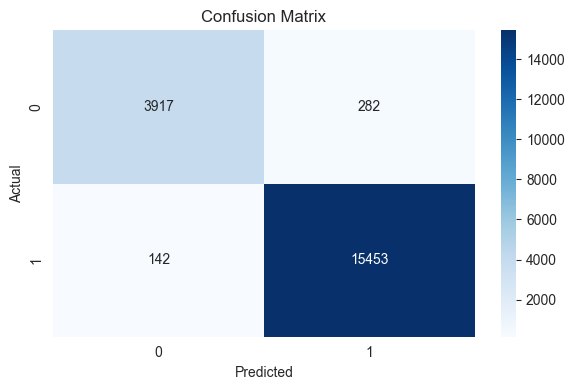

In [60]:
cm = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.tight_layout()

## Evaluating Learner (PPO)

In [44]:
local_path = mlflow.artifacts.download_artifacts(
    artifact_uri="mlflow-artifacts:/720343879195193287/c3122459182745a6931550125ca86cc7/artifacts/learner0v2.zip"
)

learner_trained0 = PPO.load(local_path, weights_only=False)

In [45]:
learner0_untrained = PPO(
    env=venv0_test,
    policy=MlpPolicy,
    policy_kwargs=policy_kwargs,
    learning_rate=learning_rate,
    n_steps=n_steps,
    batch_size=batch_size,
    n_epochs=n_epochs,
    gamma=gamma,
    gae_lambda=gae_lambda,
    clip_range=clip_range,
    clip_range_vf=clip_range_vf,
    normalize_advantage=normalize_advantage,
    ent_coef=ent_coef,
    vf_coef=vf_coef,
    max_grad_norm=max_grad_norm,
    use_sde=use_sde,
    sde_sample_freq=sde_sample_freq,
    verbose=verbose,
    seed=42,
    device="mps",
)

In [46]:
venv0_test.seed(42)

learner_rewards_after_training, episode_len = evaluate_policy(
    learner_trained0, venv0_test, 10, return_episode_rewards=True
)

learner_rewards_after_training = [
    r / l for r, l in zip(learner_rewards_after_training, episode_len)
]

print(np.mean(episode_len))
print("Reward of the learner policy after training")
print("Mean: ", np.mean(learner_rewards_after_training))
print("Std: ", np.std(learner_rewards_after_training))

12.7
Reward of the learner policy after training
Mean:  0.4990654205607477
Std:  0.22152490042724796


In [48]:
venv0_test.seed(42)

learner_rewards_before_training, episode_len = evaluate_policy(
    learner0, venv0_test, 10, return_episode_rewards=True
)

learner_rewards_before_training = [
    r / l for r, l in zip(learner_rewards_before_training, episode_len)
]

print(np.mean(episode_len))
print("Reward of the learner policy berfore training")
print("Mean: ", np.mean(learner_rewards_before_training))
print("Std: ", np.std(learner_rewards_before_training))

12.7
Reward of the learner policy berfore training
Mean:  0.2953271028037383
Std:  0.3219541390308488
